# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


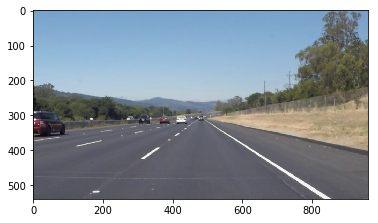

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
import statistics
import inspect
from scipy import spatial

class CircularBuffer(object):
    def __init__(self, size):
        self.index= 0
        self.size= size
        self._data = []

    def push(self, value):
        if len(self._data) == self.size:
            self._data[self.index]= value
        else:
            self._data.append(value)
        self.index= (self.index + 1) % self.size

    def __getitem__(self, key):
        return(self._data[key])

    def __len__(self):
         return len(self._data)
        
    def average_point(self):
        #print(self._data[0])
        
        m = sum([x[0] for x in self._data])/len(self)
        b = sum([x[1] for x in self._data])/len(self)
 
        return m,b
        #return int(m),int(b)    

    def get_all(self):
        return(self._data)
    
    
    
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    global right_buffer
    global left_buffer
    #buffer_left = CircularBuffer(10)
    #buffer_right = CircularBuffer(10)
    
    imshape = img.shape
    
    #print("This image is:", type(image), "with dimensions:", image.shape)
    #print("x:", image.shape[0], "y:", image.shape[1])
    
    
    lines_parametrized = []
    left_candidates = []
    right_candidates = []
    
    median_slope = image.shape[0]/image.shape[1]
    max_slope = (3*median_slope)*1e3;
    min_slope= (0.9*median_slope)*1e3;
    
    #print("max_slope:", max_slope, "min_slope:", min_slope)

    
    #calculate M and B for all lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (abs(x2-x1) > 10) and (abs(y2-y1) > 10): # ignore lines less than 10 
                m = (y2-y1)/(x2-x1)
                lines_parametrized.append([x1,y1,x2,y2, int(m*1e3) , int(y1 - x1*m) ])
    
    # Split lines by slope sign
    for line in lines_parametrized:
        m = line[4]
        if (abs(m) < max_slope) and (abs(m) > min_slope):
            if m > 0:
                right_candidates.append(line)
            else:
                left_candidates.append(line)
    
    
    if buffer_right:
        print(buffer_right.get_all())
        reference = buffer_right.average_point()
        idx = choose_candidate(reference, right_candidates)
        right_pivot = right_candidates[idx]
    else:
        right_candidates = sorted(right_candidates, key=lambda x: x[4], reverse=True)
        right_pivot = right_candidates[0] 
        
    all_right = right_candidates

    m_right = right_pivot[4]
    b_right = right_pivot[5]
    
    right_candidates = list(filter(lambda x: (x[4] > (m_right - 2000)) and (x[4] < (m_right + 2000)), right_candidates))
    #right_candidates = list(filter(lambda x: (x[5] > (b_right - 100)) and (x[5] < (b_right + 100)), right_candidates))
    
    m_right = sum(x[4] for x in right_candidates)/len((right_candidates))
    b_right = sum(x[5] for x in right_candidates)/len((right_candidates))
    
    print("m_right", m_right, "b_right", b_right)

    buffer_right.push([m_right, b_right])
    
    right_y_end = min( min([i[1],i[3]]) for i in right_candidates)
        

    if buffer_left:
        reference = buffer_left.average_point()
        idx = choose_candidate(reference, left_candidates)
        left_pivot = left_candidates[idx]
    else:
        left_candidates = sorted(left_candidates, key=lambda x: x[4])
        left_pivot = left_candidates[0] 
        

    all_left = left_candidates
    

    print(type(left_pivot))
    m_left = left_pivot[4]
    b_left = left_pivot[5]
    
    left_candidates = list(filter(lambda x: (x[4] > (m_left - 2000)) and (x[4] < (m_left + 2000)), left_candidates))
    #left_candidates = list(filter(lambda x: (x[5] > (b_left - 100)) and (x[5] < (b_left + 100)), left_candidates))
    
    #m_left, b_left = choose_candidate(left_candidates, 'left')
    
    m_left = sum(x[4] for x in left_candidates)/len((left_candidates))
    b_left = sum(x[5] for x in left_candidates)/len((left_candidates))

    print("m_left", m_left, "b_left", b_left)
    
    buffer_left.push([m_left, b_left])
    
    candidate_lines = np.asarray([left_candidates, right_candidates])
    all_lines = np.asarray([all_right, all_left])
    
    left_y_end = min( min([i[1],i[3]]) for i in left_candidates)
    

    m_left, b_left = buffer_left.average_point()
    m_right, b_right= buffer_right.average_point()
    
    y_start = imshape[0]
    
    intersect_x = int((b_right - b_left)/(m_left/1e3 - m_right/1e3))
    intersect_y = int(m_left/1e3 * intersect_x + b_left)
    
    
    left_y1 = int(y_start)
    left_y2 = max(left_y_end, intersect_y)
    
    left_x1= calculate_x(y_start, m_left, b_left)
    left_x2 = calculate_x(left_y2, m_left, b_left) 
    
    
    right_y1 = int(y_start)
    right_y2 = max(right_y_end, intersect_y)


    right_x1 = calculate_x(y_start, m_right, b_right)
    right_x2 = calculate_x(right_y2, m_right, b_right) 
    
    #for line in all_lines:
    #    for x1,y1,x2,y2,m,b in line:
    #        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), thickness=7)
        
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), (255, 0, 0), thickness=15)   
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), (255, 0, 0), thickness=15)   


    #for line in candidate_lines:
    #    for x1,y1,x2,y2,m,b in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness=4)
            
def calculate_x(y,m,b):
    return int((y - b)/(m/1e3))

def choose_candidate(reference, candidates, title='title'):
    #TODO use averaging instead
    
    k = len(candidates)

    #print(k)

    m = [i[4] for i in candidates ]
    b = [i[5] for i in candidates ]
     
    #return sum(m)/len(m), sum(b)/len(b)    
        
    if( k == 1):
        return m[0], b[0]    
        
    #plt.figure()
    #plt.scatter(m,b, c='gray')
    #plt.title(title)
    #plt.xlabel("M")
    #plt.ylabel("B")reverse

    
    Points = list(zip(m, b)) 
    kdtree = spatial.KDTree(Points)
    dist, ind = kdtree.query(Points, k)
    
    #print(dist)
    res = [sum(i) for i in dist]
    idx = min(range(len(res)), key=res.__getitem__)
    
    #plt.scatter(m[idx],b[idx], c='red')
    #plt.title(title)
    #plt.xlabel("M")
    #plt.ylabel("B")
    return idx
    
    #return m[idx],b[idx]
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        max
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_-4:-1]lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
image_filenames = os.listdir("test_images/")
print(image_filenames)
#image_filenames = ['solidYellowLeft.jpg']
#image_filenames = ['solidWhiteCurve.jpg']
#image_filenames = ['whiteCarLaneSwitch.jpg']
#image_filenames = ['solidYellowCurve.jpg']
#image_filenames = ['solidYellowCurve2.jpg']



['solidYellowLeft.jpg', 'solidWhiteCurve.jpg', 'whiteCarLaneSwitch.jpg', 'solidYellowCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve2.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

m_right 649.65 b_right -6.9
<class 'list'>
m_left -771.725 b_left 669.85
m_right 582.875 b_right 25.791666666666668
<class 'list'>
m_left -799.6666666666666 b_left 689.7083333333334
m_right 546.9411764705883 b_right 50.705882352941174
<class 'list'>
m_left -804.4634146341464 b_left 695.9024390243902
m_right 589.0769230769231 b_right 34.07692307692308
<class 'list'>
m_left -758.75 b_left 668.1428571428571
m_right 664.1428571428571 b_right -14.333333333333334
<class 'list'>
m_left -724.625 b_left 653.1875
m_right 593.45 b_right 27.05
<class 'list'>
m_left -729.2758620689655 b_left 656.8620689655172


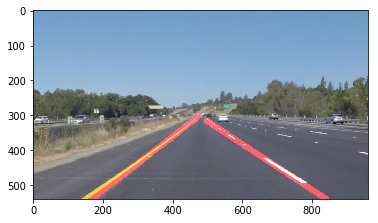

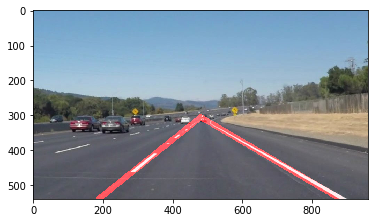

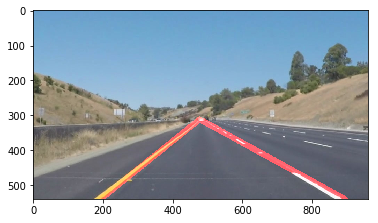

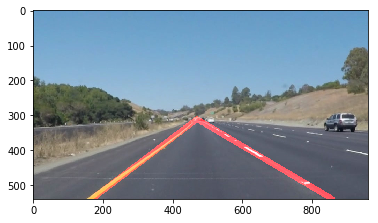

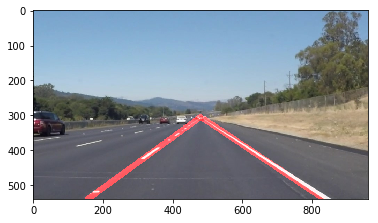

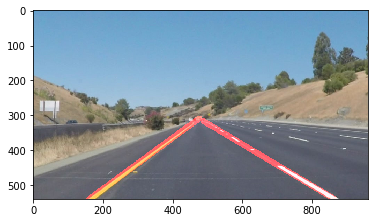

In [5]:

buffer_right = CircularBuffer(10)
buffer_left = CircularBuffer(10)


def get_region_of_interest_vertices(imshape, height_factor=.55, top_left_factor=.45, right_top_factor=.55):
    left_bottom = [0, imshape[0]]
    left_top = [top_left_factor*imshape[1], right_top_factor*imshape[0]]
    right_top = [height_factor*imshape[1], height_factor*imshape[0]]
    right_bottom = [imshape[1],imshape[0]]
    
    vertices = np.array([[left_bottom,left_top,right_top,right_bottom]], np.int32)
    return vertices

def process(image, clear_buffer=False):
    
    global buffer_right
    global buffer_left
    
    if not buffer_left or clear_buffer:
        buffer_left = CircularBuffer(10)
        
    if not buffer_right or clear_buffer:
        buffer_right = CircularBuffer(10)
    
    
    vertices = get_region_of_interest_vertices(image.shape)
    #print(image.shape)
    #image = region_of_interest(img=image, vertices=vertices )
    
    blur_gray = gaussian_blur(img=grayscale(image), kernel_size=11)
    
    blur_gray = cv2.adaptiveThreshold(blur_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    
    
    v = np.median(image)
    sigma = 0.50
    
    
    # apply automatic Canny edge detection using the computed median
    lower = int(v*0.66)
    upper = int(v*1.33)
    #edged = cv2.Canny(image, lower, upper)
    
    #black_white = np.dstack((blur_gray,blur_gray,blur_gray))
    #return rgb
    #print(blur_gray.shape)
    #return blur_gray
    #plt.figure()
    #plt.imshow(blur_gray)
    
    edges = canny(img=blur_gray, low_threshold=lower, high_threshold=upper)
        
    
    masked_edges = region_of_interest(img=edges, vertices=vertices )
        
    line_img = hough_lines(img=masked_edges, rho=3, theta=np.pi/180, threshold=60, min_line_len=5, max_line_gap=5)
    
    final = weighted_img(image, line_img)
    
    #uncomment to show are of interest
    #cv2.polylines(final, [vertices], True, (0,0,255),3)
    
    return final

for index,filename in enumerate(image_filenames):
    image = mpimg.imread("test_images/" + filename)
    
    
    lanes_image = process(image, True)
    plt.figure()
    plt.imshow(lanes_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    result = process(image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[[593.45, 27.05]]
m_right 633.6 b_right -3.6
<class 'list'>
m_left -734.9666666666667 b_left 653.6666666666666
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|▏         | 3/222 [00:00<00:09, 23.94it/s]

[[593.45, 27.05], [633.6, -3.6]]
m_right 633.6 b_right -3.6
<class 'list'>
m_left -734.9666666666667 b_left 653.6666666666666
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6]]
m_right 635.9545454545455 b_right -3.6818181818181817
<class 'list'>
m_left -733.875 b_left 654.125
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817]]
m_right 608.6 b_right 15.0
<class 'list'>
m_left -745.952380952381 b_left 658.1904761904761
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0]]
m_right 621.84 b_right 8.4
<class 'list'>
m_left -729.0 b_left 652.4814814814815
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4]]
m_right 620.2777777777778 b_right 9.055555555555555
<class 'list'>
m_left -722.8421052631579 b_left 649.3157894736842
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4], 

  3%|▎         | 6/222 [00:00<00:08, 24.91it/s]

 628.2222222222222 b_right 2.7222222222222223
<class 'list'>
m_left -746.5882352941177 b_left 657.5294117647059
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223]]
m_right 604.1176470588235 b_right 15.705882352941176
<class 'list'>
m_left -694.2666666666667 b_left 635.9333333333333
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15.705882352941176]]
m_right 629.3 b_right -2.85
<class 'list'>
m_left -717.8181818181819 b_left 646.9090909090909
[[593.45, 27.05], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15.70588235

  5%|▍         | 10/222 [00:00<00:08, 26.41it/s]

[[614.625, 10.0], [633.6, -3.6], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15.705882352941176], [629.3, -2.85]]
m_right 621.3076923076923 b_right 11.384615384615385
<class 'list'>
m_left -717.2142857142857 b_left 649.7142857142857
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [633.6, -3.6], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15.705882352941176], [629.3, -2.85]]
m_right 626.8 b_right 7.0
<class 'list'>
m_left -733.578947368421 b_left 655.8947368421053
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [635.9545454545455, -3.6818181818181817], [608.6, 15.0], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15

  6%|▌         | 13/222 [00:00<00:08, 26.04it/s]

 641.3333333333334 b_right 1.2222222222222223
<class 'list'>
m_left -709.7647058823529 b_left 649.9411764705883
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [641.3333333333334, 1.2222222222222223], [608.6, 15.0], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15.705882352941176], [629.3, -2.85]]
m_right 628.3076923076923 b_right 9.884615384615385
<class 'list'>
m_left -716.7272727272727 b_left 648.9545454545455
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [641.3333333333334, 1.2222222222222223], [628.3076923076923, 9.884615384615385], [621.84, 8.4], [620.2777777777778, 9.055555555555555], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15.705882352941176], [629.3, -2.85]]
m_right 674.0 b_right -16.82608695652174
<class 'list'>
m_left -705.516129032258 b_left 642.483870967742
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [64

  7%|▋         | 16/222 [00:00<00:08, 25.61it/s]

[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [641.3333333333334, 1.2222222222222223], [628.3076923076923, 9.884615384615385], [674.0, -16.82608695652174], [645.4444444444445, -3.8333333333333335], [628.2222222222222, 2.7222222222222223], [604.1176470588235, 15.705882352941176], [629.3, -2.85]]
m_right 636.8421052631579 b_right -3.0
<class 'list'>
m_left -718.1666666666666 b_left 643.7222222222222
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [641.3333333333334, 1.2222222222222223], [628.3076923076923, 9.884615384615385], [674.0, -16.82608695652174], [645.4444444444445, -3.8333333333333335], [636.8421052631579, -3.0], [604.1176470588235, 15.705882352941176], [629.3, -2.85]]
m_right 646.75 b_right -5.125
<class 'list'>
m_left -706.1176470588235 b_left 639.6470588235294
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [641.3333333333334, 1.2222222222222223], [628.3076923076923, 9.884615384615385], [674.0, -16.8

  9%|▊         | 19/222 [00:00<00:07, 26.24it/s]

 663.25 b_right -15.857142857142858
<class 'list'>
m_left -684.5 b_left 633.3333333333334
[[614.625, 10.0], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [641.3333333333334, 1.2222222222222223], [628.3076923076923, 9.884615384615385], [674.0, -16.82608695652174], [645.4444444444445, -3.8333333333333335], [636.8421052631579, -3.0], [646.75, -5.125], [663.25, -15.857142857142858]]
m_right 671.9473684210526 b_right -14.578947368421053
<class 'list'>
m_left -679.375 b_left 632.0625
[[671.9473684210526, -14.578947368421053], [621.3076923076923, 11.384615384615385], [626.8, 7.0], [641.3333333333334, 1.2222222222222223], [628.3076923076923, 9.884615384615385], [674.0, -16.82608695652174], [645.4444444444445, -3.8333333333333335], [636.8421052631579, -3.0], [646.75, -5.125], [663.25, -15.857142857142858]]
m_right 651.65 b_right -2.25
<class 'list'>
m_left -719.6 b_left 648.3333333333334
[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [626.8, 7.0], [641.3333333333334, 1.222

 10%|█         | 23/222 [00:00<00:07, 27.79it/s]

[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [708.0, -37.166666666666664], [641.3333333333334, 1.2222222222222223], [628.3076923076923, 9.884615384615385], [674.0, -16.82608695652174], [645.4444444444445, -3.8333333333333335], [636.8421052631579, -3.0], [646.75, -5.125], [663.25, -15.857142857142858]]
m_right 633.5294117647059 b_right 3.3529411764705883
<class 'list'>
m_left -719.421052631579 b_left 652.3684210526316
[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [628.3076923076923, 9.884615384615385], [674.0, -16.82608695652174], [645.4444444444445, -3.8333333333333335], [636.8421052631579, -3.0], [646.75, -5.125], [663.25, -15.857142857142858]]
m_right 650.0714285714286 b_right -6.857142857142857
<class 'list'>
m_left -659.8666666666667 b_left 625.2
[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [650.071

 12%|█▏        | 26/222 [00:00<00:07, 27.82it/s]

[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [650.0714285714286, -6.857142857142857], [640.0, -2.6363636363636362], [631.8, 1.35], [636.8421052631579, -3.0], [646.75, -5.125], [663.25, -15.857142857142858]]
m_right 648.7619047619048 b_right -4.0
<class 'list'>
m_left -721.7 b_left 650.7
[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [650.0714285714286, -6.857142857142857], [640.0, -2.6363636363636362], [631.8, 1.35], [648.7619047619048, -4.0], [646.75, -5.125], [663.25, -15.857142857142858]]
m_right 659.0714285714286 b_right -9.642857142857142
<class 'list'>
m_left -709.1904761904761 b_left 647.4285714285714
[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [650.0714285714286, -6.857142857142857], [640.0, -2.6363636363636362], [631.8, 1.35

 14%|█▎        | 30/222 [00:01<00:06, 29.43it/s]

[[671.9473684210526, -14.578947368421053], [651.65, -2.25], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [650.0714285714286, -6.857142857142857], [640.0, -2.6363636363636362], [631.8, 1.35], [648.7619047619048, -4.0], [659.0714285714286, -9.642857142857142], [641.0909090909091, 3.5454545454545454]]
m_right 640.4 b_right 0.0
<class 'list'>
m_left -714.9411764705883 b_left 647.9411764705883
[[640.4, 0.0], [651.65, -2.25], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [650.0714285714286, -6.857142857142857], [640.0, -2.6363636363636362], [631.8, 1.35], [648.7619047619048, -4.0], [659.0714285714286, -9.642857142857142], [641.0909090909091, 3.5454545454545454]]
m_right 641.8 b_right -1.4
<class 'list'>
m_left -720.4666666666667 b_left 648.3333333333334
[[640.4, 0.0], [641.8, -1.4], [708.0, -37.166666666666664], [633.5294117647059, 3.3529411764705883], [650.0714285714286, -6.857142857142857], [640.0, -2.6363636363636362], [631.8, 1.35], [648

 15%|█▌        | 34/222 [00:01<00:06, 29.98it/s]

[[640.4, 0.0], [641.8, -1.4], [632.1851851851852, 2.7777777777777777], [635.44, -1.56], [650.0714285714286, -6.857142857142857], [640.0, -2.6363636363636362], [631.8, 1.35], [648.7619047619048, -4.0], [659.0714285714286, -9.642857142857142], [641.0909090909091, 3.5454545454545454]]
m_right 639.8235294117648 b_right -4.823529411764706
<class 'list'>
m_left -711.0625 b_left 645.0625
[[640.4, 0.0], [641.8, -1.4], [632.1851851851852, 2.7777777777777777], [635.44, -1.56], [639.8235294117648, -4.823529411764706], [640.0, -2.6363636363636362], [631.8, 1.35], [648.7619047619048, -4.0], [659.0714285714286, -9.642857142857142], [641.0909090909091, 3.5454545454545454]]
m_right 659.1538461538462 b_right -14.846153846153847
<class 'list'>
m_left -810.7368421052631 b_left 684.0526315789474
[[640.4, 0.0], [641.8, -1.4], [632.1851851851852, 2.7777777777777777], [635.44, -1.56], [639.8235294117648, -4.823529411764706], [659.1538461538462, -14.846153846153847], [631.8, 1.35], [648.7619047619048, -4.0], 

 17%|█▋        | 37/222 [00:01<00:06, 29.52it/s]

m_right 643.0454545454545 b_right -3.9545454545454546
<class 'list'>
m_left -702.2857142857143 b_left 643.5238095238095
[[640.4, 0.0], [641.8, -1.4], [632.1851851851852, 2.7777777777777777], [635.44, -1.56], [639.8235294117648, -4.823529411764706], [659.1538461538462, -14.846153846153847], [632.9285714285714, 0.42857142857142855], [622.7619047619048, 8.619047619047619], [643.0454545454545, -3.9545454545454546], [641.0909090909091, 3.5454545454545454]]
m_right 653.8260869565217 b_right -7.217391304347826
<class 'list'>
m_left -751.9333333333333 b_left 664.7


 18%|█▊        | 40/222 [00:01<00:06, 27.90it/s]

[[640.4, 0.0], [641.8, -1.4], [632.1851851851852, 2.7777777777777777], [635.44, -1.56], [639.8235294117648, -4.823529411764706], [659.1538461538462, -14.846153846153847], [632.9285714285714, 0.42857142857142855], [622.7619047619048, 8.619047619047619], [643.0454545454545, -3.9545454545454546], [653.8260869565217, -7.217391304347826]]
m_right 633.16 b_right 3.76
<class 'list'>
m_left -706.5384615384615 b_left 646.1923076923077
[[633.16, 3.76], [641.8, -1.4], [632.1851851851852, 2.7777777777777777], [635.44, -1.56], [639.8235294117648, -4.823529411764706], [659.1538461538462, -14.846153846153847], [632.9285714285714, 0.42857142857142855], [622.7619047619048, 8.619047619047619], [643.0454545454545, -3.9545454545454546], [653.8260869565217, -7.217391304347826]]
m_right 636.8421052631579 b_right -0.8947368421052632
<class 'list'>
m_left -714.85 b_left 645.15
[[633.16, 3.76], [636.8421052631579, -0.8947368421052632], [632.1851851851852, 2.7777777777777777], [635.44, -1.56], [639.823529411764

 19%|█▉        | 43/222 [00:01<00:06, 28.08it/s]

[[633.16, 3.76], [636.8421052631579, -0.8947368421052632], [666.421052631579, -16.42105263157895], [673.9583333333334, -23.791666666666668], [639.8235294117648, -4.823529411764706], [659.1538461538462, -14.846153846153847], [632.9285714285714, 0.42857142857142855], [622.7619047619048, 8.619047619047619], [643.0454545454545, -3.9545454545454546], [653.8260869565217, -7.217391304347826]]
m_right 660.3478260869565 b_right -13.91304347826087
<class 'list'>
m_left -735.5238095238095 b_left 651.952380952381
[[633.16, 3.76], [636.8421052631579, -0.8947368421052632], [666.421052631579, -16.42105263157895], [673.9583333333334, -23.791666666666668], [660.3478260869565, -13.91304347826087], [659.1538461538462, -14.846153846153847], [632.9285714285714, 0.42857142857142855], [622.7619047619048, 8.619047619047619], [643.0454545454545, -3.9545454545454546], [653.8260869565217, -7.217391304347826]]
m_right 660.5217391304348 b_right -18.695652173913043
<class 'list'>
m_left -753.1666666666666 b_left 65

 21%|██        | 46/222 [00:01<00:06, 28.01it/s]

[[633.16, 3.76], [636.8421052631579, -0.8947368421052632], [666.421052631579, -16.42105263157895], [673.9583333333334, -23.791666666666668], [660.3478260869565, -13.91304347826087], [660.5217391304348, -18.695652173913043], [632.9285714285714, 0.42857142857142855], [622.7619047619048, 8.619047619047619], [643.0454545454545, -3.9545454545454546], [653.8260869565217, -7.217391304347826]]
m_right 665.44 b_right -17.04
<class 'list'>
m_left -720.8421052631579 b_left 646.2631578947369
[[633.16, 3.76], [636.8421052631579, -0.8947368421052632], [666.421052631579, -16.42105263157895], [673.9583333333334, -23.791666666666668], [660.3478260869565, -13.91304347826087], [660.5217391304348, -18.695652173913043], [665.44, -17.04], [622.7619047619048, 8.619047619047619], [643.0454545454545, -3.9545454545454546], [653.8260869565217, -7.217391304347826]]
m_right 665.4166666666666 b_right -19.291666666666668
<class 'list'>
m_left -778.047619047619 b_left 669.6190476190476
[[633.16, 3.76], [636.842105263

 22%|██▏       | 49/222 [00:01<00:06, 27.61it/s]

[[633.16, 3.76], [636.8421052631579, -0.8947368421052632], [666.421052631579, -16.42105263157895], [673.9583333333334, -23.791666666666668], [660.3478260869565, -13.91304347826087], [660.5217391304348, -18.695652173913043], [665.44, -17.04], [665.4166666666666, -19.291666666666668], [651.6875, -9.75], [640.7307692307693, -4.884615384615385]]
m_right 623.8333333333334 b_right 9.166666666666666
<class 'list'>
m_left -721.5 b_left 646.5
[[623.8333333333334, 9.166666666666666], [636.8421052631579, -0.8947368421052632], [666.421052631579, -16.42105263157895], [673.9583333333334, -23.791666666666668], [660.3478260869565, -13.91304347826087], [660.5217391304348, -18.695652173913043], [665.44, -17.04], [665.4166666666666, -19.291666666666668], [651.6875, -9.75], [640.7307692307693, -4.884615384615385]]
m_right 648.6315789473684 b_right -8.368421052631579
<class 'list'>
m_left -778.7407407407408 b_left 667.2222222222222


 23%|██▎       | 52/222 [00:01<00:06, 27.31it/s]

[[623.8333333333334, 9.166666666666666], [648.6315789473684, -8.368421052631579], [666.421052631579, -16.42105263157895], [673.9583333333334, -23.791666666666668], [660.3478260869565, -13.91304347826087], [660.5217391304348, -18.695652173913043], [665.44, -17.04], [665.4166666666666, -19.291666666666668], [651.6875, -9.75], [640.7307692307693, -4.884615384615385]]
m_right 662.0 b_right -15.76
<class 'list'>
m_left -731.9230769230769 b_left 650.0
[[623.8333333333334, 9.166666666666666], [648.6315789473684, -8.368421052631579], [662.0, -15.76], [673.9583333333334, -23.791666666666668], [660.3478260869565, -13.91304347826087], [660.5217391304348, -18.695652173913043], [665.44, -17.04], [665.4166666666666, -19.291666666666668], [651.6875, -9.75], [640.7307692307693, -4.884615384615385]]
m_right 639.7826086956521 b_right -3.130434782608696
<class 'list'>
m_left -696.5925925925926 b_left 636.4074074074074
[[623.8333333333334, 9.166666666666666], [648.6315789473684, -8.368421052631579], [662.

 25%|██▍       | 55/222 [00:01<00:06, 26.71it/s]

[[623.8333333333334, 9.166666666666666], [648.6315789473684, -8.368421052631579], [662.0, -15.76], [639.7826086956521, -3.130434782608696], [632.8076923076923, 3.076923076923077], [638.1785714285714, -2.9642857142857144], [665.44, -17.04], [665.4166666666666, -19.291666666666668], [651.6875, -9.75], [640.7307692307693, -4.884615384615385]]
m_right 630.65 b_right 3.65
<class 'list'>
m_left -713.5555555555555 b_left 644.1666666666666
[[623.8333333333334, 9.166666666666666], [648.6315789473684, -8.368421052631579], [662.0, -15.76], [639.7826086956521, -3.130434782608696], [632.8076923076923, 3.076923076923077], [638.1785714285714, -2.9642857142857144], [630.65, 3.65], [665.4166666666666, -19.291666666666668], [651.6875, -9.75], [640.7307692307693, -4.884615384615385]]
m_right

 26%|██▌       | 58/222 [00:02<00:06, 26.97it/s]

 640.1666666666666 b_right -1.7083333333333333
<class 'list'>
m_left -682.1052631578947 b_left 632.4736842105264
[[623.8333333333334, 9.166666666666666], [648.6315789473684, -8.368421052631579], [662.0, -15.76], [639.7826086956521, -3.130434782608696], [632.8076923076923, 3.076923076923077], [638.1785714285714, -2.9642857142857144], [630.65, 3.65], [640.1666666666666, -1.7083333333333333], [651.6875, -9.75], [640.7307692307693, -4.884615384615385]]
m_right 658.125 b_right -10.5
<class 'list'>
m_left -699.9333333333333 b_left 640.4
[[623.8333333333334, 9.166666666666666], [648.6315789473684, -8.368421052631579], [662.0, -15.76], [639.7826086956521, -3.130434782608696], [632.8076923076923, 3.076923076923077], [638.1785714285714, -2.9642857142857144], [630.65, 3.65], [640.1666666666666, -1.7083333333333333], [658.125, -10.5], [640.7307692307693, -4.884615384615385]]
m_right 678.6315789473684 b_right -20.842105263157894
<class 'list'>
m_left -678.5882352941177 b_left 632.4705882352941
[[62

 27%|██▋       | 61/222 [00:02<00:05, 27.21it/s]

[[635.4761904761905, 3.0476190476190474], [651.9047619047619, -8.238095238095237], [662.0, -15.76], [639.7826086956521, -3.130434782608696], [632.8076923076923, 3.076923076923077], [638.1785714285714, -2.9642857142857144], [630.65, 3.65], [640.1666666666666, -1.7083333333333333], [658.125, -10.5], [678.6315789473684, -20.842105263157894]]
m_right 657.9615384615385 b_right -12.038461538461538
<class 'list'>
m_left -686.2105263157895 b_left 634.3684210526316


 29%|██▉       | 64/222 [00:02<00:05, 26.71it/s]

[[635.4761904761905, 3.0476190476190474], [651.9047619047619, -8.238095238095237], [657.9615384615385, -12.038461538461538], [639.7826086956521, -3.130434782608696], [632.8076923076923, 3.076923076923077], [638.1785714285714, -2.9642857142857144], [630.65, 3.65], [640.1666666666666, -1.7083333333333333], [658.125, -10.5], [678.6315789473684, -20.842105263157894]]
m_right 636.9090909090909 b_right 4.181818181818182
<class 'list'>
m_left -702.2631578947369 b_left 640.5263157894736
[[635.4761904761905, 3.0476190476190474], [651.9047619047619, -8.238095238095237], [657.9615384615385, -12.038461538461538], [636.9090909090909, 4.181818181818182], [632.8076923076923, 3.076923076923077], [638.1785714285714, -2.9642857142857144], [630.65, 3.65], [640.1666666666666, -1.7083333333333333], [658.125, -10.5], [678.6315789473684, -20.842105263157894]]
m_right 660.4705882352941 b_right -13.235294117647058
<class 'list'>
m_left -679.578947368421 b_left 630.8421052631579
[[635.4761904761905, 3.047619047

 30%|███       | 67/222 [00:02<00:05, 27.28it/s]

[[635.4761904761905, 3.0476190476190474], [651.9047619047619, -8.238095238095237], [657.9615384615385, -12.038461538461538], [636.9090909090909, 4.181818181818182], [660.4705882352941, -13.235294117647058], [642.7727272727273, -0.9090909090909091], [660.76, -11.72], [644.625, -1.5625], [658.125, -10.5], [678.6315789473684, -20.842105263157894]]
m_right 648.3846153846154 b_right -7.230769230769231
<class 'list'>
m_left -637.5833333333334 b_left 611.9166666666666


 32%|███▏      | 70/222 [00:02<00:05, 27.57it/s]

[[635.4761904761905, 3.0476190476190474], [651.9047619047619, -8.238095238095237], [657.9615384615385, -12.038461538461538], [636.9090909090909, 4.181818181818182], [660.4705882352941, -13.235294117647058], [642.7727272727273, -0.9090909090909091], [660.76, -11.72], [644.625, -1.5625], [648.3846153846154, -7.230769230769231], [678.6315789473684, -20.842105263157894]]
m_right 652.4074074074074 b_right -8.518518518518519
<class 'list'>
m_left -690.0 b_left 633.9333333333333
[[635.4761904761905, 3.0476190476190474], [651.9047619047619, -8.238095238095237], [657.9615384615385, -12.038461538461538], [636.9090909090909, 4.181818181818182], [660.4705882352941, -13.235294117647058], [642.7727272727273, -0.9090909090909091], [660.76, -11.72], [644.625, -1.5625], [648.3846153846154, -7.230769230769231], [652.4074074074074, -8.518518518518519]]
m_right 663.0333333333333 b_right -11.933333333333334
<class 'list'>
m_left -635.0 b_left 613.3125
[[663.0333333333333, -11.933333333333334], [651.9047619

 35%|███▍      | 77/222 [00:02<00:05, 26.91it/s]


m_left -663.2857142857143 b_left 621.7142857142857
[[663.0333333333333, -11.933333333333334], [656.9, -10.8], [649.3125, -7.75], [659.9375, -12.5], [678.5769230769231, -24.846153846153847], [666.6, -13.76], [660.76, -11.72], [644.625, -1.5625], [648.3846153846154, -7.230769230769231], [652.4074074074074, -8.518518518518519]]
m_right 669.25 b_right -15.1875
<class 'list'>
m_left -700.36 b_left 636.04
[[663.0333333333333, -11.933333333333334], [656.9, -10.8], [649.3125, -7.75], [659.9375, -12.5], [678.5769230769231, -24.846153846153847], [666.6, -13.76], [669.25, -15.1875], [644.625, -1.5625], [648.3846153846154, -7.230769230769231], [652.4074074074074, -8.518518518518519]]
m_right 665.8666666666667 b_right -14.0
<class 'list'>
m_left -674.2 b_left 625.96
[[663.0333333333333, -11.933333333333334], [656.9, -10.8], [649.3125, -7.75], [659.9375, -12.5], [678.5769230769231, -24.846153846153847], [666.6, -13.76], [669.25, -15.1875], [665.8666666666667, -14.0], [648.3846153846154, -7.23076923

 36%|███▌      | 80/222 [00:02<00:05, 27.24it/s]

 679.7 b_right -21.5
<class 'list'>
m_left -651.0909090909091 b_left 616.0909090909091
[[663.0333333333333, -11.933333333333334], [656.9, -10.8], [649.3125, -7.75], [659.9375, -12.5], [678.5769230769231, -24.846153846153847], [666.6, -13.76], [669.25, -15.1875], [665.8666666666667, -14.0], [682.3125, -21.8125], [679.7, -21.5]]
m_right 677.8181818181819 b_right -22.0
<class 'list'>
m_left -717.4 b_left 640.5333333333333
[[677.8181818181819, -22.0], [656.9, -10.8], [649.3125, -7.75], [659.9375, -12.5], [678.5769230769231, -24.846153846153847], [666.6, -13.76], [669.25, -15.1875], [665.8666666666667, -14.0], [682.3125, -21.8125], [679.7, -21.5]]
m_right 677.1304347826087 b_right -19.608695652173914
<class 'list'>
m_left -682.2 b_left 627.6666666666666
[[677.8181818181819, -22.0], [677.1304347826087, -19.608695652173914], [649.3125, -7.75], [659.9375, -12.5], [678.5769230769231, -24.846153846153847], [666.6, -13.76], [669.25, -15.1875], [665.8666666666667, -14.0], [682.3125, -21.8125], [67

 38%|███▊      | 84/222 [00:03<00:04, 28.50it/s]

[[677.8181818181819, -22.0], [677.1304347826087, -19.608695652173914], [687.92, -25.0], [659.1578947368421, -9.421052631578947], [678.2777777777778, -21.166666666666668], [662.0952380952381, -13.047619047619047], [669.25, -15.1875], [665.8666666666667, -14.0], [682.3125, -21.8125], [679.7, -21.5]]
m_right 657.3333333333334 b_right -9.714285714285714
<class 'list'>
m_left -639.75 b_left 611.6
[[677.8181818181819, -22.0], [677.1304347826087, -19.608695652173914], [687.92, -25.0], [659.1578947368421, -9.421052631578947], [678.2777777777778, -21.166666666666668], [662.0952380952381, -13.047619047619047], [657.3333333333334, -9.714285714285714], [665.8666666666667, -14.0], [682.3125, -21.8125], [679.7, -21.5]]
m_right 674.8888888888889 b_right -17.85185185185185
<class 'list'>
m_left -670.1818181818181 b_left 625.1363636363636
[[677.8181818181819, -22.0], [677.1304347826087, -19.608695652173914], [687.92, -25.0], [659.1578947368421, -9.421052631578947], [678.2777777777778, -21.1666666666666

 39%|███▉      | 87/222 [00:03<00:05, 26.87it/s]

<class 'list'>
m_left -696.4193548387096 b_left 635.6451612903226
[[677.8181818181819, -22.0], [677.1304347826087, -19.608695652173914], [687.92, -25.0], [659.1578947368421, -9.421052631578947], [678.2777777777778, -21.166666666666668], [662.0952380952381, -13.047619047619047], [657.3333333333334, -9.714285714285714], [674.8888888888889, -17.85185185185185], [684.9583333333334, -24.583333333333332], [679.7, -21.5]]
m_right 687.5652173913044 b_right -25.217391304347824
<class 'list'>
m_left -676.5 b_left 628.0
[[677.8181818181819, -22.0], [677.1304347826087, -19.608695652173914], [687.92, -25.0], [659.1578947368421, -9.421052631578947], [678.2777777777778, -21.166666666666668], [662.0952380952381, -13.047619047619047], [657.3333333333334, -9.714285714285714], [674.8888888888889, -17.85185185185185], [684.9583333333334, -24.583333333333332], [687.5652173913044, -25.217391304347824]]
m_right 684.6666666666666 b_right -24.428571428571427
<class 'list'>
m_left -661.3684210526316 b_left 622.

 41%|████      | 90/222 [00:03<00:04, 27.31it/s]

[[684.6666666666666, -24.428571428571427], [688.6, -24.2], [687.92, -25.0], [659.1578947368421, -9.421052631578947], [678.2777777777778, -21.166666666666668], [662.0952380952381, -13.047619047619047], [657.3333333333334, -9.714285714285714], [674.8888888888889, -17.85185185185185], [684.9583333333334, -24.583333333333332], [687.5652173913044, -25.217391304347824]]
m_right 730.0384615384615 b_right -49.88461538461539
<class 'list'>
m_left -676.0833333333334 b_left 628.9166666666666
[[684.6666666666666, -24.428571428571427], [688.6, -24.2], [730.0384615384615, -49.88461538461539], [659.1578947368421, -9.421052631578947], [678.2777777777778, -21.166666666666668], [662.0952380952381, -13.047619047619047], [657.3333333333334, -9.714285714285714], [674.8888888888889, -17.85185185185185], [684.9583333333334, -24.583333333333332], [687.5652173913044, -25.217391304347824]]
m_right 699.6153846153846 b_right -30.115384615384617
<class 'list'>
m_left -657.4166666666666 b_left 621.8333333333334
[[6

 43%|████▎     | 96/222 [00:03<00:04, 27.95it/s]

 695.4516129032259 b_right -26.70967741935484
<class 'list'>
m_left -676.8823529411765 b_left 630.1764705882352
[[684.6666666666666, -24.428571428571427], [688.6, -24.2], [730.0384615384615, -49.88461538461539], [699.6153846153846, -30.115384615384617], [695.4516129032259, -26.70967741935484], [662.0952380952381, -13.047619047619047], [657.3333333333334, -9.714285714285714], [674.8888888888889, -17.85185185185185], [684.9583333333334, -24.583333333333332], [687.5652173913044, -25.217391304347824]]
m_right 696.04 b_right -32.6
<class 'list'>
m_left -680.4375 b_left 630.6875
[[684.6666666666666, -24.428571428571427], [688.6, -24.2], [730.0384615384615, -49.88461538461539], [699.6153846153846, -30.115384615384617], [695.4516129032259, -26.70967741935484], [696.04, -32.6], [657.3333333333334, -9.714285714285714], [674.8888888888889, -17.85185185185185], [684.9583333333334, -24.583333333333332], [687.5652173913044, -25.217391304347824]]
m_right 691.5555555555555 b_right -28.38888888888889
<

 45%|████▍     | 99/222 [00:03<00:04, 25.75it/s]


m_left -685.12 b_left 630.12
[[684.6666666666666, -24.428571428571427], [688.6, -24.2], [730.0384615384615, -49.88461538461539], [699.6153846153846, -30.115384615384617], [695.4516129032259, -26.70967741935484], [696.04, -32.6], [691.5555555555555, -28.38888888888889], [690.2857142857143, -28.035714285714285], [713.8529411764706, -42.705882352941174], [717.5333333333333, -46.166666666666664]]
m_right 692.939393939394 b_right -29.848484848484848
<class 'list'>
m_left -631.1578947368421 b_left 612.1578947368421
[[692.939393939394, -29.848484848484848], [688.6, -24.2], [730.0384615384615, -49.88461538461539], [699.6153846153846, -30.115384615384617], [695.4516129032259, -26.70967741935484], [696.04, -32.6], [691.5555555555555, -28.38888888888889], [690.2857142857143, -28.035714285714285], [713.8529411764706, -42.705882352941174], [717.5333333333333, -46.166666666666664]]
m_right 700.8823529411765 b_right -34.88235294117647
<class 'list'>
m_left -679.6 b_left 627.2
[[692.939393939394, -29

 46%|████▋     | 103/222 [00:03<00:04, 27.37it/s]

[[692.939393939394, -29.848484848484848], [700.8823529411765, -34.88235294117647], [687.7692307692307, -27.076923076923077], [709.6875, -42.1875], [695.4516129032259, -26.70967741935484], [696.04, -32.6], [691.5555555555555, -28.38888888888889], [690.2857142857143, -28.035714285714285], [713.8529411764706, -42.705882352941174], [717.5333333333333, -46.166666666666664]]
m_right 700.8888888888889 b_right -36.22222222222222
<class 'list'>
m_left -654.6875 b_left 621.1875
[[692.939393939394, -29.848484848484848], [700.8823529411765, -34.88235294117647], [687.7692307692307, -27.076923076923077], [709.6875, -42.1875], [700.8888888888889, -36.22222222222222], [696.04, -32.6], [691.5555555555555, -28.38888888888889], [690.2857142857143, -28.035714285714285], [713.8529411764706, -42.705882352941174], [717.5333333333333, -46.166666666666664]]
m_right 679.578947368421 b_right -20.473684210526315
<class 'list'>
m_left -707.2352941176471 b_left 644.2941176470588
[[692.939393939394, -29.848484848484

 48%|████▊     | 106/222 [00:03<00:04, 27.81it/s]

[[692.939393939394, -29.848484848484848], [700.8823529411765, -34.88235294117647], [687.7692307692307, -27.076923076923077], [709.6875, -42.1875], [700.8888888888889, -36.22222222222222], [679.578947368421, -20.473684210526315], [691.578947368421, -27.36842105263158], [690.2857142857143, -28.035714285714285], [713.8529411764706, -42.705882352941174], [717.5333333333333, -46.166666666666664]]
m_right 674.56 b_right -22.4
<class 'list'>
m_left -738.2 b_left 654.48
[[692.939393939394, -29.848484848484848], [700.8823529411765, -34.88235294117647], [687.7692307692307, -27.076923076923077], [709.6875, -42.1875], [700.8888888888889, -36.22222222222222], [679.578947368421, -20.473684210526315], [691.578947368421, -27.36842105263158], [674.56, -22.4], [713.8529411764706, -42.705882352941174], [717.5333333333333, -46.166666666666664]]
m_right 677.4285714285714 b_right -23.761904761904763
<class 'list'>
m_left -703.8571428571429 b_left 641.952380952381
[[692.939393939394, -29.848484848484848], [7

 49%|████▉     | 109/222 [00:03<00:04, 26.71it/s]

[[692.939393939394, -29.848484848484848], [700.8823529411765, -34.88235294117647], [687.7692307692307, -27.076923076923077], [709.6875, -42.1875], [700.8888888888889, -36.22222222222222], [679.578947368421, -20.473684210526315], [691.578947368421, -27.36842105263158], [674.56, -22.4], [677.4285714285714, -23.761904761904763], [679.75, -25.416666666666668]]
m_right 695.7647058823529 b_right -29.88235294117647
<class 'list'>
m_left -701.8965517241379 b_left 641.2068965517242
[[695.7647058823529, -29.88235294117647], [700.8823529411765, -34.88235294117647], [687.7692307692307, -27.076923076923077], [709.6875, -42.1875], [700.8888888888889, -36.22222222222222], [679.578947368421, -20.473684210526315], [691.578947368421, -27.36842105263158], [674.56, -22.4], [677.4285714285714, -23.761904761904763], [679.75, -25.416666666666668]]
m_right 707.5263157894736 b_right -39.94736842105263
<class 'list'>
m_left -660.3478260869565 b_left 624.695652173913


 50%|█████     | 112/222 [00:04<00:04, 25.85it/s]

[[695.7647058823529, -29.88235294117647], [707.5263157894736, -39.94736842105263], [687.7692307692307, -27.076923076923077], [709.6875, -42.1875], [700.8888888888889, -36.22222222222222], [679.578947368421, -20.473684210526315], [691.578947368421, -27.36842105263158], [674.56, -22.4], [677.4285714285714, -23.761904761904763], [679.75, -25.416666666666668]]
m_right 678.6666666666666 b_right -22.466666666666665
<class 'list'>
m_left -730.6785714285714 b_left 652.5357142857143
[[695.7647058823529, -29.88235294117647], [707.5263157894736, -39.94736842105263], [678.6666666666666, -22.466666666666665], [709.6875, -42.1875], [700.8888888888889, -36.22222222222222], [679.578947368421, -20.473684210526315], [691.578947368421, -27.36842105263158], [674.56, -22.4], [677.4285714285714, -23.761904761904763], [679.75, -25.416666666666668]]
m_right 682.7777777777778 b_right -23.666666666666668
<class 'list'>
m_left -699.952380952381 b_left 642.2380952380952
[[695.7647058823529, -29.88235294117647], [

 52%|█████▏    | 115/222 [00:04<00:04, 25.45it/s]

 668.8571428571429 b_right -16.238095238095237
<class 'list'>
m_left -668.1333333333333 b_left 625.6
[[695.7647058823529, -29.88235294117647], [707.5263157894736, -39.94736842105263], [678.6666666666666, -22.466666666666665], [682.7777777777778, -23.666666666666668], [693.9333333333333, -30.4], [668.8571428571429, -16.238095238095237], [691.578947368421, -27.36842105263158], [674.56, -22.4], [677.4285714285714, -23.761904761904763], [679.75, -25.416666666666668]]
m_right 693.3103448275862 b_right -34.48275862068966
<class 'list'>
m_left -727.5217391304348 b_left 648.8695652173913


 53%|█████▎    | 118/222 [00:04<00:04, 25.90it/s]

[[695.7647058823529, -29.88235294117647], [707.5263157894736, -39.94736842105263], [678.6666666666666, -22.466666666666665], [682.7777777777778, -23.666666666666668], [693.9333333333333, -30.4], [668.8571428571429, -16.238095238095237], [693.3103448275862, -34.48275862068966], [674.56, -22.4], [677.4285714285714, -23.761904761904763], [679.75, -25.416666666666668]]
m_right 684.7142857142857 b_right -29.523809523809526
<class 'list'>
m_left -686.6153846153846 b_left 633.0769230769231
[[695.7647058823529, -29.88235294117647], [707.5263157894736, -39.94736842105263], [678.6666666666666, -22.466666666666665], [682.7777777777778, -23.666666666666668], [693.9333333333333, -30.4], [668.8571428571429, -16.238095238095237], [693.3103448275862, -34.48275862068966], [684.7142857142857, -29.523809523809526], [677.4285714285714, -23.761904761904763], [679.75, -25.416666666666668]]
m_right 667.4285714285714 b_right -20.914285714285715
<class 'list'>
m_left -685.6666666666666 b_left 633.0
[[695.76470

 56%|█████▌    | 124/222 [00:04<00:03, 25.21it/s]

[[633.2142857142857, 3.3214285714285716], [670.8, -22.25], [652.5882352941177, -8.058823529411764], [682.7777777777778, -23.666666666666668], [693.9333333333333, -30.4], [668.8571428571429, -16.238095238095237], [693.3103448275862, -34.48275862068966], [684.7142857142857, -29.523809523809526], [667.4285714285714, -20.914285714285715], [651.84, -9.68]]
m_right 653.3636363636364 b_right -11.045454545454545
<class 'list'>
m_left -663.24 b_left 627.52
[[633.2142857142857, 3.3214285714285716], [670.8, -22.25], [652.5882352941177, -8.058823529411764], [653.3636363636364, -11.045454545454545], [693.9333333333333, -30.4], [668.8571428571429, -16.238095238095237], [693.3103448275862, -34.48275862068966], [684.7142857142857, -29.523809523809526], [667.4285714285714, -20.914285714285715], [651.84, -9.68]]
m_right 634.8125 b_right 1.9375
<class 'list'>
m_left -646.0434782608696 b_left 621.304347826087
[[633.2142857142857, 3.3214285714285716], [670.8, -22.25], [652.5882352941177, -8.058823529411764

 59%|█████▊    | 130/222 [00:04<00:03, 25.66it/s]


m_left -666.55 b_left 629.85
[[633.2142857142857, 3.3214285714285716], [670.8, -22.25], [652.5882352941177, -8.058823529411764], [653.3636363636364, -11.045454545454545], [634.8125, 1.9375], [630.7, 1.9], [633.925925925926, 2.037037037037037], [653.7272727272727, -9.954545454545455], [637.8529411764706, -2.0294117647058822], [651.84, -9.68]]
m_right 619.8888888888889 b_right 6.481481481481482
<class 'list'>
m_left -718.8333333333334 b_left 651.5833333333334
[[633.2142857142857, 3.3214285714285716], [670.8, -22.25], [652.5882352941177, -8.058823529411764], [653.3636363636364, -11.045454545454545], [634.8125, 1.9375], [630.7, 1.9], [633.925925925926, 2.037037037037037], [653.7272727272727, -9.954545454545455], [637.8529411764706, -2.0294117647058822], [619.8888888888889, 6.481481481481482]]
m_right 635.875 b_right -2.1875
<class 'list'>
m_left -703.0 b_left 643.375
[[635.875, -2.1875], [670.8, -22.25], [652.5882352941177, -8.058823529411764], [653.3636363636364, -11.045454545454545], [6

 60%|█████▉    | 133/222 [00:04<00:03, 26.20it/s]

[[635.875, -2.1875], [628.8064516129032, 4.387096774193548], [624.5, 5.8125], [653.3636363636364, -11.045454545454545], [634.8125, 1.9375], [630.7, 1.9], [633.925925925926, 2.037037037037037], [653.7272727272727, -9.954545454545455], [637.8529411764706, -2.0294117647058822], [619.8888888888889, 6.481481481481482]]
m_right 632.8947368421053 b_right 1.1578947368421053
<class 'list'>
m_left -744.1904761904761 b_left 665.0
[[635.875, -2.1875], [628.8064516129032, 4.387096774193548], [624.5, 5.8125], [632.8947368421053, 1.1578947368421053], [634.8125, 1.9375], [630.7, 1.9], [633.925925925926, 2.037037037037037], [653.7272727272727, -9.954545454545455], [637.8529411764706, -2.0294117647058822], [619.8888888888889, 6.481481481481482]]
m_right 627.3529411764706 b_right 1.0
<class 'list'>
m_left -758.125 b_left 667.5


 61%|██████▏   | 136/222 [00:05<00:03, 25.12it/s]

[[635.875, -2.1875], [628.8064516129032, 4.387096774193548], [624.5, 5.8125], [632.8947368421053, 1.1578947368421053], [627.3529411764706, 1.0], [630.7, 1.9], [633.925925925926, 2.037037037037037], [653.7272727272727, -9.954545454545455], [637.8529411764706, -2.0294117647058822], [619.8888888888889, 6.481481481481482]]
m_right 647.1875 b_right -6.5625
<class 'list'>
m_left -689.5 b_left 640.6666666666666
[[635.875, -2.1875], [628.8064516129032, 4.387096774193548], [624.5, 5.8125], [632.8947368421053, 1.1578947368421053], [627.3529411764706, 1.0], [647.1875, -6.5625], [633.925925925926, 2.037037037037037], [653.7272727272727, -9.954545454545455], [637.8529411764706, -2.0294117647058822], [619.8888888888889, 6.481481481481482]]
m_right 645.2857142857143 b_right -11.0
<class 'list'>
m_left -703.7307692307693 b_left 644.0384615384615
[[635.875, -2.1875], [628.8064516129032, 4.387096774193548], [624.5, 5.8125], [632.8947368421053, 1.1578947368421053], [627.3529411764706, 1.0], [647.1875, -6

 64%|██████▍   | 142/222 [00:05<00:02, 26.67it/s]

[[635.875, -2.1875], [628.8064516129032, 4.387096774193548], [624.5, 5.8125], [632.8947368421053, 1.1578947368421053], [627.3529411764706, 1.0], [647.1875, -6.5625], [645.2857142857143, -11.0], [636.2, -6.466666666666667], [639.5, -5.1], [637.2413793103449, -5.0344827586206895]]
m_right 625.3888888888889 b_right 3.7222222222222223
<class 'list'>
m_left -704.1666666666666 b_left 642.8333333333334
[[625.3888888888889, 3.7222222222222223], [628.8064516129032, 4.387096774193548], [624.5, 5.8125], [632.8947368421053, 1.1578947368421053], [627.3529411764706, 1.0], [647.1875, -6.5625], [645.2857142857143, -11.0], [636.2, -6.466666666666667], [639.5, -5.1], [637.2413793103449, -5.0344827586206895]]
m_right 622.7647058823529 b_right 5.470588235294118
<class 'list'>
m_left -714.578947368421 b_left 647.3684210526316
[[625.3888888888889, 3.7222222222222223], [622.7647058823529, 5.470588235294118], [624.5, 5.8125], [632.8947368421053, 1.1578947368421053], [627.3529411764706, 1.0], [647.1875, -6.562

 67%|██████▋   | 148/222 [00:05<00:02, 26.71it/s]

<class 'list'>
m_left -751.7272727272727 b_left 666.1363636363636
[[625.3888888888889, 3.7222222222222223], [622.7647058823529, 5.470588235294118], [630.0, 1.2941176470588236], [641.7241379310345, -3.896551724137931], [643.25, -2.8125], [646.3333333333334, -4.333333333333333], [634.0714285714286, 2.7142857142857144], [636.2, -6.466666666666667], [639.5, -5.1], [637.2413793103449, -5.0344827586206895]]
m_right 626.5333333333333 b_right -0.9333333333333333
<class 'list'>
m_left -738.5 b_left 659.8636363636364
[[625.3888888888889, 3.7222222222222223], [622.7647058823529, 5.470588235294118], [630.0, 1.2941176470588236], [641.7241379310345, -3.896551724137931], [643.25, -2.8125], [646.3333333333334, -4.333333333333333], [634.0714285714286, 2.7142857142857144], [626.5333333333333, -0.9333333333333333], [639.5, -5.1], [637.2413793103449, -5.0344827586206895]]
m_right 644.375 b_right -9.25
<class 'list'>
m_left -734.4 b_left 658.24
[[625.3888888888889, 3.7222222222222223], [622.7647058823529, 

 69%|██████▉   | 154/222 [00:05<00:02, 27.38it/s]

[[653.04, -14.36], [632.875, -4.1875], [630.0, 1.2941176470588236], [641.7241379310345, -3.896551724137931], [643.25, -2.8125], [646.3333333333334, -4.333333333333333], [634.0714285714286, 2.7142857142857144], [626.5333333333333, -0.9333333333333333], [644.375, -9.25], [632.9655172413793, -3.2413793103448274]]
m_right 629.7083333333334 b_right -3.2083333333333335
<class 'list'>
m_left -756.5 b_left 668.55
[[653.04, -14.36], [632.875, -4.1875], [629.7083333333334, -3.2083333333333335], [641.7241379310345, -3.896551724137931], [643.25, -2.8125], [646.3333333333334, -4.333333333333333], [634.0714285714286, 2.7142857142857144], [626.5333333333333, -0.9333333333333333], [644.375, -9.25], [632.9655172413793, -3.2413793103448274]]
m_right 603.3333333333334 b_right 14.952380952380953
<class 'list'>
m_left -712.3 b_left 650.15
[[653.04, -14.36], [632.875, -4.1875], [629.7083333333334, -3.2083333333333335], [603.3333333333334, 14.952380952380953], [643.25, -2.8125], [646.3333333333334, -4.333333

 71%|███████   | 157/222 [00:05<00:02, 26.45it/s]

m_right 629.6896551724138 b_right -2.9310344827586206
<class 'list'>
m_left -724.0 b_left 655.2105263157895
[[653.04, -14.36], [632.875, -4.1875], [629.7083333333334, -3.2083333333333335], [603.3333333333334, 14.952380952380953], [633.88, -6.64], [626.35, 2.45], [614.6, 4.333333333333333], [629.6896551724138, -2.9310344827586206], [644.375, -9.25], [632.9655172413793, -3.2413793103448274]]
m_right 619.2592592592592 b_right -0.9629629629629629
<class 'list'>
m_left -736.0 b_left 660.1666666666666
[[653.04, -14.36], [632.875, -4.1875], [629.7083333333334, -3.2083333333333335], [603.3333333333334, 14.952380952380953], [633.88, -6.64], [626.35, 2.45], [614.6, 4.333333333333333], [629.6896551724138, -2.9310344827586206], [619.2592592592592, -0.9629629629629629], [632.9655172413793, -3.2413793103448274]]
m_right 616.7391304347826 b_right 6.260869565217392
<class 'list'>
m_left -764.5416666666666 b_left 672.25
[[653.04, -14.36], [632.875, -4.1875], [629.7083333333334, -3.2083333333333335], [6

 72%|███████▏  | 160/222 [00:05<00:02, 26.05it/s]

 629.6 b_right -0.5
<class 'list'>
m_left -713.5238095238095 b_left 651.3333333333334
[[601.85, 13.75], [629.6, -0.5], [629.7083333333334, -3.2083333333333335], [603.3333333333334, 14.952380952380953], [633.88, -6.64], [626.35, 2.45], [614.6, 4.333333333333333], [629.6896551724138, -2.9310344827586206], [619.2592592592592, -0.9629629629629629], [616.7391304347826, 6.260869565217392]]
m_right 605.8260869565217 b_right 8.26086956521739
<class 'list'>

 73%|███████▎  | 163/222 [00:06<00:02, 26.48it/s]


m_left -748.5714285714286 b_left 665.3333333333334
[[601.85, 13.75], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [603.3333333333334, 14.952380952380953], [633.88, -6.64], [626.35, 2.45], [614.6, 4.333333333333333], [629.6896551724138, -2.9310344827586206], [619.2592592592592, -0.9629629629629629], [616.7391304347826, 6.260869565217392]]
m_right 591.2272727272727 b_right 19.772727272727273
<class 'list'>
m_left -741.0909090909091 b_left 665.0909090909091
[[601.85, 13.75], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [591.2272727272727, 19.772727272727273], [633.88, -6.64], [626.35, 2.45], [614.6, 4.333333333333333], [629.6896551724138, -2.9310344827586206], [619.2592592592592, -0.9629629629629629], [616.7391304347826, 6.260869565217392]]
m_right 602.5 b_right 11.590909090909092
<class 'list'>
m_left -740.6 b_left 664.9
[[601.85, 13.75], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [591.2272727272727, 19.772727272727273], [602.5, 11.590909090909092], [626.35,

 75%|███████▍  | 166/222 [00:06<00:02, 26.17it/s]

[[601.85, 13.75], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [591.2272727272727, 19.772727272727273], [602.5, 11.590909090909092], [595.5217391304348, 18.391304347826086], [601.4583333333334, 10.75], [629.6896551724138, -2.9310344827586206], [619.2592592592592, -0.9629629629629629], [616.7391304347826, 6.260869565217392]]
m_right 597.6470588235294 b_right 20.647058823529413
<class 'list'>
m_left -735.9565217391304 b_left 664.5217391304348
[[601.85, 13.75], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [591.2272727272727, 19.772727272727273], [602.5, 11.590909090909092], [595.5217391304348, 18.391304347826086], [601.4583333333334, 10.75], [597.6470588235294, 20.647058823529413], [619.2592592592592, -0.9629629629629629], [616.7391304347826, 6.260869565217392]]
m_right 609.2857142857143 b_right 14.0
<class 'list'>
m_left -764.1052631578947 b_left 676.578947368421


 76%|███████▌  | 169/222 [00:06<00:02, 26.46it/s]

[[601.85, 13.75], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [591.2272727272727, 19.772727272727273], [602.5, 11.590909090909092], [595.5217391304348, 18.391304347826086], [601.4583333333334, 10.75], [597.6470588235294, 20.647058823529413], [609.2857142857143, 14.0], [616.7391304347826, 6.260869565217392]]
m_right 611.0454545454545 b_right 11.590909090909092
<class 'list'>
m_left -789.4117647058823 b_left 686.5294117647059
[[601.85, 13.75], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [591.2272727272727, 19.772727272727273], [602.5, 11.590909090909092], [595.5217391304348, 18.391304347826086], [601.4583333333334, 10.75], [597.6470588235294, 20.647058823529413], [609.2857142857143, 14.0], [611.0454545454545, 11.590909090909092]]
m_right 626.5384615384615 b_right 4.769230769230769
<class 'list'>
m_left -792.8709677419355 b_left 686.0
[[626.5384615384615, 4.769230769230769], [629.6, -0.5], [605.8260869565217, 8.26086956521739], [591.2272727272727, 19.772727272727273], 

 77%|███████▋  | 172/222 [00:06<00:01, 26.66it/s]

[[626.5384615384615, 4.769230769230769], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [591.2272727272727, 19.772727272727273], [602.5, 11.590909090909092], [595.5217391304348, 18.391304347826086], [601.4583333333334, 10.75], [597.6470588235294, 20.647058823529413], [609.2857142857143, 14.0], [611.0454545454545, 11.590909090909092]]
m_right 593.6923076923077 b_right 20.307692307692307
<class 'list'>
m_left -812.3103448275862 b_left 693.0
[[626.5384615384615, 4.769230769230769], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307692307692307], [602.5, 11.590909090909092], [595.5217391304348, 18.391304347826086], [601.4583333333334, 10.75], [597.6470588235294, 20.647058823529413], [609.2857142857143, 14.0], [611.0454545454545, 11.590909090909092]]
m_right 611.5 b_right 13.4375
<class 'list'>
m_left -791.7272727272727 b_left 687.4090909090909


 79%|███████▉  | 175/222 [00:06<00:01, 26.70it/s]

[[626.5384615384615, 4.769230769230769], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307692307692307], [611.5, 13.4375], [595.5217391304348, 18.391304347826086], [601.4583333333334, 10.75], [597.6470588235294, 20.647058823529413], [609.2857142857143, 14.0], [611.0454545454545, 11.590909090909092]]
m_right 602.6785714285714 b_right 16.25
<class 'list'>
m_left -787.2857142857143 b_left 683.4285714285714
[[626.5384615384615, 4.769230769230769], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307692307692307], [611.5, 13.4375], [602.6785714285714, 16.25], [601.4583333333334, 10.75], [597.6470588235294, 20.647058823529413], [609.2857142857143, 14.0], [611.0454545454545, 11.590909090909092]]
m_right 577.7619047619048 b_right 30.428571428571427
<class 'list'>
m_left -801.9333333333333 b_left 690.9333333333333
[[626.5384615384615, 4.769230769230769], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307

 80%|████████  | 178/222 [00:06<00:01, 27.04it/s]

[[626.5384615384615, 4.769230769230769], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307692307692307], [611.5, 13.4375], [602.6785714285714, 16.25], [577.7619047619048, 30.428571428571427], [595.1111111111111, 19.77777777777778], [610.96, 10.64], [611.0454545454545, 11.590909090909092]]
m_right 613.76 b_right 6.4
<class 'list'>
m_left -807.0952380952381 b_left 692.4761904761905
[[626.5384615384615, 4.769230769230769], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307692307692307], [611.5, 13.4375], [602.6785714285714, 16.25], [577.7619047619048, 30.428571428571427], [595.1111111111111, 19.77777777777778], [610.96, 10.64], [613.76, 6.4]]
m_right 612.9411764705883 b_right 10.705882352941176
<class 'list'>
m_left -759.4347826086956 b_left 671.1304347826087
[[612.9411764705883, 10.705882352941176], [616.9, 12.3], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307692307692307], [611.5, 13.4375], [602.678571428

 82%|████████▏ | 181/222 [00:06<00:01, 27.31it/s]


m_left -777.7826086956521 b_left 680.1739130434783
[[612.9411764705883, 10.705882352941176], [601.3333333333334, 16.523809523809526], [589.4761904761905, 25.38095238095238], [593.6923076923077, 20.307692307692307], [611.5, 13.4375], [602.6785714285714, 16.25], [577.7619047619048, 30.428571428571427], [595.1111111111111, 19.77777777777778], [610.96, 10.64], [613.76, 6.4]]
m_right 613.0434782608696 b_right 6.695652173913044
<class 'list'>
m_left -812.76 b_left 696.04
[[612.9411764705883, 10.705882352941176], [601.3333333333334, 16.523809523809526], [613.0434782608696, 6.695652173913044], [593.6923076923077, 20.307692307692307], [611.5, 13.4375], [602.6785714285714, 16.25], [577.7619047619048, 30.428571428571427], [595.1111111111111, 19.77777777777778], [610.96, 10.64], [613.76, 6.4]]
m_right 602.7826086956521 b_right 13.956521739130435
<class 'list'>
m_left -803.2903225806451 b_left 691.2258064516129
[[612.9411764705883, 10.705882352941176], [601.3333333333334, 16.523809523809526], [613

 83%|████████▎ | 184/222 [00:06<00:01, 25.63it/s]


m_left -802.4761904761905 b_left 690.6666666666666
[[612.9411764705883, 10.705882352941176], [601.3333333333334, 16.523809523809526], [613.0434782608696, 6.695652173913044], [602.7826086956521, 13.956521739130435], [625.9166666666666, -0.041666666666666664], [602.6785714285714, 16.25], [577.7619047619048, 30.428571428571427], [595.1111111111111, 19.77777777777778], [610.96, 10.64], [613.76, 6.4]]
m_right 625.4444444444445 b_right 0.25925925925925924
<class 'list'>
m_left -856.7857142857143 b_left 711.1071428571429
[[612.9411764705883, 10.705882352941176], [601.3333333333334, 16.523809523809526], [613.0434782608696, 6.695652173913044], [602.7826086956521, 13.956521739130435], [625.9166666666666, -0.041666666666666664], [625.4444444444445, 0.25925925925925924], [577.7619047619048, 30.428571428571427], [595.1111111111111, 19.77777777777778], [610.96, 10.64], [613.76, 6.4]]
m_right 594.2432432432432 b_right 16.35135135135135


 84%|████████▍ | 187/222 [00:06<00:01, 25.14it/s]

<class 'list'>
m_left -802.3793103448276 b_left 689.4137931034483
[[612.9411764705883, 10.705882352941176], [601.3333333333334, 16.523809523809526], [613.0434782608696, 6.695652173913044], [602.7826086956521, 13.956521739130435], [625.9166666666666, -0.041666666666666664], [625.4444444444445, 0.25925925925925924], [594.2432432432432, 16.35135135135135], [595.1111111111111, 19.77777777777778], [610.96, 10.64], [613.76, 6.4]]
m_right 591.9666666666667 b_right 20.133333333333333
<class 'list'>
m_left -775.0 b_left 680.1578947368421
[[612.9411764705883, 10.705882352941176], [601.3333333333334, 16.523809523809526], [613.0434782608696, 6.695652173913044], [602.7826086956521, 13.956521739130435], [625.9166666666666, -0.041666666666666664], [625.4444444444445, 0.25925925925925924], [594.2432432432432, 16.35135135135135], [591.9666666666667, 20.133333333333333], [610.96, 10.64], [613.76, 6.4]]
m_right 595.95 b_right 14.45
<class 'list'>
m_left -784.4 b_left 682.0666666666667
[[612.9411764705883

 86%|████████▌ | 190/222 [00:07<00:01, 24.82it/s]

 604.4333333333333 b_right 8.666666666666666
<class 'list'>
m_left -795.2916666666666 b_left 683.2916666666666
[[604.4333333333333, 8.666666666666666], [601.3333333333334, 16.523809523809526], [613.0434782608696, 6.695652173913044], [602.7826086956521, 13.956521739130435], [625.9166666666666, -0.041666666666666664], [625.4444444444445, 0.25925925925925924], [594.2432432432432, 16.35135135135135], [591.9666666666667, 20.133333333333333], [595.95, 14.45], [615.0769230769231, 9.692307692307692]]
m_right 570.4 b_right 25.95
<class 'list'>
m_left -764.6 b_left 670.48
[[604.4333333333333, 8.666666666666666], [570.4, 25.95], [613.0434782608696, 6.695652173913044], [602.7826086956521, 13.956521739130435], [625.9166666666666, -0.041666666666666664], [625.4444444444445, 0.25925925925925924], [594.2432432432432, 16.35135135135135], [591.9666666666667, 20.133333333333333], [595.95, 14.45], [615.0769230769231, 9.692307692307692]]
m_right

 87%|████████▋ | 193/222 [00:07<00:01, 24.81it/s]

 581.1481481481482 b_right 20.666666666666668
<class 'list'>
m_left -840.8333333333334 b_left 703.8333333333334
[[604.4333333333333, 8.666666666666666], [570.4, 25.95], [581.1481481481482, 20.666666666666668], [602.7826086956521, 13.956521739130435], [625.9166666666666, -0.041666666666666664], [625.4444444444445, 0.25925925925925924], [594.2432432432432, 16.35135135135135], [591.9666666666667, 20.133333333333333], [595.95, 14.45], [615.0769230769231, 9.692307692307692]]
m_right 581.1764705882352 b_right 22.352941176470587
<class 'list'>
m_left -831.1785714285714 b_left 700.5357142857143
[[604.4333333333333, 8.666666666666666], [570.4, 25.95], [581.1481481481482, 20.666666666666668], [581.1764705882352, 22.352941176470587], [625.9166666666666, -0.041666666666666664], [625.4444444444445, 0.25925925925925924], [594.2432432432432, 16.35135135135135], [591.9666666666667, 20.133333333333333], [595.95, 14.45], [615.0769230769231, 9.692307692307692]]
m_right 575.4615384615385 b_right 27.576923

 90%|████████▉ | 199/222 [00:07<00:00, 24.51it/s]

m_right 581.0344827586207 b_right 26.379310344827587
<class 'list'>
m_left -813.9310344827586 b_left 697.0
[[604.4333333333333, 8.666666666666666], [570.4, 25.95], [581.1481481481482, 20.666666666666668], [581.1764705882352, 22.352941176470587], [575.4615384615385, 27.576923076923077], [578.35, 28.15], [596.5, 17.40909090909091], [581.0344827586207, 26.379310344827587], [595.95, 14.45], [615.0769230769231, 9.692307692307692]]
m_right 609.0555555555555 b_right 12.0
<class 'list'>
m_left -753.0416666666666 b_left 671.5
[[604.4333333333333, 8.666666666666666], [570.4, 25.95], [581.1481481481482, 20.666666666666668], [581.1764705882352, 22.352941176470587], [575.4615384615385, 27.576923076923077], [578.35, 28.15], [596.5, 17.40909090909091], [581.0344827586207, 26.379310344827587], [609.0555555555555, 12.0], [615.0769230769231, 9.692307692307692]]
m_right 578.75 b_right 28.833333333333332
<class 'list'>
m_left -789.3636363636364 b_left 684.4545454545455
[[604.4333333333333, 8.6666666666666

 91%|█████████ | 202/222 [00:07<00:00, 23.63it/s]

<class 'list'>
m_left -787.65 b_left 683.35
[[584.8333333333334, 21.375], [587.0, 21.73913043478261], [582.8571428571429, 23.61904761904762], [581.1764705882352, 22.352941176470587], [575.4615384615385, 27.576923076923077], [578.35, 28.15], [596.5, 17.40909090909091], [581.0344827586207, 26.379310344827587], [609.0555555555555, 12.0], [578.75, 28.833333333333332]]
m_right 583.5454545454545 b_right 24.136363636363637
<class 'list'>
m_left -810.1666666666666 b_left 692.5
[[584.8333333333334, 21.375], [587.0, 21.73913043478261], [582.8571428571429, 23.61904761904762], [583.5454545454545, 24.136363636363637], [575.4615384615385, 27.576923076923077], [578.35, 28.15], [596.5, 17.40909090909091], [581.0344827586207, 26.379310344827587], [609.0555555555555, 12.0], [578.75, 28.833333333333332]]
m_right 583.6666666666666 b_right 23.14814814814815
<class 'list'>
m_left -766.875 b_left 675.0
[[584.8333333333334, 21.375], [587.0, 21.73913043478261], [582.8571428571429, 23.61904761904762], [583.5454

 92%|█████████▏| 205/222 [00:07<00:00, 25.11it/s]

[[584.8333333333334, 21.375], [587.0, 21.73913043478261], [582.8571428571429, 23.61904761904762], [583.5454545454545, 24.136363636363637], [583.6666666666666, 23.14814814814815], [561.4444444444445, 38.333333333333336], [583.8947368421053, 17.157894736842106], [581.0344827586207, 26.379310344827587], [609.0555555555555, 12.0], [578.75, 28.833333333333332]]
m_right 572.5217391304348 b_right 28.26086956521739
<class 'list'>
m_left -792.0714285714286 b_left 685.6785714285714
[[584.8333333333334, 21.375], [587.0, 21.73913043478261], [582.8571428571429, 23.61904761904762], [583.5454545454545, 24.136363636363637], [583.6666666666666, 23.14814814814815], [561.4444444444445, 38.333333333333336], [583.8947368421053, 17.157894736842106], [572.5217391304348, 28.26086956521739], [609.0555555555555, 12.0], [578.75, 28.833333333333332]]
m_right 572.8888888888889 b_right 27.296296296296298
<class 'list'>
m_left -792.0625 b_left 684.875


 94%|█████████▎| 208/222 [00:07<00:00, 25.04it/s]

[[584.8333333333334, 21.375], [587.0, 21.73913043478261], [582.8571428571429, 23.61904761904762], [583.5454545454545, 24.136363636363637], [583.6666666666666, 23.14814814814815], [561.4444444444445, 38.333333333333336], [583.8947368421053, 17.157894736842106], [572.5217391304348, 28.26086956521739], [572.8888888888889, 27.296296296296298], [578.75, 28.833333333333332]]
m_right 577.3157894736842 b_right 25.157894736842106
<class 'list'>
m_left -755.625 b_left 671.3333333333334
[[584.8333333333334, 21.375], [587.0, 21.73913043478261], [582.8571428571429, 23.61904761904762], [583.5454545454545, 24.136363636363637], [583.6666666666666, 23.14814814814815], [561.4444444444445, 38.333333333333336], [583.8947368421053, 17.157894736842106], [572.5217391304348, 28.26086956521739], [572.8888888888889, 27.296296296296298], [577.3157894736842, 25.157894736842106]]
m_right 576.6470588235294 b_right 27.764705882352942
<class 'list'>
m_left -825.85 b_left 696.9
[[576.6470588235294, 27.764705882352942]

 95%|█████████▌| 212/222 [00:07<00:00, 26.45it/s]

[[576.6470588235294, 27.764705882352942], [553.0416666666666, 40.125], [562.25, 38.15], [583.5454545454545, 24.136363636363637], [583.6666666666666, 23.14814814814815], [561.4444444444445, 38.333333333333336], [583.8947368421053, 17.157894736842106], [572.5217391304348, 28.26086956521739], [572.8888888888889, 27.296296296296298], [577.3157894736842, 25.157894736842106]]
m_right 578.3888888888889 b_right 27.333333333333332
<class 'list'>
m_left -758.0 b_left 670.9090909090909
[[576.6470588235294, 27.764705882352942], [553.0416666666666, 40.125], [562.25, 38.15], [578.3888888888889, 27.333333333333332], [583.6666666666666, 23.14814814814815], [561.4444444444445, 38.333333333333336], [583.8947368421053, 17.157894736842106], [572.5217391304348, 28.26086956521739], [572.8888888888889, 27.296296296296298], [577.3157894736842, 25.157894736842106]]
m_right 557.6 b_right 42.95
<class 'list'>
m_left -781.6842105263158 b_left 682.2631578947369


 97%|█████████▋| 215/222 [00:08<00:00, 26.73it/s]

[[576.6470588235294, 27.764705882352942], [553.0416666666666, 40.125], [562.25, 38.15], [578.3888888888889, 27.333333333333332], [557.6, 42.95], [561.4444444444445, 38.333333333333336], [583.8947368421053, 17.157894736842106], [572.5217391304348, 28.26086956521739], [572.8888888888889, 27.296296296296298], [577.3157894736842, 25.157894736842106]]
m_right 580.8181818181819 b_right 27.818181818181817
<class 'list'>
m_left -763.8 b_left 675.1
[[576.6470588235294, 27.764705882352942], [553.0416666666666, 40.125], [562.25, 38.15], [578.3888888888889, 27.333333333333332], [557.6, 42.95], [580.8181818181819, 27.818181818181817], [583.8947368421053, 17.157894736842106], [572.5217391304348, 28.26086956521739], [572.8888888888889, 27.296296296296298], [577.3157894736842, 25.157894736842106]]
m_right 567.5833333333334 b_right 35.208333333333336
<class 'list'>
m_left -774.3529411764706 b_left 679.6470588235294
[[576.6470588235294, 27.764705882352942], [553.0416666666666, 40.125], [562.25, 38.15], 

 98%|█████████▊| 218/222 [00:08<00:00, 26.72it/s]

[[576.6470588235294, 27.764705882352942], [553.0416666666666, 40.125], [562.25, 38.15], [578.3888888888889, 27.333333333333332], [557.6, 42.95], [580.8181818181819, 27.818181818181817], [567.5833333333334, 35.208333333333336], [599.65, 19.25], [600.3333333333334, 17.80952380952381], [577.3157894736842, 25.157894736842106]]
m_right 581.1052631578947 b_right 28.42105263157895
<class 'list'>
m_left -805.1538461538462 b_left 692.4615384615385
[[576.6470588235294, 27.764705882352942], [553.0416666666666, 40.125], [562.25, 38.15], [578.3888888888889, 27.333333333333332], [557.6, 42.95], [580.8181818181819, 27.818181818181817], [567.5833333333334, 35.208333333333336], [599.65, 19.25], [600.3333333333334, 17.80952380952381], [581.1052631578947, 28.42105263157895]]
m_right 572.3125 b_right 37.1875
<class 'list'>
m_left -809.16 b_left 692.68


100%|█████████▉| 221/222 [00:08<00:00, 27.09it/s]

[[572.3125, 37.1875], [553.0416666666666, 40.125], [562.25, 38.15], [578.3888888888889, 27.333333333333332], [557.6, 42.95], [580.8181818181819, 27.818181818181817], [567.5833333333334, 35.208333333333336], [599.65, 19.25], [600.3333333333334, 17.80952380952381], [581.1052631578947, 28.42105263157895]]
m_right 594.1764705882352 b_right 19.529411764705884
<class 'list'>
m_left -777.5454545454545 b_left 676.9545454545455
[[572.3125, 37.1875], [594.1764705882352, 19.529411764705884], [562.25, 38.15], [578.3888888888889, 27.333333333333332], [557.6, 42.95], [580.8181818181819, 27.818181818181817], [567.5833333333334, 35.208333333333336], [599.65, 19.25], [600.3333333333334, 17.80952380952381], [581.1052631578947, 28.42105263157895]]
m_right 566.4666666666667 b_right 36.333333333333336
<class 'list'>
m_left -780.5238095238095 b_left 679.7142857142857


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 13.2 s, sys: 677 ms, total: 13.9 s
Wall time: 8.62 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[[572.3125, 37.1875], [594.1764705882352, 19.529411764705884], [566.4666666666667, 36.333333333333336], [578.3888888888889, 27.333333333333332], [557.6, 42.95], [580.8181818181819, 27.818181818181817], [567.5833333333334, 35.208333333333336], [599.65, 19.25], [600.3333333333334, 17.80952380952381], [581.1052631578947, 28.42105263157895]]
m_right 710.0434782608696 b_right -41.52173913043478
<class 'list'>
m_left -652.952380952381 b_left 623.2380952380952
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:30, 22.43it/s]

[[572.3125, 37.1875], [594.1764705882352, 19.529411764705884], [566.4666666666667, 36.333333333333336], [710.0434782608696, -41.52173913043478], [557.6, 42.95], [580.8181818181819, 27.818181818181817], [567.5833333333334, 35.208333333333336], [599.65, 19.25], [600.3333333333334, 17.80952380952381], [581.1052631578947, 28.42105263157895]]
m_right 710.0434782608696 b_right -41.52173913043478
<class 'list'>
m_left -652.952380952381 b_left 623.2380952380952
[[572.3125, 37.1875], [594.1764705882352, 19.529411764705884], [566.4666666666667, 36.333333333333336], [710.0434782608696, -41.52173913043478], [710.0434782608696, -41.52173913043478], [580.8181818181819, 27.818181818181817], [567.5833333333334, 35.208333333333336], [599.65, 19.25], [600.3333333333334, 17.80952380952381], [581.1052631578947, 28.42105263157895]]
m_right 713.0769230769231 b_right -42.34615384615385
<class 'list'>
m_left -657.4074074074074 b_left 624.0370370370371
[[572.3125, 37.1875], [594.1764705882352, 19.5294117647058

  1%|▏         | 9/682 [00:00<00:29, 23.08it/s]

[[572.3125, 37.1875], [594.1764705882352, 19.529411764705884], [566.4666666666667, 36.333333333333336], [710.0434782608696, -41.52173913043478], [710.0434782608696, -41.52173913043478], [713.0769230769231, -42.34615384615385], [690.6666666666666, -32.875], [697.625, -35.416666666666664], [691.0, -33.95], [581.1052631578947, 28.42105263157895]]
m_right 723.1333333333333 b_right -49.53333333333333
<class 'list'>
m_left -665.7931034482758 b_left 631.0689655172414
[[572.3125, 37.1875], [594.1764705882352, 19.529411764705884], [566.4666666666667, 36.333333333333336], [710.0434782608696, -41.52173913043478], [710.0434782608696, -41.52173913043478], [713.0769230769231, -42.34615384615385], [690.6666666666666, -32.875], [697.625, -35.416666666666664], [691.0, -33.95], [723.1333333333333, -49.53333333333333]]
m_right 714.875 b_right -46.0625
<class 'list'>
m_left -669.9615384615385 b_left 633.6153846153846
[[714.875, -46.0625], [594.1764705882352, 19.529411764705884], [566.4666666666667, 36.333

  2%|▏         | 11/682 [00:00<00:30, 21.66it/s]

[[714.875, -46.0625], [690.2666666666667, -31.0], [693.9411764705883, -35.294117647058826], [684.6, -30.466666666666665], [710.0434782608696, -41.52173913043478], [713.0769230769231, -42.34615384615385], [690.6666666666666, -32.875], [697.625, -35.416666666666664], [691.0, -33.95], [723.1333333333333, -49.53333333333333]]
m_right 681.7333333333333 b_right -28.066666666666666
<class 'list'>
m_left -692.1851851851852 b_left 639.2962962962963
[[714.875, -46.0625], [690.2666666666667, -31.0], [693.9411764705883, -35.294117647058826], [684.6, -30.466666666666665], [681.7333333333333, -28.066666666666666], [713.0769230769231, -42.34615384615385], [690.6666666666666, -32.875], [697.625, -35.416666666666664], [691.0, -33.95], [723.1333333333333, -49.53333333333333]]
m_right 706.5714285714286 b_right -44.23809523809524
<class 'list'>
m_left -674.75 b_left 628.96875
[[714.875, -46.0625], [690.2666666666667, -31.0], [693.9411764705883, -35.294117647058826], [684.6, -30.466666666666665], [681.7333

  2%|▏         | 14/682 [00:00<00:32, 20.40it/s]

[[714.875, -46.0625], [690.2666666666667, -31.0], [693.9411764705883, -35.294117647058826], [684.6, -30.466666666666665], [681.7333333333333, -28.066666666666666], [706.5714285714286, -44.23809523809524], [682.3333333333334, -29.571428571428573], [697.625, -35.416666666666664], [691.0, -33.95], [723.1333333333333, -49.53333333333333]]
m_right 681.3076923076923 b_right -30.076923076923077
<class 'list'>
m_left -711.2368421052631 b_left 648.8947368421053


  2%|▏         | 17/682 [00:00<00:31, 21.00it/s]

[[714.875, -46.0625], [690.2666666666667, -31.0], [693.9411764705883, -35.294117647058826], [684.6, -30.466666666666665], [681.7333333333333, -28.066666666666666], [706.5714285714286, -44.23809523809524], [682.3333333333334, -29.571428571428573], [681.3076923076923, -30.076923076923077], [691.0, -33.95], [723.1333333333333, -49.53333333333333]]
m_right 658.2608695652174 b_right -15.608695652173912
<class 'list'>
m_left -685.0714285714286 b_left 640.7857142857143
[[714.875, -46.0625], [690.2666666666667, -31.0], [693.9411764705883, -35.294117647058826], [684.6, -30.466666666666665], [681.7333333333333, -28.066666666666666], [706.5714285714286, -44.23809523809524], [682.3333333333334, -29.571428571428573], [681.3076923076923, -30.076923076923077], [658.2608695652174, -15.608695652173912], [723.1333333333333, -49.53333333333333]]
m_right 642.1923076923077 b_right -5.884615384615385
<class 'list'>
m_left -696.8571428571429 b_left 648.5357142857143
[[714.875, -46.0625], [690.2666666666667, 

  3%|▎         | 23/682 [00:01<00:27, 23.92it/s]

[[662.15, -17.5], [653.0833333333334, -13.25], [669.4545454545455, -24.545454545454547], [684.6, -30.466666666666665], [681.7333333333333, -28.066666666666666], [706.5714285714286, -44.23809523809524], [682.3333333333334, -29.571428571428573], [681.3076923076923, -30.076923076923077], [658.2608695652174, -15.608695652173912], [642.1923076923077, -5.884615384615385]]
m_right 680.8181818181819 b_right -27.818181818181817
<class 'list'>
m_left -705.7 b_left 647.05
[[662.15, -17.5], [653.0833333333334, -13.25], [669.4545454545455, -24.545454545454547], [680.8181818181819, -27.818181818181817], [681.7333333333333, -28.066666666666666], [706.5714285714286, -44.23809523809524], [682.3333333333334, -29.571428571428573], [681.3076923076923, -30.076923076923077], [658.2608695652174, -15.608695652173912], [642.1923076923077, -5.884615384615385]]
m_right 677.2 b_right -26.133333333333333
<class 'list'>
m_left -716.92 b_left 648.8
[[662.15, -17.5], [653.0833333333334, -13.25], [669.4545454545455, -

  4%|▍         | 26/682 [00:01<00:27, 24.27it/s]

[[662.15, -17.5], [653.0833333333334, -13.25], [669.4545454545455, -24.545454545454547], [680.8181818181819, -27.818181818181817], [677.2, -26.133333333333333], [670.8888888888889, -25.11111111111111], [681.25, -31.25], [685.6875, -33.1875], [632.1, -2.5], [642.1923076923077, -5.884615384615385]]
m_right 649.3214285714286 b_right -11.357142857142858
<class 'list'>
m_left -734.1363636363636 b_left 656.8181818181819
[[662.15, -17.5], [653.0833333333334, -13.25], [669.4545454545455, -24.545454545454547], [680.8181818181819, -27.818181818181817], [677.2, -26.133333333333333], [670.8888888888889, -25.11111111111111], [681.25, -31.25], [685.6875, -33.1875], [632.1, -2.5], [649.3214285714286, -11.357142857142858]]
m_right 628.9642857142857 b_right 0.7142857142857143
<class 'list'>
m_left -756.0666666666667 b_left 667.4666666666667
[[628.9642857142857, 0.7142857142857143], [653.0833333333334, -13.25], [669.4545454545455, -24.545454545454547], [680.8181818181819, -27.818181818181817], [677.2, -

  4%|▍         | 29/682 [00:01<00:28, 23.29it/s]

[[628.9642857142857, 0.7142857142857143], [632.2608695652174, -2.5217391304347827], [628.5384615384615, -2.423076923076923], [680.8181818181819, -27.818181818181817], [677.2, -26.133333333333333], [670.8888888888889, -25.11111111111111], [681.25, -31.25], [685.6875, -33.1875], [632.1, -2.5], [649.3214285714286, -11.357142857142858]]
m_right 637.375 b_right -8.4375
<class 'list'>
m_left -737.1333333333333 b_left 659.9333333333333


  5%|▌         | 35/682 [00:01<00:25, 25.38it/s]

[[628.9642857142857, 0.7142857142857143], [632.2608695652174, -2.5217391304347827], [628.5384615384615, -2.423076923076923], [637.375, -8.4375], [677.2, -26.133333333333333], [670.8888888888889, -25.11111111111111], [681.25, -31.25], [685.6875, -33.1875], [632.1, -2.5], [649.3214285714286, -11.357142857142858]]
m_right 649.4444444444445 b_right -18.11111111111111
<class 'list'>
m_left -781.0869565217391 b_left 672.4347826086956
[[628.9642857142857, 0.7142857142857143], [632.2608695652174, -2.5217391304347827], [628.5384615384615, -2.423076923076923], [637.375, -8.4375], [649.4444444444445, -18.11111111111111], [670.8888888888889, -25.11111111111111], [681.25, -31.25], [685.6875, -33.1875], [632.1, -2.5], [649.3214285714286, -11.357142857142858]]
m_right 665.1428571428571 b_right -24.285714285714285
<class 'list'>
m_left -704.2592592592592 b_left 646.5925925925926
[[628.9642857142857, 0.7142857142857143], [632.2608695652174, -2.5217391304347827], [628.5384615384615, -2.423076923076923],

  6%|▌         | 38/682 [00:01<00:25, 25.52it/s]

[[628.9642857142857, 0.7142857142857143], [632.2608695652174, -2.5217391304347827], [628.5384615384615, -2.423076923076923], [637.375, -8.4375], [649.4444444444445, -18.11111111111111], [665.1428571428571, -24.285714285714285], [596.8, 16.4], [664.8571428571429, -24.714285714285715], [664.0, -23.916666666666668], [677.1538461538462, -30.53846153846154]]
m_right 636.3076923076923 b_right -8.384615384615385
<class 'list'>
m_left -795.7586206896551 b_left 678.4137931034483
[[636.3076923076923, -8.384615384615385], [632.2608695652174, -2.5217391304347827], [628.5384615384615, -2.423076923076923], [637.375, -8.4375], [649.4444444444445, -18.11111111111111], [665.1428571428571, -24.285714285714285], [596.8, 16.4], [664.8571428571429, -24.714285714285715], [664.0, -23.916666666666668], [677.1538461538462, -30.53846153846154]]
m_right 646.8 b_right -15.6
<class 'list'>
m_left -765.6333333333333 b_left 666.2
[[636.3076923076923, -8.384615384615385], [646.8, -15.6], [628.5384615384615, -2.423076

  6%|▌         | 41/682 [00:01<00:25, 25.21it/s]

<class 'list'>
m_left -810.4666666666667 b_left 681.2333333333333
[[636.3076923076923, -8.384615384615385], [646.8, -15.6], [638.3333333333334, -9.222222222222221], [621.44, -1.16], [639.1764705882352, -9.588235294117647], [665.1428571428571, -24.285714285714285], [596.8, 16.4], [664.8571428571429, -24.714285714285715], [664.0, -23.916666666666668], [677.1538461538462, -30.53846153846154]]


  6%|▋         | 44/682 [00:01<00:25, 25.16it/s]

m_right 630.6875 b_right -5.3125
<class 'list'>
m_left -766.6428571428571 b_left 660.9285714285714
[[636.3076923076923, -8.384615384615385], [646.8, -15.6], [638.3333333333334, -9.222222222222221], [621.44, -1.16], [639.1764705882352, -9.588235294117647], [630.6875, -5.3125], [596.8, 16.4], [664.8571428571429, -24.714285714285715], [664.0, -23.916666666666668], [677.1538461538462, -30.53846153846154]]
m_right 605.8181818181819 b_right 9.0
<class 'list'>
m_left -763.2857142857143 b_left 662.5
[[636.3076923076923, -8.384615384615385], [646.8, -15.6], [638.3333333333334, -9.222222222222221], [621.44, -1.16], [639.1764705882352, -9.588235294117647], [630.6875, -5.3125], [605.8181818181819, 9.0], [664.8571428571429, -24.714285714285715], [664.0, -23.916666666666668], [677.1538461538462, -30.53846153846154]]
m_right 616.3529411764706 b_right 3.588235294117647
<class 'list'>
m_left -751.5625 b_left 654.875
[[636.3076923076923, -8.384615384615385], [646.8, -15.6], [638.3333333333334, -9.222222

  7%|▋         | 50/682 [00:02<00:24, 25.32it/s]

[[646.4615384615385, -11.461538461538462], [646.8, -15.6], [638.3333333333334, -9.222222222222221], [621.44, -1.16], [639.1764705882352, -9.588235294117647], [630.6875, -5.3125], [605.8181818181819, 9.0], [616.3529411764706, 3.588235294117647], [624.0, 0.3333333333333333], [607.3333333333334, 8.583333333333334]]
m_right 642.8947368421053 b_right -8.68421052631579
<class 'list'>
m_left -761.0 b_left 664.25
[[646.4615384615385, -11.461538461538462], [642.8947368421053, -8.68421052631579], [638.3333333333334, -9.222222222222221], [621.44, -1.16], [639.1764705882352, -9.588235294117647], [630.6875, -5.3125], [605.8181818181819, 9.0], [616.3529411764706, 3.588235294117647], [624.0, 0.3333333333333333], [607.3333333333334, 8.583333333333334]]
m_right 660.8823529411765 b_right -19.58823529411765
<class 'list'>
m_left -764.6538461538462 b_left 661.1538461538462
[[646.4615384615385, -11.461538461538462], [642.8947368421053, -8.68421052631579], [660.8823529411765, -19.58823529411765], [621.44, -

  8%|▊         | 56/682 [00:02<00:25, 24.29it/s]

[[646.4615384615385, -11.461538461538462], [642.8947368421053, -8.68421052631579], [660.8823529411765, -19.58823529411765], [625.6666666666666, -0.8333333333333334], [631.0454545454545, -4.681818181818182], [632.88, -3.92], [605.8181818181819, 9.0], [616.3529411764706, 3.588235294117647], [624.0, 0.3333333333333333], [607.3333333333334, 8.583333333333334]]
m_right 640.516129032258 b_right -8.03225806451613
<class 'list'>
m_left -784.3571428571429 b_left 674.0357142857143
[[646.4615384615385, -11.461538461538462], [642.8947368421053, -8.68421052631579], [660.8823529411765, -19.58823529411765], [625.6666666666666, -0.8333333333333334], [631.0454545454545, -4.681818181818182], [632.88, -3.92], [640.516129032258, -8.03225806451613], [616.3529411764706, 3.588235294117647], [624.0, 0.3333333333333333], [607.3333333333334, 8.583333333333334]]
m_right 629.7916666666666 b_right -0.2916666666666667
<class 'list'>
m_left -719.48 b_left 650.0
[[646.4615384615385, -11.461538461538462], [642.8947368

  9%|▊         | 59/682 [00:02<00:25, 24.91it/s]


m_left -695.1785714285714 b_left 637.5
[[653.3076923076923, -11.923076923076923], [670.1176470588235, -24.470588235294116], [660.8823529411765, -19.58823529411765], [625.6666666666666, -0.8333333333333334], [631.0454545454545, -4.681818181818182], [632.88, -3.92], [640.516129032258, -8.03225806451613], [629.7916666666666, -0.2916666666666667], [621.2352941176471, 4.823529411764706], [667.5, -23.88888888888889]]
m_right 646.7692307692307 b_right -11.923076923076923
<class 'list'>
m_left -757.9583333333334 b_left 659.75
[[653.3076923076923, -11.923076923076923], [670.1176470588235, -24.470588235294116], [646.7692307692307, -11.923076923076923], [625.6666666666666, -0.8333333333333334], [631.0454545454545, -4.681818181818182], [632.88, -3.92], [640.516129032258, -8.03225806451613], [629.7916666666666, -0.2916666666666667], [621.2352941176471, 4.823529411764706], [667.5, -23.88888888888889]]
m_right 645.3125 b_right -7.75
<class 'list'>
m_left -712.0454545454545 b_left 644.8636363636364
[

  9%|▉         | 62/682 [00:02<00:24, 25.08it/s]


m_left -755.1290322580645 b_left 662.8709677419355
[[653.3076923076923, -11.923076923076923], [670.1176470588235, -24.470588235294116], [646.7692307692307, -11.923076923076923], [645.3125, -7.75], [650.6428571428571, -11.5], [636.875, -3.5625], [640.516129032258, -8.03225806451613], [629.7916666666666, -0.2916666666666667], [621.2352941176471, 4.823529411764706], [667.5, -23.88888888888889]]
m_right 659.76 b_right -16.8
<class 'list'>
m_left -756.0571428571428 b_left 659.1714285714286


 10%|▉         | 65/682 [00:02<00:26, 23.48it/s]

[[653.3076923076923, -11.923076923076923], [670.1176470588235, -24.470588235294116], [646.7692307692307, -11.923076923076923], [645.3125, -7.75], [650.6428571428571, -11.5], [636.875, -3.5625], [659.76, -16.8], [629.7916666666666, -0.2916666666666667], [621.2352941176471, 4.823529411764706], [667.5, -23.88888888888889]]
m_right 656.12 b_right -13.32
<class 'list'>
m_left -749.7941176470588 b_left 656.6764705882352
[[653.3076923076923, -11.923076923076923], [670.1176470588235, -24.470588235294116], [646.7692307692307, -11.923076923076923], [645.3125, -7.75], [650.6428571428571, -11.5], [636.875, -3.5625], [659.76, -16.8], [656.12, -13.32], [621.2352941176471, 4.823529411764706], [667.5, -23.88888888888889]]
m_right 633.9130434782609 b_right -0.782608695652174
<class 'list'>
m_left -753.1153846153846 b_left 663.2692307692307
[[653.3076923076923, -11.923076923076923], [670.1176470588235, -24.470588235294116], [646.7692307692307, -11.923076923076923], [645.3125, -7.75], [650.6428571428571,

 10%|▉         | 68/682 [00:02<00:27, 22.12it/s]


m_left -778.7894736842105 b_left 670.8684210526316
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [646.7692307692307, -11.923076923076923], [645.3125, -7.75], [650.6428571428571, -11.5], [636.875, -3.5625], [659.76, -16.8], [656.12, -13.32], [633.9130434782609, -0.782608695652174], [622.5714285714286, 5.476190476190476]]
m_right 658.0 b_right -16.307692307692307
<class 'list'>
m_left -734.3513513513514 b_left 656.6486486486486
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [645.3125, -7.75], [650.6428571428571, -11.5], [636.875, -3.5625], [659.76, -16.8], [656.12, -13.32], [633.9130434782609, -0.782608695652174], [622.5714285714286, 5.476190476190476]]
m_right 646.2666666666667 b_right -6.4
<class 'list'>
m_left -790.2162162162163 b_left 675.3513513513514
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [646.2666666666

 10%|█         | 71/682 [00:03<00:27, 22.12it/s]

[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [646.2666666666667, -6.4], [671.2857142857143, -21.428571428571427], [636.875, -3.5625], [659.76, -16.8], [656.12, -13.32], [633.9130434782609, -0.782608695652174], [622.5714285714286, 5.476190476190476]]
m_right 650.5625 b_right -9.75
<class 'list'>
m_left -791.1351351351351 b_left 678.5675675675676
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [646.2666666666667, -6.4], [671.2857142857143, -21.428571428571427], [650.5625, -9.75], [659.76, -16.8], [656.12, -13.32], [633.9130434782609, -0.782608695652174], [622.5714285714286, 5.476190476190476]]
m_right 669.0 b_right -18.857142857142858
<class 'list'>

 11%|█         | 74/682 [00:03<00:28, 21.08it/s]


m_left -782.125 b_left 676.59375
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [646.2666666666667, -6.4], [671.2857142857143, -21.428571428571427], [650.5625, -9.75], [669.0, -18.857142857142858], [656.12, -13.32], [633.9130434782609, -0.782608695652174], [622.5714285714286, 5.476190476190476]]
m_right 655.3125 b_right -11.0625
<class 'list'>
m_left -787.5384615384615 b_left 676.1025641025641
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [646.2666666666667, -6.4], [671.2857142857143, -21.428571428571427], [650.5625, -9.75], [669.0, -18.857142857142858], [655.3125, -11.0625], [633.9130434782609, -0.782608695652174], [622.5714285714286, 5.476190476190476]]
m_right 649.1666666666666 b_right -7.166666666666667
<class 'list'>
m_left -781.7567567567568 b_left 673.1351351351351
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941

 11%|█▏        | 77/682 [00:03<00:29, 20.60it/s]


m_left -754.0769230769231 b_left 663.1794871794872
[[637.0909090909091, -2.6363636363636362], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [646.2666666666667, -6.4], [671.2857142857143, -21.428571428571427], [650.5625, -9.75], [669.0, -18.857142857142858], [655.3125, -11.0625], [649.1666666666666, -7.166666666666667], [644.25, -3.3333333333333335]]
m_right 639.3928571428571 b_right -0.8571428571428571
<class 'list'>
m_left -766.9705882352941 b_left 670.8823529411765


 12%|█▏        | 80/682 [00:03<00:28, 21.00it/s]

[[639.3928571428571, -0.8571428571428571], [644.3529411764706, -7.764705882352941], [658.0, -16.307692307692307], [646.2666666666667, -6.4], [671.2857142857143, -21.428571428571427], [650.5625, -9.75], [669.0, -18.857142857142858], [655.3125, -11.0625], [649.1666666666666, -7.166666666666667], [644.25, -3.3333333333333335]]
m_right 639.32 b_right -1.48
<class 'list'>
m_left -732.1764705882352 b_left 656.4411764705883
[[639.3928571428571, -0.8571428571428571], [639.32, -1.48], [658.0, -16.307692307692307], [646.2666666666667, -6.4], [671.2857142857143, -21.428571428571427], [650.5625, -9.75], [669.0, -18.857142857142858], [655.3125, -11.0625], [649.1666666666666, -7.166666666666667], [644.25, -3.3333333333333335]]
m_right 638.6521739130435 b_right -2.0434782608695654
<class 'list'>
m_left -757.2758620689655 b_left 662.6206896551724
[[639.3928571428571, -0.8571428571428571], [639.32, -1.48], [638.6521739130435, -2.0434782608695654], [646.2666666666667, -6.4], [671.2857142857143, -21.4285

 13%|█▎        | 86/682 [00:03<00:26, 22.61it/s]

[[639.3928571428571, -0.8571428571428571], [639.32, -1.48], [638.6521739130435, -2.0434782608695654], [653.3333333333334, -11.0], [629.125, 1.625], [662.0909090909091, -17.727272727272727], [669.0, -18.857142857142858], [655.3125, -11.0625], [649.1666666666666, -7.166666666666667], [644.25, -3.3333333333333335]]
m_right 663.3125 b_right -17.0625
<class 'list'>
m_left -710.5526315789474 b_left 644.7631578947369
[[639.3928571428571, -0.8571428571428571], [639.32, -1.48], [638.6521739130435, -2.0434782608695654], [653.3333333333334, -11.0], [629.125, 1.625], [662.0909090909091, -17.727272727272727], [663.3125, -17.0625], [655.3125, -11.0625], [649.1666666666666, -7.166666666666667], [644.25, -3.3333333333333335]]
m_right 653.0 b_right -10.153846153846153
<class 'list'>
m_left -702.7241379310345 b_left 640.6206896551724
[[639.3928571428571, -0.8571428571428571], [639.32, -1.48], [638.6521739130435, -2.0434782608695654], [653.3333333333334, -11.0], [629.125, 1.625], [662.0909090909091, -17.

 13%|█▎        | 89/682 [00:03<00:25, 23.27it/s]

m_right 643.8260869565217 b_right -4.782608695652174
<class 'list'>
m_left -710.05 b_left 643.25
[[650.25, -8.3125], [643.8260869565217, -4.782608695652174], [638.6521739130435, -2.0434782608695654], [653.3333333333334, -11.0], [629.125, 1.625], [662.0909090909091, -17.727272727272727], [663.3125, -17.0625], [653.0, -10.153846153846153], [654.3076923076923, -10.692307692307692], [660.0769230769231, -13.76923076923077]]
m_right 657.1111111111111 b_right -11.777777777777779
<class 'list'>
m_left -714.5 b_left 645.5333333333333
[[650.25, -8.3125], [643.8260869565217, -4.782608695652174], [657.1111111111111, -11.777777777777779], [653.3333333333334, -11.0], [629.125, 1.625], [662.0909090909091, -17.727272727272727], [663.3125, -17.0625], [653.0, -10.153846153846153], [654.3076923076923, -10.692307692307692], [660.0769230769231, -13.76923076923077]]
m_right 659.1428571428571 b_right -13.028571428571428
<class 'list'>
m_left -700.4333333333333 b_left 639.1333333333333
[[650.25, -8.3125], [64

 13%|█▎        | 92/682 [00:03<00:25, 22.75it/s]

[[650.25, -8.3125], [643.8260869565217, -4.782608695652174], [657.1111111111111, -11.777777777777779], [659.1428571428571, -13.028571428571428], [672.6551724137931, -22.620689655172413], [662.0909090909091, -17.727272727272727], [663.3125, -17.0625], [653.0, -10.153846153846153], [654.3076923076923, -10.692307692307692], [660.0769230769231, -13.76923076923077]]
m_right 650.3636363636364 b_right -8.181818181818182
<class 'list'>
m_left -697.7037037037037 b_left 643.1851851851852


 14%|█▍        | 95/682 [00:04<00:25, 23.08it/s]

[[650.25, -8.3125], [643.8260869565217, -4.782608695652174], [657.1111111111111, -11.777777777777779], [659.1428571428571, -13.028571428571428], [672.6551724137931, -22.620689655172413], [650.3636363636364, -8.181818181818182], [663.3125, -17.0625], [653.0, -10.153846153846153], [654.3076923076923, -10.692307692307692], [660.0769230769231, -13.76923076923077]]
m_right 642.0625 b_right -1.75
<class 'list'>
m_left -716.2903225806451 b_left 651.0967741935484
[[650.25, -8.3125], [643.8260869565217, -4.782608695652174], [657.1111111111111, -11.777777777777779], [659.1428571428571, -13.028571428571428], [672.6551724137931, -22.620689655172413], [650.3636363636364, -8.181818181818182], [642.0625, -1.75], [653.0, -10.153846153846153], [654.3076923076923, -10.692307692307692], [660.0769230769231, -13.76923076923077]]
m_right 659.8181818181819 b_right -9.818181818181818
<class 'list'>
m_left -700.6071428571429 b_left 643.3571428571429
[[650.25, -8.3125], [643.8260869565217, -4.782608695652174], 

 15%|█▍        | 101/682 [00:04<00:25, 23.10it/s]

[[662.7333333333333, -13.0], [643.8260869565217, -4.782608695652174], [657.1111111111111, -11.777777777777779], [659.1428571428571, -13.028571428571428], [672.6551724137931, -22.620689655172413], [650.3636363636364, -8.181818181818182], [642.0625, -1.75], [659.8181818181819, -9.818181818181818], [646.9230769230769, -2.3846153846153846], [663.2, -11.266666666666667]]
m_right 654.4761904761905 b_right -7.476190476190476
<class 'list'>
m_left -704.3846153846154 b_left 643.5769230769231
[[662.7333333333333, -13.0], [654.4761904761905, -7.476190476190476], [657.1111111111111, -11.777777777777779], [659.1428571428571, -13.028571428571428], [672.6551724137931, -22.620689655172413], [650.3636363636364, -8.181818181818182], [642.0625, -1.75], [659.8181818181819, -9.818181818181818], [646.9230769230769, -2.3846153846153846], [663.2, -11.266666666666667]]
m_right 635.8095238095239 b_right 1.8571428571428572
<class 'list'>
m_left -737.4 b_left 660.0
[[662.7333333333333, -13.0], [654.4761904761905,

 15%|█▌        | 104/682 [00:04<00:26, 22.17it/s]

[[662.7333333333333, -13.0], [654.4761904761905, -7.476190476190476], [635.8095238095239, 1.8571428571428572], [646.8571428571429, -3.857142857142857], [637.95, 1.35], [648.578947368421, -5.368421052631579], [642.0625, -1.75], [659.8181818181819, -9.818181818181818], [646.9230769230769, -2.3846153846153846], [663.2, -11.266666666666667]]
m_right 639.4782608695652 b_right -0.8695652173913043
<class 'list'>
m_left -725.03125 b_left 653.59375
[[662.7333333333333, -13.0], [654.4761904761905, -7.476190476190476], [635.8095238095239, 1.8571428571428572], [646.8571428571429, -3.857142857142857], [637.95, 1.35], [648.578947368421, -5.368421052631579], [639.4782608695652, -0.8695652173913043], [659.8181818181819, -9.818181818181818], [646.9230769230769, -2.3846153846153846], [663.2, -11.266666666666667]]
m_right 642.5652173913044 b_right -2.4782608695652173
<class 'list'>
m_left -722.9333333333333 b_left 655.1666666666666
[[662.7333333333333, -13.0], [654.4761904761905, -7.476190476190476], [63

 16%|█▌        | 107/682 [00:04<00:25, 22.66it/s]

[[662.7333333333333, -13.0], [654.4761904761905, -7.476190476190476], [635.8095238095239, 1.8571428571428572], [646.8571428571429, -3.857142857142857], [637.95, 1.35], [648.578947368421, -5.368421052631579], [639.4782608695652, -0.8695652173913043], [642.5652173913044, -2.4782608695652173], [654.8571428571429, -12.571428571428571], [658.7647058823529, -11.352941176470589]]
m_right 663.625 b_right -13.75
<class 'list'>
m_left -715.3823529411765 b_left 651.2647058823529


 16%|█▌        | 110/682 [00:04<00:24, 23.12it/s]

[[663.625, -13.75], [654.4761904761905, -7.476190476190476], [635.8095238095239, 1.8571428571428572], [646.8571428571429, -3.857142857142857], [637.95, 1.35], [648.578947368421, -5.368421052631579], [639.4782608695652, -0.8695652173913043], [642.5652173913044, -2.4782608695652173], [654.8571428571429, -12.571428571428571], [658.7647058823529, -11.352941176470589]]
m_right 669.4545454545455 b_right -17.636363636363637
<class 'list'>
m_left -714.5294117647059 b_left 652.7647058823529
[[663.625, -13.75], [669.4545454545455, -17.636363636363637], [635.8095238095239, 1.8571428571428572], [646.8571428571429, -3.857142857142857], [637.95, 1.35], [648.578947368421, -5.368421052631579], [639.4782608695652, -0.8695652173913043], [642.5652173913044, -2.4782608695652173], [654.8571428571429, -12.571428571428571], [658.7647058823529, -11.352941176470589]]
m_right 672.9166666666666 b_right -19.0
<class 'list'>
m_left -709.5625 b_left 648.1875
[[663.625, -13.75], [669.4545454545455, -17.6363636363636

 17%|█▋        | 113/682 [00:04<00:24, 22.89it/s]

[[663.625, -13.75], [669.4545454545455, -17.636363636363637], [672.9166666666666, -19.0], [638.2307692307693, -1.2307692307692308], [644.0666666666667, -2.533333333333333], [686.0526315789474, -26.157894736842106], [639.4782608695652, -0.8695652173913043], [642.5652173913044, -2.4782608695652173], [654.8571428571429, -12.571428571428571], [658.7647058823529, -11.352941176470589]]
m_right 649.3076923076923 b_right -4.461538461538462
<class 'list'>
m_left -680.3793103448276 b_left 637.3448275862069
[[663.625, -13.75], [669.4545454545455, -17.636363636363637], [672.9166666666666, -19.0], [638.2307692307693, -1.2307692307692308], [644.0666666666667, -2.533333333333333], [686.0526315789474, -26.157894736842106], [649.3076923076923, -4.461538461538462], [642.5652173913044, -2.4782608695652173], [654.8571428571429, -12.571428571428571], [658.7647058823529, -11.352941176470589]]
m_right 611.7857142857143 b_right 14.928571428571429
<class 'list'>
m_left -714.3333333333334 b_left 652.13333333333

 17%|█▋        | 116/682 [00:05<00:25, 22.09it/s]

[[663.625, -13.75], [669.4545454545455, -17.636363636363637], [672.9166666666666, -19.0], [638.2307692307693, -1.2307692307692308], [644.0666666666667, -2.533333333333333], [686.0526315789474, -26.157894736842106], [649.3076923076923, -4.461538461538462], [611.7857142857143, 14.928571428571429], [650.2631578947369, -7.2105263157894735], [651.1904761904761, -7.857142857142857]]
m_right 617.7619047619048 b_right 10.761904761904763
<class 'list'>
m_left -679.9 b_left 637.0666666666667


 17%|█▋        | 119/682 [00:05<00:25, 22.30it/s]

[[617.7619047619048, 10.761904761904763], [669.4545454545455, -17.636363636363637], [672.9166666666666, -19.0], [638.2307692307693, -1.2307692307692308], [644.0666666666667, -2.533333333333333], [686.0526315789474, -26.157894736842106], [649.3076923076923, -4.461538461538462], [611.7857142857143, 14.928571428571429], [650.2631578947369, -7.2105263157894735], [651.1904761904761, -7.857142857142857]]
m_right 631.1666666666666 b_right 2.4444444444444446
<class 'list'>
m_left -698.5652173913044 b_left 641.7391304347826
[[617.7619047619048, 10.761904761904763], [631.1666666666666, 2.4444444444444446], [672.9166666666666, -19.0], [638.2307692307693, -1.2307692307692308], [644.0666666666667, -2.533333333333333], [686.0526315789474, -26.157894736842106], [649.3076923076923, -4.461538461538462], [611.7857142857143, 14.928571428571429], [650.2631578947369, -7.2105263157894735], [651.1904761904761, -7.857142857142857]]
m_right 625.875 b_right 5.6875
<class 'list'>
m_left -739.6129032258065 b_left

 18%|█▊        | 122/682 [00:05<00:24, 22.94it/s]

[[617.7619047619048, 10.761904761904763], [631.1666666666666, 2.4444444444444446], [625.875, 5.6875], [659.1818181818181, -13.363636363636363], [659.1428571428571, -12.785714285714286], [686.0526315789474, -26.157894736842106], [649.3076923076923, -4.461538461538462], [611.7857142857143, 14.928571428571429], [650.2631578947369, -7.2105263157894735], [651.1904761904761, -7.857142857142857]]
m_right 650.8333333333334 b_right -8.75
<class 'list'>
m_left -698.7083333333334 b_left 642.7083333333334


 18%|█▊        | 125/682 [00:05<00:23, 23.78it/s]

[[617.7619047619048, 10.761904761904763], [631.1666666666666, 2.4444444444444446], [625.875, 5.6875], [659.1818181818181, -13.363636363636363], [659.1428571428571, -12.785714285714286], [650.8333333333334, -8.75], [649.3076923076923, -4.461538461538462], [611.7857142857143, 14.928571428571429], [650.2631578947369, -7.2105263157894735], [651.1904761904761, -7.857142857142857]]
m_right 616.1 b_right 12.8
<class 'list'>
m_left -691.695652173913 b_left 642.4347826086956
[[617.7619047619048, 10.761904761904763], [631.1666666666666, 2.4444444444444446], [625.875, 5.6875], [659.1818181818181, -13.363636363636363], [659.1428571428571, -12.785714285714286], [650.8333333333334, -8.75], [616.1, 12.8], [611.7857142857143, 14.928571428571429], [650.2631578947369, -7.2105263157894735], [651.1904761904761, -7.857142857142857]]
m_right 646.6666666666666 b_right -7.066666666666666
<class 'list'>
m_left -703.3103448275862 b_left 650.4137931034483
[[617.7619047619048, 10.761904761904763], [631.1666666666

 19%|█▉        | 131/682 [00:05<00:23, 22.96it/s]

[[628.2, 7.25], [631.1666666666666, 2.4444444444444446], [625.875, 5.6875], [659.1818181818181, -13.363636363636363], [659.1428571428571, -12.785714285714286], [650.8333333333334, -8.75], [616.1, 12.8], [646.6666666666666, -7.066666666666666], [657.05, -11.65], [646.1428571428571, -6.142857142857143]]
m_right 618.6 b_right 10.32
<class 'list'>
m_left -675.0 b_left 642.6
[[628.2, 7.25], [618.6, 10.32], [625.875, 5.6875], [659.1818181818181, -13.363636363636363], [659.1428571428571, -12.785714285714286], [650.8333333333334, -8.75], [616.1, 12.8], [646.6666666666666, -7.066666666666666], [657.05, -11.65], [646.1428571428571, -6.142857142857143]]
m_right 618.4090909090909 b_right 9.636363636363637
<class 'list'>
m_left -714.6666666666666 b_left 650.8518518518518
[[628.2, 7.25], [618.6, 10.32], [618.4090909090909, 9.636363636363637], [659.1818181818181, -13.363636363636363], [659.1428571428571, -12.785714285714286], [650.8333333333334, -8.75], [616.1, 12.8], [646.6666666666666, -7.066666666

 20%|█▉        | 134/682 [00:05<00:23, 23.45it/s]

[[628.2, 7.25], [618.6, 10.32], [618.4090909090909, 9.636363636363637], [624.9444444444445, 6.833333333333333], [627.6666666666666, 5.533333333333333], [623.5333333333333, 7.866666666666666], [616.1, 12.8], [646.6666666666666, -7.066666666666666], [657.05, -11.65], [646.1428571428571, -6.142857142857143]]
m_right 624.3 b_right 7.6
<class 'list'>
m_left -695.8076923076923 b_left 645.3846153846154
[[628.2, 7.25], [618.6, 10.32], [618.4090909090909, 9.636363636363637], [624.9444444444445, 6.833333333333333], [627.6666666666666, 5.533333333333333], [623.5333333333333, 7.866666666666666], [624.3, 7.6], [646.6666666666666, -7.066666666666666], [657.05, -11.65], [646.1428571428571, -6.142857142857143]]
m_right 612.7333333333333 b_right 16.0
<class 'list'>
m_left -702.8148148148148 b_left 647.0370370370371
[[628.2, 7.25], [618.6, 10.32], [618.4090909090909, 9.636363636363637], [624.9444444444445, 6.833333333333333], [627.6666666666666, 5.533333333333333], [623.5333333333333, 7.866666666666666]

 20%|██        | 137/682 [00:05<00:22, 24.10it/s]

<class 'list'>
m_left -701.6896551724138 b_left 646.9655172413793
[[630.4375, 3.8125], [618.6, 10.32], [618.4090909090909, 9.636363636363637], [624.9444444444445, 6.833333333333333], [627.6666666666666, 5.533333333333333], [623.5333333333333, 7.866666666666666], [624.3, 7.6], [612.7333333333333, 16.0], [619.3076923076923, 11.461538461538462], [618.4, 12.266666666666667]]
m_right 654.0555555555555 b_right -9.833333333333334
<class 'list'>
m_left -691.5384615384615 b_left 646.3076923076923


 21%|██        | 140/682 [00:06<00:22, 24.14it/s]

[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [618.4090909090909, 9.636363636363637], [624.9444444444445, 6.833333333333333], [627.6666666666666, 5.533333333333333], [623.5333333333333, 7.866666666666666], [624.3, 7.6], [612.7333333333333, 16.0], [619.3076923076923, 11.461538461538462], [618.4, 12.266666666666667]]
m_right 636.5454545454545 b_right -0.09090909090909091
<class 'list'>
m_left -700.68 b_left 647.64
[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [624.9444444444445, 6.833333333333333], [627.6666666666666, 5.533333333333333], [623.5333333333333, 7.866666666666666], [624.3, 7.6], [612.7333333333333, 16.0], [619.3076923076923, 11.461538461538462], [618.4, 12.266666666666667]]
m_right 616.75 b_right 9.625
<class 'list'>
m_left -713.90625 b_left 649.28125
[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [627.6666666666666, 5.533333333

 21%|██        | 143/682 [00:06<00:23, 23.36it/s]

[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [623.5333333333333, 7.866666666666666], [624.3, 7.6], [612.7333333333333, 16.0], [619.3076923076923, 11.461538461538462], [618.4, 12.266666666666667]]
m_right 626.0454545454545 b_right 7.7727272727272725
<class 'list'>
m_left -712.0384615384615 b_left 648.7692307692307
[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [624.3, 7.6], [612.7333333333333, 16.0], [619.3076923076923, 11.461538461538462], [618.4, 12.266666666666667]]
m_right 620.25 b_right 11.85
<class 'list'>
m_left -737.4444444444445 b_left 656.5925925925926


 21%|██▏       | 146/682 [00:06<00:21, 24.50it/s]

[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [620.25, 11.85], [612.7333333333333, 16.0], [619.3076923076923, 11.461538461538462], [618.4, 12.266666666666667]]
m_right 599.6 b_right 23.3
<class 'list'>
m_left -729.4074074074074 b_left 655.4444444444445
[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [620.25, 11.85], [599.6, 23.3], [619.3076923076923, 11.461538461538462], [618.4, 12.266666666666667]]
m_right 616.25 b_right 12.5
<class 'list'>
m_left -710.35 b_left 649.45
[[630.4375, 3.8125], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [620.25

 22%|██▏       | 149/682 [00:06<00:21, 25.36it/s]

[[612.5454545454545, 13.636363636363637], [654.0555555555555, -9.833333333333334], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [620.25, 11.85], [599.6, 23.3], [616.25, 12.5], [604.1, 18.1]]
m_right 621.625 b_right 10.375
<class 'list'>
m_left -707.5357142857143 b_left 646.4642857142857
[[612.5454545454545, 13.636363636363637], [621.625, 10.375], [636.5454545454545, -0.09090909090909091], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [620.25, 11.85], [599.6, 23.3], [616.25, 12.5], [604.1, 18.1]]
m_right 615.9090909090909 b_right 12.545454545454545
<class 'list'>
m_left -681.7741935483871 b_left 639.1612903225806


 22%|██▏       | 152/682 [00:06<00:20, 25.44it/s]

[[612.5454545454545, 13.636363636363637], [621.625, 10.375], [615.9090909090909, 12.545454545454545], [616.75, 9.625], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [620.25, 11.85], [599.6, 23.3], [616.25, 12.5], [604.1, 18.1]]
m_right 581.5 b_right 32.125
<class 'list'>
m_left -683.8571428571429 b_left 639.7142857142857
[[612.5454545454545, 13.636363636363637], [621.625, 10.375], [615.9090909090909, 12.545454545454545], [581.5, 32.125], [648.4166666666666, -7.083333333333333], [626.0454545454545, 7.7727272727272725], [620.25, 11.85], [599.6, 23.3], [616.25, 12.5], [604.1, 18.1]]
m_right 603.8235294117648 b_right 17.11764705882353
<class 'list'>
m_left -707.125 b_left 649.03125
[[612.5454545454545, 13.636363636363637], [621.625, 10.375], [615.9090909090909, 12.545454545454545], [581.5, 32.125], [603.8235294117648, 17.11764705882353], [626.0454545454545, 7.7727272727272725], [620.25, 11.85], [599.6, 23.3], [616.25, 12.5], [604.1, 18.1]]
m_right 630.34

 23%|██▎       | 155/682 [00:06<00:21, 24.09it/s]

[[612.5454545454545, 13.636363636363637], [621.625, 10.375], [615.9090909090909, 12.545454545454545], [581.5, 32.125], [603.8235294117648, 17.11764705882353], [630.3478260869565, 1.565217391304348], [639.0, -2.3], [613.72, 13.32], [616.25, 12.5], [604.1, 18.1]]
m_right 588.0588235294117 b_right 28.941176470588236
<class 'list'>
m_left -703.3157894736842 b_left 643.421052631579
[[612.5454545454545, 13.636363636363637], [621.625, 10.375], [615.9090909090909, 12.545454545454545], [581.5, 32.125], [603.8235294117648, 17.11764705882353], [630.3478260869565, 1.565217391304348], [639.0, -2.3], [613.72, 13.32], [588.0588235294117, 28.941176470588236], [604.1, 18.1]]
m_right 580.5833333333334 b_right 35.166666666666664
<class 'list'>
m_left -681.4333333333333 b_left 640.2333333333333
[[612.5454545454545, 13.636363636363637], [621.625, 10.375], [615.9090909090909, 12.545454545454545], [581.5, 32.125], [603.8235294117648, 17.11764705882353], [630.3478260869565, 1.565217391304348], [639.0, -2.3], 

 23%|██▎       | 158/682 [00:06<00:21, 24.51it/s]

<class 'list'>
m_left -692.0 b_left 643.7083333333334
[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [615.9090909090909, 12.545454545454545], [581.5, 32.125], [603.8235294117648, 17.11764705882353], [630.3478260869565, 1.565217391304348], [639.0, -2.3], [613.72, 13.32], [588.0588235294117, 28.941176470588236], [580.5833333333334, 35.166666666666664]]
m_right 575.8 b_right 37.7
<class 'list'>
m_left -727.12 b_left 656.84
[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [581.5, 32.125], [603.8235294117648, 17.11764705882353], [630.3478260869565, 1.565217391304348], [639.0, -2.3], [613.72, 13.32], [588.0588235294117, 28.941176470588236], [580.5833333333334, 35.166666666666664]]
m_right 615.875 b_right 11.25
<class 'list'>

 24%|██▎       | 161/682 [00:06<00:20, 25.25it/s]


m_left -687.8947368421053 b_left 646.7894736842105
[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [603.8235294117648, 17.11764705882353], [630.3478260869565, 1.565217391304348], [639.0, -2.3], [613.72, 13.32], [588.0588235294117, 28.941176470588236], [580.5833333333334, 35.166666666666664]]
m_right 589.9230769230769 b_right 30.076923076923077
<class 'list'>
m_left -727.96 b_left 660.0
[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [630.3478260869565, 1.565217391304348], [639.0, -2.3], [613.72, 13.32], [588.0588235294117, 28.941176470588236], [580.5833333333334, 35.166666666666664]]
m_right 587.3 b_right 30.4
<class 'list'>
m_left -715.3939393939394 b_left 658.2424242424242
[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [639.0, -2.3], [613.72, 13.32], [588.0588235

 24%|██▍       | 164/682 [00:07<00:21, 24.53it/s]

[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [586.0, 29.384615384615383], [613.72, 13.32], [588.0588235294117, 28.941176470588236], [580.5833333333334, 35.166666666666664]]
m_right 604.7619047619048 b_right 16.80952380952381
<class 'list'>
m_left -728.074074074074 b_left 661.2962962962963
[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [586.0, 29.384615384615383], [604.7619047619048, 16.80952380952381], [588.0588235294117, 28.941176470588236], [580.5833333333334, 35.166666666666664]]
m_right 603.8214285714286 b_right 18.0
<class 'list'>
m_left -739.551724137931 b_left 667.3448275862069


 24%|██▍       | 167/682 [00:07<00:21, 23.85it/s]

[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [586.0, 29.384615384615383], [604.7619047619048, 16.80952380952381], [603.8214285714286, 18.0], [580.5833333333334, 35.166666666666664]]
m_right 583.6666666666666 b_right 30.095238095238095
<class 'list'>
m_left -727.8181818181819 b_left 664.0909090909091
[[563.4285714285714, 45.285714285714285], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [586.0, 29.384615384615383], [604.7619047619048, 16.80952380952381], [603.8214285714286, 18.0], [583.6666666666666, 30.095238095238095]]
m_right 582.9444444444445 b_right 30.166666666666668
<class 'list'>
m_left -740.2666666666667 b_left 665.2666666666667
[[582.9444444444445, 30.166666666666668], [567.4, 43.3], [575.8, 37.7], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [586.0, 29.384615384615383], [604.7619047619048, 1

 25%|██▍       | 170/682 [00:07<00:20, 25.11it/s]

<class 'list'>
m_left -725.6296296296297 b_left 664.0370370370371
[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [615.875, 11.25], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [586.0, 29.384615384615383], [604.7619047619048, 16.80952380952381], [603.8214285714286, 18.0], [583.6666666666666, 30.095238095238095]]
m_right 564.2222222222222 b_right 39.22222222222222
<class 'list'>
m_left -695.9615384615385 b_left 650.1923076923077
[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [589.9230769230769, 30.076923076923077], [587.3, 30.4], [586.0, 29.384615384615383], [604.7619047619048, 16.80952380952381], [603.8214285714286, 18.0], [583.6666666666666, 30.095238095238095]]
m_right 563.2222222222222 b_right 40.111111111111114
<class 'list'>
m_left -723.5652173913044 b_left 661.2608695652174


 25%|██▌       | 173/682 [00:07<00:19, 25.65it/s]

[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222222222, 40.111111111111114], [587.3, 30.4], [586.0, 29.384615384615383], [604.7619047619048, 16.80952380952381], [603.8214285714286, 18.0], [583.6666666666666, 30.095238095238095]]
m_right 562.625 b_right 40.375
<class 'list'>
m_left -752.2647058823529 b_left 672.1470588235294
[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222222222, 40.111111111111114], [562.625, 40.375], [586.0, 29.384615384615383], [604.7619047619048, 16.80952380952381], [603.8214285714286, 18.0], [583.6666666666666, 30.095238095238095]]
m_right 574.25 b_right 33.25
<class 'list'>
m_left -736.90625 b_left 668.8125
[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222

 26%|██▌       | 176/682 [00:07<00:20, 24.17it/s]

[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222222222, 40.111111111111114], [562.625, 40.375], [574.25, 33.25], [581.5555555555555, 28.88888888888889], [603.8214285714286, 18.0], [583.6666666666666, 30.095238095238095]]
m_right 571.0 b_right 35.18181818181818
<class 'list'>
m_left -761.875 b_left 677.0625
[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222222222, 40.111111111111114], [562.625, 40.375], [574.25, 33.25], [581.5555555555555, 28.88888888888889], [571.0, 35.18181818181818], [583.6666666666666, 30.095238095238095]]
m_right 597.7272727272727 b_right 20.272727272727273
<class 'list'>
m_left -753.625 b_left 676.375


 26%|██▌       | 179/682 [00:07<00:21, 23.56it/s]

[[582.9444444444445, 30.166666666666668], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222222222, 40.111111111111114], [562.625, 40.375], [574.25, 33.25], [581.5555555555555, 28.88888888888889], [571.0, 35.18181818181818], [597.7272727272727, 20.272727272727273]]
m_right 581.1176470588235 b_right 26.823529411764707
<class 'list'>
m_left -757.65625 b_left 673.03125
[[581.1176470588235, 26.823529411764707], [566.0, 41.1875], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222222222, 40.111111111111114], [562.625, 40.375], [574.25, 33.25], [581.5555555555555, 28.88888888888889], [571.0, 35.18181818181818], [597.7272727272727, 20.272727272727273]]
m_right 558.25 b_right 43.5
<class 'list'>
m_left -724.0 b_left 662.6666666666666
[[581.1176470588235, 26.823529411764707], [558.25, 43.5], [613.1111111111111, 11.777777777777779], [564.2222222222222, 39.22222222222222], [563.2222222222222, 40

 27%|██▋       | 185/682 [00:07<00:19, 24.90it/s]


m_left -791.8620689655172 b_left 686.8620689655172
[[581.1176470588235, 26.823529411764707], [558.25, 43.5], [571.6, 29.5], [554.2222222222222, 45.55555555555556], [557.9090909090909, 41.09090909090909], [577.0, 27.5], [574.25, 33.25], [581.5555555555555, 28.88888888888889], [571.0, 35.18181818181818], [597.7272727272727, 20.272727272727273]]
m_right 567.2222222222222 b_right 36.888888888888886
<class 'list'>
m_left -796.64 b_left 684.08
[[581.1176470588235, 26.823529411764707], [558.25, 43.5], [571.6, 29.5], [554.2222222222222, 45.55555555555556], [557.9090909090909, 41.09090909090909], [577.0, 27.5], [567.2222222222222, 36.888888888888886], [581.5555555555555, 28.88888888888889], [571.0, 35.18181818181818], [597.7272727272727, 20.272727272727273]]
m_right 560.0 b_right 43.5
<class 'list'>
m_left -768.4814814814815 b_left 677.8518518518518
[[581.1176470588235, 26.823529411764707], [558.25, 43.5], [571.6, 29.5], [554.2222222222222, 45.55555555555556], [557.9090909090909, 41.0909090909

 28%|██▊       | 188/682 [00:07<00:19, 25.90it/s]

[[581.1176470588235, 26.823529411764707], [558.25, 43.5], [571.6, 29.5], [554.2222222222222, 45.55555555555556], [557.9090909090909, 41.09090909090909], [577.0, 27.5], [567.2222222222222, 36.888888888888886], [560.0, 43.5], [545.5, 49.0], [560.2222222222222, 43.111111111111114]]
m_right 583.8333333333334 b_right 28.666666666666668
<class 'list'>
m_left -781.4545454545455 b_left 682.2727272727273
[[583.8333333333334, 28.666666666666668], [558.25, 43.5], [571.6, 29.5], [554.2222222222222, 45.55555555555556], [557.9090909090909, 41.09090909090909], [577.0, 27.5], [567.2222222222222, 36.888888888888886], [560.0, 43.5], [545.5, 49.0], [560.2222222222222, 43.111111111111114]]
m_right 554.0 b_right 45.1
<class 'list'>
m_left -788.0 b_left 687.75


 28%|██▊       | 191/682 [00:08<00:20, 24.45it/s]

[[583.8333333333334, 28.666666666666668], [554.0, 45.1], [571.6, 29.5], [554.2222222222222, 45.55555555555556], [557.9090909090909, 41.09090909090909], [577.0, 27.5], [567.2222222222222, 36.888888888888886], [560.0, 43.5], [545.5, 49.0], [560.2222222222222, 43.111111111111114]]
m_right 565.5 b_right 38.3
<class 'list'>
m_left -771.9705882352941 b_left 678.2941176470588
[[583.8333333333334, 28.666666666666668], [554.0, 45.1], [565.5, 38.3], [554.2222222222222, 45.55555555555556], [557.9090909090909, 41.09090909090909], [577.0, 27.5], [567.2222222222222, 36.888888888888886], [560.0, 43.5], [545.5, 49.0], [560.2222222222222, 43.111111111111114]]
m_right 533.1428571428571 b_right 59.285714285714285
<class 'list'>
m_left -797.1875 b_left 692.84375
[[583.8333333333334, 28.666666666666668], [554.0, 45.1], [565.5, 38.3], [533.1428571428571, 59.285714285714285], [557.9090909090909, 41.09090909090909], [577.0, 27.5], [567.2222222222222, 36.888888888888886], [560.0, 43.5], [545.5, 49.0], [560.222

 29%|██▉       | 197/682 [00:08<00:18, 26.29it/s]

[[583.8333333333334, 28.666666666666668], [554.0, 45.1], [565.5, 38.3], [533.1428571428571, 59.285714285714285], [568.8636363636364, 37.04545454545455], [582.1052631578947, 30.105263157894736], [574.4444444444445, 35.666666666666664], [551.875, 46.875], [545.5, 49.0], [560.2222222222222, 43.111111111111114]]
m_right 594.0 b_right 23.125
<class 'list'>
m_left -813.1052631578947 b_left 691.5263157894736
[[583.8333333333334, 28.666666666666668], [554.0, 45.1], [565.5, 38.3], [533.1428571428571, 59.285714285714285], [568.8636363636364, 37.04545454545455], [582.1052631578947, 30.105263157894736], [574.4444444444445, 35.666666666666664], [551.875, 46.875], [594.0, 23.125], [560.2222222222222, 43.111111111111114]]
m_right 606.5 b_right 18.75
<class 'list'>
m_left -785.7586206896551 b_left 680.0
[[583.8333333333334, 28.666666666666668], [554.0, 45.1], [565.5, 38.3], [533.1428571428571, 59.285714285714285], [568.8636363636364, 37.04545454545455], [582.1052631578947, 30.105263157894736], [574.44

 29%|██▉       | 200/682 [00:08<00:18, 25.74it/s]

[[563.5555555555555, 42.666666666666664], [554.0, 45.1], [565.5, 38.3], [533.1428571428571, 59.285714285714285], [568.8636363636364, 37.04545454545455], [582.1052631578947, 30.105263157894736], [574.4444444444445, 35.666666666666664], [551.875, 46.875], [594.0, 23.125], [606.5, 18.75]]
m_right 613.8571428571429 b_right 13.071428571428571
<class 'list'>
m_left -758.6451612903226 b_left 677.0
[[563.5555555555555, 42.666666666666664], [613.8571428571429, 13.071428571428571], [565.5, 38.3], [533.1428571428571, 59.285714285714285], [568.8636363636364, 37.04545454545455], [582.1052631578947, 30.105263157894736], [574.4444444444445, 35.666666666666664], [551.875, 46.875], [594.0, 23.125], [606.5, 18.75]]
m_right 578.2 b_right 34.6
<class 'list'>
m_left -778.1363636363636 b_left 681.9545454545455
[[563.5555555555555, 42.666666666666664], [613.8571428571429, 13.071428571428571], [578.2, 34.6], [533.1428571428571, 59.285714285714285], [568.8636363636364, 37.04545454545455], [582.1052631578947, 3

 30%|███       | 206/682 [00:08<00:18, 26.19it/s]

[[563.5555555555555, 42.666666666666664], [613.8571428571429, 13.071428571428571], [578.2, 34.6], [569.7142857142857, 41.0], [614.0, 12.944444444444445], [571.7777777777778, 36.666666666666664], [576.7894736842105, 34.421052631578945], [551.875, 46.875], [594.0, 23.125], [606.5, 18.75]]
m_right 563.3571428571429 b_right 46.357142857142854
<class 'list'>
m_left -815.3461538461538 b_left 689.7307692307693
[[563.5555555555555, 42.666666666666664], [613.8571428571429, 13.071428571428571], [578.2, 34.6], [569.7142857142857, 41.0], [614.0, 12.944444444444445], [571.7777777777778, 36.666666666666664], [576.7894736842105, 34.421052631578945], [563.3571428571429, 46.357142857142854], [594.0, 23.125], [606.5, 18.75]]
m_right 574.8666666666667 b_right 40.13333333333333
<class 'list'>
m_left -776.5909090909091 b_left 676.2727272727273
[[563.5555555555555, 42.666666666666664], [613.8571428571429, 13.071428571428571], [578.2, 34.6], [569.7142857142857, 41.0], [614.0, 12.944444444444445], [571.777777

 31%|███       | 210/682 [00:08<00:17, 27.16it/s]

[[575.1428571428571, 39.857142857142854], [571.8, 39.8], [588.7777777777778, 31.22222222222222], [569.7142857142857, 41.0], [614.0, 12.944444444444445], [571.7777777777778, 36.666666666666664], [576.7894736842105, 34.421052631578945], [563.3571428571429, 46.357142857142854], [574.8666666666667, 40.13333333333333], [579.8333333333334, 34.583333333333336]]
m_right 552.2727272727273 b_right 50.81818181818182
<class 'list'>
m_left -751.9655172413793 b_left 661.2413793103449
[[575.1428571428571, 39.857142857142854], [571.8, 39.8], [588.7777777777778, 31.22222222222222], [552.2727272727273, 50.81818181818182], [614.0, 12.944444444444445], [571.7777777777778, 36.666666666666664], [576.7894736842105, 34.421052631578945], [563.3571428571429, 46.357142857142854], [574.8666666666667, 40.13333333333333], [579.8333333333334, 34.583333333333336]]
m_right 560.6666666666666 b_right 48.0
<class 'list'>
m_left -751.7333333333333 b_left 673.7333333333333
[[575.1428571428571, 39.857142857142854], [571.8, 

 31%|███       | 213/682 [00:08<00:18, 25.88it/s]

[[575.1428571428571, 39.857142857142854], [571.8, 39.8], [588.7777777777778, 31.22222222222222], [552.2727272727273, 50.81818181818182], [560.6666666666666, 48.0], [572.0769230769231, 42.07692307692308], [576.7894736842105, 34.421052631578945], [563.3571428571429, 46.357142857142854], [574.8666666666667, 40.13333333333333], [579.8333333333334, 34.583333333333336]]
m_right 589.9090909090909 b_right 33.18181818181818
<class 'list'>
m_left -708.7931034482758 b_left 651.551724137931
[[575.1428571428571, 39.857142857142854], [571.8, 39.8], [588.7777777777778, 31.22222222222222], [552.2727272727273, 50.81818181818182], [560.6666666666666, 48.0], [572.0769230769231, 42.07692307692308], [589.9090909090909, 33.18181818181818], [563.3571428571429, 46.357142857142854], [574.8666666666667, 40.13333333333333], [579.8333333333334, 34.583333333333336]]
m_right 607.85 b_right 21.75
<class 'list'>
m_left -763.1875 b_left 671.375
[[575.1428571428571, 39.857142857142854], [571.8, 39.8], [588.777777777777

 32%|███▏      | 216/682 [00:09<00:17, 25.98it/s]


m_left -772.0 b_left 674.7037037037037
[[575.1428571428571, 39.857142857142854], [571.8, 39.8], [588.7777777777778, 31.22222222222222], [552.2727272727273, 50.81818181818182], [560.6666666666666, 48.0], [572.0769230769231, 42.07692307692308], [589.9090909090909, 33.18181818181818], [607.85, 21.75], [589.1176470588235, 32.05882352941177], [579.8333333333334, 34.583333333333336]]
m_right 578.6842105263158 b_right 37.421052631578945
<class 'list'>
m_left -731.4615384615385 b_left 658.5384615384615
[[575.1428571428571, 39.857142857142854], [571.8, 39.8], [588.7777777777778, 31.22222222222222], [552.2727272727273, 50.81818181818182], [560.6666666666666, 48.0], [572.0769230769231, 42.07692307692308], [589.9090909090909, 33.18181818181818], [607.85, 21.75], [589.1176470588235, 32.05882352941177], [578.6842105263158, 37.421052631578945]]
m_right 597.4761904761905 b_right 24.714285714285715
<class 'list'>
m_left -750.1578947368421 b_left 666.6315789473684
[[597.4761904761905, 24.71428571428571

 32%|███▏      | 219/682 [00:09<00:17, 26.39it/s]

[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [588.7777777777778, 31.22222222222222], [552.2727272727273, 50.81818181818182], [560.6666666666666, 48.0], [572.0769230769231, 42.07692307692308], [589.9090909090909, 33.18181818181818], [607.85, 21.75], [589.1176470588235, 32.05882352941177], [578.6842105263158, 37.421052631578945]]
m_right 605.5 b_right 23.5
<class 'list'>
m_left -748.7826086956521 b_left 668.695652173913
[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [552.2727272727273, 50.81818181818182], [560.6666666666666, 48.0], [572.0769230769231, 42.07692307692308], [589.9090909090909, 33.18181818181818], [607.85, 21.75], [589.1176470588235, 32.05882352941177], [578.6842105263158, 37.421052631578945]]
m_right 594.7142857142857 b_right 28.571428571428573
<class 'list'>
m_left -734.1739130434783 b_left 662.9130434782609
[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857]

 33%|███▎      | 222/682 [00:09<00:16, 27.19it/s]

[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [594.7142857142857, 28.571428571428573], [593.0, 27.09090909090909], [572.0769230769231, 42.07692307692308], [589.9090909090909, 33.18181818181818], [607.85, 21.75], [589.1176470588235, 32.05882352941177], [578.6842105263158, 37.421052631578945]]
m_right 589.5 b_right 32.5
<class 'list'>
m_left -757.4814814814815 b_left 667.7407407407408
[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [594.7142857142857, 28.571428571428573], [593.0, 27.09090909090909], [589.5, 32.5], [589.9090909090909, 33.18181818181818], [607.85, 21.75], [589.1176470588235, 32.05882352941177], [578.6842105263158, 37.421052631578945]]
m_right 585.4285714285714 b_right 32.92857142857143
<class 'list'>
m_left -735.8 b_left 662.7333333333333
[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [594.7142857142857, 28.571428571428573], 

 33%|███▎      | 225/682 [00:09<00:17, 26.10it/s]

[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [594.7142857142857, 28.571428571428573], [593.0, 27.09090909090909], [589.5, 32.5], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [589.1176470588235, 32.05882352941177], [578.6842105263158, 37.421052631578945]]
m_right 610.9411764705883 b_right 18.41176470588235
<class 'list'>
m_left -732.4242424242424 b_left 660.2727272727273
[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [594.7142857142857, 28.571428571428573], [593.0, 27.09090909090909], [589.5, 32.5], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [610.9411764705883, 18.41176470588235], [578.6842105263158, 37.421052631578945]]
m_right 597.4285714285714 b_right 27.666666666666668
<class 'list'>
m_left -732.3478260869565 b_left 658.6086956521739


 33%|███▎      | 228/682 [00:09<00:17, 25.36it/s]

[[597.4761904761905, 24.714285714285715], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [594.7142857142857, 28.571428571428573], [593.0, 27.09090909090909], [589.5, 32.5], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [610.9411764705883, 18.41176470588235], [597.4285714285714, 27.666666666666668]]
m_right 618.421052631579 b_right 12.31578947368421
<class 'list'>
m_left -706.0689655172414 b_left 653.448275862069
[[618.421052631579, 12.31578947368421], [585.2857142857143, 34.57142857142857], [605.5, 23.5], [594.7142857142857, 28.571428571428573], [593.0, 27.09090909090909], [589.5, 32.5], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [610.9411764705883, 18.41176470588235], [597.4285714285714, 27.666666666666668]]
m_right 597.4166666666666 b_right 25.25
<class 'list'>
m_left -741.5384615384615 b_left 661.9230769230769
[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [605.5, 23.5], [594.714285

 34%|███▍      | 231/682 [00:09<00:17, 25.17it/s]

[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [593.4, 27.6], [594.7142857142857, 28.571428571428573], [593.0, 27.09090909090909], [589.5, 32.5], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [610.9411764705883, 18.41176470588235], [597.4285714285714, 27.666666666666668]]
m_right 603.8888888888889 b_right 20.11111111111111
<class 'list'>
m_left -717.2222222222222 b_left 650.9629629629629
[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [593.0, 27.09090909090909], [589.5, 32.5], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [610.9411764705883, 18.41176470588235], [597.4285714285714, 27.666666666666668]]
m_right 605.3 b_right 17.1
<class 'list'>
m_left -739.0 b_left 659.8636363636364


 34%|███▍      | 234/682 [00:09<00:17, 26.33it/s]

[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [589.5, 32.5], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [610.9411764705883, 18.41176470588235], [597.4285714285714, 27.666666666666668]]
m_right 606.75 b_right 15.25
<class 'list'>
m_left -722.3333333333334 b_left 652.9166666666666
[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [606.75, 15.25], [585.4285714285714, 32.92857142857143], [638.3888888888889, 0.6666666666666666], [610.9411764705883, 18.41176470588235], [597.4285714285714, 27.666666666666668]]
m_right 681.4545454545455 b_right -23.181818181818183
<class 'list'>
m_left -699.5 b_left 644.15
[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [606.75, 15.25], [681.4545454545455, -

 35%|███▍      | 237/682 [00:09<00:16, 26.75it/s]

[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [606.75, 15.25], [681.4545454545455, -23.181818181818183], [618.8181818181819, 15.363636363636363], [590.6923076923077, 30.076923076923077], [597.4285714285714, 27.666666666666668]]
m_right 615.6666666666666 b_right 13.25
<class 'list'>
m_left -735.4 b_left 658.08
[[618.421052631579, 12.31578947368421], [597.4166666666666, 25.25], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [606.75, 15.25], [681.4545454545455, -23.181818181818183], [618.8181818181819, 15.363636363636363], [590.6923076923077, 30.076923076923077], [615.6666666666666, 13.25]]
m_right 593.9 b_right 24.8
<class 'list'>
m_left -696.9666666666667 b_left 644.6333333333333


 35%|███▌      | 240/682 [00:09<00:17, 25.91it/s]

[[593.9, 24.8], [597.4166666666666, 25.25], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [606.75, 15.25], [681.4545454545455, -23.181818181818183], [618.8181818181819, 15.363636363636363], [590.6923076923077, 30.076923076923077], [615.6666666666666, 13.25]]
m_right 602.0 b_right 20.0
<class 'list'>
m_left -714.6666666666666 b_left 645.25
[[593.9, 24.8], [602.0, 20.0], [593.4, 27.6], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [606.75, 15.25], [681.4545454545455, -23.181818181818183], [618.8181818181819, 15.363636363636363], [590.6923076923077, 30.076923076923077], [615.6666666666666, 13.25]]
m_right 610.9473684210526 b_right 13.842105263157896
<class 'list'>
m_left -745.76 b_left 663.0
[[593.9, 24.8], [602.0, 20.0], [610.9473684210526, 13.842105263157896], [603.8888888888889, 20.11111111111111], [605.3, 17.1], [606.75, 15.25], [681.4545454545455, -23.181818181818183], [618.8181818181819, 15.363636363636363], [590.6923076923077, 30.076923076923077], [

 36%|███▌      | 246/682 [00:10<00:16, 25.96it/s]

[[593.9, 24.8], [602.0, 20.0], [610.9473684210526, 13.842105263157896], [607.8695652173913, 14.347826086956522], [599.6086956521739, 20.695652173913043], [598.8666666666667, 21.333333333333332], [681.4545454545455, -23.181818181818183], [618.8181818181819, 15.363636363636363], [590.6923076923077, 30.076923076923077], [615.6666666666666, 13.25]]
m_right 600.5882352941177 b_right 20.294117647058822
<class 'list'>
m_left -705.8709677419355 b_left 646.7741935483871
[[593.9, 24.8], [602.0, 20.0], [610.9473684210526, 13.842105263157896], [607.8695652173913, 14.347826086956522], [599.6086956521739, 20.695652173913043], [598.8666666666667, 21.333333333333332], [600.5882352941177, 20.294117647058822], [618.8181818181819, 15.363636363636363], [590.6923076923077, 30.076923076923077], [615.6666666666666, 13.25]]
m_right 599.6 b_right 20.4
<class 'list'>
m_left -705.6071428571429 b_left 645.3571428571429
[[593.9, 24.8], [602.0, 20.0], [610.9473684210526, 13.842105263157896], [607.8695652173913, 14.

 37%|███▋      | 252/682 [00:10<00:15, 26.94it/s]

[[569.5333333333333, 41.733333333333334], [615.375, 15.5625], [610.9473684210526, 13.842105263157896], [607.8695652173913, 14.347826086956522], [599.6086956521739, 20.695652173913043], [598.8666666666667, 21.333333333333332], [600.5882352941177, 20.294117647058822], [599.6, 20.4], [586.4615384615385, 32.53846153846154], [563.7272727272727, 44.0]]
m_right 568.9 b_right 43.3
<class 'list'>
m_left -732.45 b_left 662.65
[[569.5333333333333, 41.733333333333334], [615.375, 15.5625], [568.9, 43.3], [607.8695652173913, 14.347826086956522], [599.6086956521739, 20.695652173913043], [598.8666666666667, 21.333333333333332], [600.5882352941177, 20.294117647058822], [599.6, 20.4], [586.4615384615385, 32.53846153846154], [563.7272727272727, 44.0]]
m_right 587.4666666666667 b_right 30.8
<class 'list'>
m_left -718.7826086956521 b_left 651.4782608695652
[[569.5333333333333, 41.733333333333334], [615.375, 15.5625], [568.9, 43.3], [587.4666666666667, 30.8], [599.6086956521739, 20.695652173913043], [598.86

 37%|███▋      | 255/682 [00:10<00:17, 24.88it/s]

 604.0 b_right 21.96153846153846
<class 'list'>
m_left -739.4285714285714 b_left 663.4285714285714
[[569.5333333333333, 41.733333333333334], [615.375, 15.5625], [568.9, 43.3], [587.4666666666667, 30.8], [561.9285714285714, 45.142857142857146], [622.7727272727273, 10.454545454545455], [616.24, 14.16], [604.0, 21.96153846153846], [586.4615384615385, 32.53846153846154], [563.7272727272727, 44.0]]
m_right 610.5882352941177 b_right 20.235294117647058
<class 'list'>
m_left -730.0 b_left 653.25
[[569.5333333333333, 41.733333333333334], [615.375, 15.5625], [568.9, 43.3], [587.4666666666667, 30.8], [561.9285714285714, 45.142857142857146], [622.7727272727273, 10.454545454545455], [616.24, 14.16], [604.0, 21.96153846153846], [610.5882352941177, 20.235294117647058], [563.7272727272727, 44.0]]
m_right 603.6818181818181 b_right 21.681818181818183
<class 'list'>
m_left -728.1304347826087 b_left 653.3913043478261
[[569.5333333333333, 41.733333333333334], [615.375, 15.5625], [568.9, 43.3], [587.4666666

 38%|███▊      | 258/682 [00:10<00:16, 25.65it/s]

[[608.0, 17.454545454545453], [615.375, 15.5625], [568.9, 43.3], [587.4666666666667, 30.8], [561.9285714285714, 45.142857142857146], [622.7727272727273, 10.454545454545455], [616.24, 14.16], [604.0, 21.96153846153846], [610.5882352941177, 20.235294117647058], [603.6818181818181, 21.681818181818183]]
m_right 631.4 b_right 5.5
<class 'list'>
m_left -750.6190476190476 b_left 664.7619047619048
[[608.0, 17.454545454545453], [631.4, 5.5], [568.9, 43.3], [587.4666666666667, 30.8], [561.9285714285714, 45.142857142857146], [622.7727272727273, 10.454545454545455], [616.24, 14.16], [604.0, 21.96153846153846], [610.5882352941177, 20.235294117647058], [603.6818181818181, 21.681818181818183]]
m_right 584.3 b_right 31.3
<class 'list'>
m_left -711.4285714285714 b_left 651.0357142857143


 38%|███▊      | 261/682 [00:10<00:16, 25.88it/s]

[[608.0, 17.454545454545453], [631.4, 5.5], [584.3, 31.3], [587.4666666666667, 30.8], [561.9285714285714, 45.142857142857146], [622.7727272727273, 10.454545454545455], [616.24, 14.16], [604.0, 21.96153846153846], [610.5882352941177, 20.235294117647058], [603.6818181818181, 21.681818181818183]]
m_right 594.1818181818181 b_right 26.272727272727273
<class 'list'>
m_left -725.6363636363636 b_left 656.0454545454545
[[608.0, 17.454545454545453], [631.4, 5.5], [584.3, 31.3], [594.1818181818181, 26.272727272727273], [561.9285714285714, 45.142857142857146], [622.7727272727273, 10.454545454545455], [616.24, 14.16], [604.0, 21.96153846153846], [610.5882352941177, 20.235294117647058], [603.6818181818181, 21.681818181818183]]
m_right 611.4545454545455 b_right 18.545454545454547
<class 'list'>
m_left -710.4074074074074 b_left 648.4814814814815
[[608.0, 17.454545454545453], [631.4, 5.5], [584.3, 31.3], [594.1818181818181, 26.272727272727273], [611.4545454545455, 18.545454545454547], [622.772727272727

 39%|███▊      | 264/682 [00:10<00:16, 25.57it/s]


m_left -748.0434782608696 b_left 665.2173913043479
[[608.0, 17.454545454545453], [631.4, 5.5], [584.3, 31.3], [594.1818181818181, 26.272727272727273], [611.4545454545455, 18.545454545454547], [607.5454545454545, 18.90909090909091], [650.7272727272727, -7.636363636363637], [604.0, 21.96153846153846], [610.5882352941177, 20.235294117647058], [603.6818181818181, 21.681818181818183]]
m_right 629.2105263157895 b_right 6.421052631578948
<class 'list'>
m_left -699.375 b_left 645.875
[[608.0, 17.454545454545453], [631.4, 5.5], [584.3, 31.3], [594.1818181818181, 26.272727272727273], [611.4545454545455, 18.545454545454547], [607.5454545454545, 18.90909090909091], [650.7272727272727, -7.636363636363637], [629.2105263157895, 6.421052631578948], [610.5882352941177, 20.235294117647058], [603.6818181818181, 21.681818181818183]]
m_right 598.0 b_right 22.57894736842105


 39%|███▉      | 267/682 [00:11<00:16, 25.75it/s]

<class 'list'>
m_left -735.8888888888889 b_left 657.074074074074
[[608.0, 17.454545454545453], [631.4, 5.5], [584.3, 31.3], [594.1818181818181, 26.272727272727273], [611.4545454545455, 18.545454545454547], [607.5454545454545, 18.90909090909091], [650.7272727272727, -7.636363636363637], [629.2105263157895, 6.421052631578948], [598.0, 22.57894736842105], [603.6818181818181, 21.681818181818183]]
m_right 616.8947368421053 b_right 10.842105263157896
<class 'list'>
m_left -759.75 b_left 668.25
[[608.0, 17.454545454545453], [631.4, 5.5], [584.3, 31.3], [594.1818181818181, 26.272727272727273], [611.4545454545455, 18.545454545454547], [607.5454545454545, 18.90909090909091], [650.7272727272727, -7.636363636363637], [629.2105263157895, 6.421052631578948], [598.0, 22.57894736842105], [616.8947368421053, 10.842105263157896]]
m_right 615.2727272727273 b_right 13.5
<class 'list'>
m_left -724.1 b_left 656.0
[[615.2727272727273, 13.5], [631.4, 5.5], [584.3, 31.3], [594.1818181818181, 26.272727272727273

 40%|███▉      | 270/682 [00:11<00:15, 26.06it/s]

[[615.2727272727273, 13.5], [597.1739130434783, 22.956521739130434], [602.8823529411765, 20.11764705882353], [594.1818181818181, 26.272727272727273], [611.4545454545455, 18.545454545454547], [607.5454545454545, 18.90909090909091], [650.7272727272727, -7.636363636363637], [629.2105263157895, 6.421052631578948], [598.0, 22.57894736842105], [616.8947368421053, 10.842105263157896]]
m_right 576.6153846153846 b_right 36.30769230769231
<class 'list'>
m_left -704.3181818181819 b_left 647.6818181818181
[[615.2727272727273, 13.5], [597.1739130434783, 22.956521739130434], [602.8823529411765, 20.11764705882353], [576.6153846153846, 36.30769230769231], [611.4545454545455, 18.545454545454547], [607.5454545454545, 18.90909090909091], [650.7272727272727, -7.636363636363637], [629.2105263157895, 6.421052631578948], [598.0, 22.57894736842105], [616.8947368421053, 10.842105263157896]]
m_right 569.7777777777778 b_right 39.888888888888886
<class 'list'>
m_left -717.35 b_left 653.55


 40%|████      | 273/682 [00:11<00:15, 26.59it/s]

[[615.2727272727273, 13.5], [597.1739130434783, 22.956521739130434], [602.8823529411765, 20.11764705882353], [576.6153846153846, 36.30769230769231], [569.7777777777778, 39.888888888888886], [607.5454545454545, 18.90909090909091], [650.7272727272727, -7.636363636363637], [629.2105263157895, 6.421052631578948], [598.0, 22.57894736842105], [616.8947368421053, 10.842105263157896]]
m_right 585.0 b_right 28.0
<class 'list'>
m_left -701.6451612903226 b_left 646.2903225806451
[[615.2727272727273, 13.5], [597.1739130434783, 22.956521739130434], [602.8823529411765, 20.11764705882353], [576.6153846153846, 36.30769230769231], [569.7777777777778, 39.888888888888886], [585.0, 28.0], [650.7272727272727, -7.636363636363637], [629.2105263157895, 6.421052631578948], [598.0, 22.57894736842105], [616.8947368421053, 10.842105263157896]]
m_right 580.0 b_right 34.857142857142854
<class 'list'>
m_left -713.4 b_left 653.1333333333333
[[615.2727272727273, 13.5], [597.1739130434783, 22.956521739130434], [602.882

 40%|████      | 276/682 [00:11<00:14, 27.52it/s]

[[615.2727272727273, 13.5], [597.1739130434783, 22.956521739130434], [602.8823529411765, 20.11764705882353], [576.6153846153846, 36.30769230769231], [569.7777777777778, 39.888888888888886], [585.0, 28.0], [580.0, 34.857142857142854], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [616.8947368421053, 10.842105263157896]]
m_right 600.1538461538462 b_right 19.153846153846153
<class 'list'>
m_left -756.0769230769231 b_left 669.4615384615385
[[615.2727272727273, 13.5], [597.1739130434783, 22.956521739130434], [602.8823529411765, 20.11764705882353], [576.6153846153846, 36.30769230769231], [569.7777777777778, 39.888888888888886], [585.0, 28.0], [580.0, 34.857142857142854], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [600.1538461538462, 19.153846153846153]]
m_right 586.0 b_right 25.642857142857142
<class 'list'>
m_left -728.7666666666667 b_left 658.8666666666667


 41%|████      | 279/682 [00:11<00:15, 26.12it/s]

[[586.0, 25.642857142857142], [597.1739130434783, 22.956521739130434], [602.8823529411765, 20.11764705882353], [576.6153846153846, 36.30769230769231], [569.7777777777778, 39.888888888888886], [585.0, 28.0], [580.0, 34.857142857142854], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [600.1538461538462, 19.153846153846153]]
m_right 563.5555555555555 b_right 42.833333333333336
<class 'list'>
m_left -734.8461538461538 b_left 661.7307692307693
[[586.0, 25.642857142857142], [563.5555555555555, 42.833333333333336], [602.8823529411765, 20.11764705882353], [576.6153846153846, 36.30769230769231], [569.7777777777778, 39.888888888888886], [585.0, 28.0], [580.0, 34.857142857142854], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [600.1538461538462, 19.153846153846153]]
m_right 596.75 b_right 21.583333333333332
<class 'list'>
m_left -722.030303030303 b_left 658.6666666666666
[[586.0, 25.642857142857142], [563.5555555555555, 42.833333333333336], [596.75, 21.583333333333332], [576.61

 41%|████▏     | 282/682 [00:11<00:15, 25.12it/s]

[[586.0, 25.642857142857142], [563.5555555555555, 42.833333333333336], [596.75, 21.583333333333332], [594.8, 25.6], [569.7777777777778, 39.888888888888886], [585.0, 28.0], [580.0, 34.857142857142854], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [600.1538461538462, 19.153846153846153]]
m_right 577.8888888888889 b_right 37.666666666666664
<class 'list'>
m_left -760.1875 b_left 672.78125
[[586.0, 25.642857142857142], [563.5555555555555, 42.833333333333336], [596.75, 21.583333333333332], [594.8, 25.6], [577.8888888888889, 37.666666666666664], [585.0, 28.0], [580.0, 34.857142857142854], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [600.1538461538462, 19.153846153846153]]
m_right 592.4375 b_right 24.5
<class 'list'>
m_left -738.6176470588235 b_left 660.6176470588235


 42%|████▏     | 285/682 [00:11<00:15, 25.15it/s]

[[586.0, 25.642857142857142], [563.5555555555555, 42.833333333333336], [596.75, 21.583333333333332], [594.8, 25.6], [577.8888888888889, 37.666666666666664], [592.4375, 24.5], [580.0, 34.857142857142854], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [600.1538461538462, 19.153846153846153]]
m_right 561.0 b_right 49.55555555555556
<class 'list'>
m_left -739.5 b_left 665.8888888888889
[[586.0, 25.642857142857142], [563.5555555555555, 42.833333333333336], [596.75, 21.583333333333332], [594.8, 25.6], [577.8888888888889, 37.666666666666664], [592.4375, 24.5], [561.0, 49.55555555555556], [559.8888888888889, 47.666666666666664], [579.4, 34.3], [600.1538461538462, 19.153846153846153]]
m_right 563.0 b_right 47.5
<class 'list'>
m_left -742.9714285714285 b_left 664.7142857142857
[[586.0, 25.642857142857142], [563.5555555555555, 42.833333333333336], [596.75, 21.583333333333332], [594.8, 25.6], [577.8888888888889, 37.666666666666664], [592.4375, 24.5], [561.0, 49.55555555555556], [563.0, 4

 42%|████▏     | 288/682 [00:11<00:16, 23.58it/s]

[[572.375, 41.9375], [563.5555555555555, 42.833333333333336], [596.75, 21.583333333333332], [594.8, 25.6], [577.8888888888889, 37.666666666666664], [592.4375, 24.5], [561.0, 49.55555555555556], [563.0, 47.5], [580.0, 38.5], [576.7142857142857, 38.92857142857143]]
m_right 604.3684210526316 b_right 23.42105263157895
<class 'list'>
m_left -742.8235294117648 b_left 661.5
[[572.375, 41.9375], [604.3684210526316, 23.42105263157895], [596.75, 21.583333333333332], [594.8, 25.6], [577.8888888888889, 37.666666666666664], [592.4375, 24.5], [561.0, 49.55555555555556], [563.0, 47.5], [580.0, 38.5], [576.7142857142857, 38.92857142857143]]
m_right 599.6521739130435 b_right 28.217391304347824
<class 'list'>
m_left -737.8620689655172 b_left 666.1034482758621
[[572.375, 41.9375], [604.3684210526316, 23.42105263157895], [599.6521739130435, 28.217391304347824], [594.8, 25.6], [577.8888888888889, 37.666666666666664], [592.4375, 24.5], [561.0, 49.55555555555556], [563.0, 47.5], [580.0, 38.5], [576.714285714

 43%|████▎     | 291/682 [00:11<00:17, 22.49it/s]

[[572.375, 41.9375], [604.3684210526316, 23.42105263157895], [599.6521739130435, 28.217391304347824], [604.8333333333334, 23.541666666666668], [577.8888888888889, 37.666666666666664], [592.4375, 24.5], [561.0, 49.55555555555556], [563.0, 47.5], [580.0, 38.5], [576.7142857142857, 38.92857142857143]]
m_right 601.0 b_right 26.4
<class 'list'>
m_left -742.8648648648649 b_left 668.8918918918919


 43%|████▎     | 294/682 [00:12<00:17, 22.26it/s]

[[572.375, 41.9375], [604.3684210526316, 23.42105263157895], [599.6521739130435, 28.217391304347824], [604.8333333333334, 23.541666666666668], [601.0, 26.4], [592.4375, 24.5], [561.0, 49.55555555555556], [563.0, 47.5], [580.0, 38.5], [576.7142857142857, 38.92857142857143]]
m_right 602.8571428571429 b_right 25.952380952380953
<class 'list'>
m_left -739.5 b_left 665.3181818181819
[[572.375, 41.9375], [604.3684210526316, 23.42105263157895], [599.6521739130435, 28.217391304347824], [604.8333333333334, 23.541666666666668], [601.0, 26.4], [602.8571428571429, 25.952380952380953], [561.0, 49.55555555555556], [563.0, 47.5], [580.0, 38.5], [576.7142857142857, 38.92857142857143]]
m_right 612.5882352941177 b_right 20.0
<class 'list'>
m_left -716.6 b_left 656.92
[[572.375, 41.9375], [604.3684210526316, 23.42105263157895], [599.6521739130435, 28.217391304347824], [604.8333333333334, 23.541666666666668], [601.0, 26.4], [602.8571428571429, 25.952380952380953], [612.5882352941177, 20.0], [563.0, 47.5],

 44%|████▍     | 300/682 [00:12<00:16, 23.84it/s]

[[572.375, 41.9375], [604.3684210526316, 23.42105263157895], [599.6521739130435, 28.217391304347824], [604.8333333333334, 23.541666666666668], [601.0, 26.4], [602.8571428571429, 25.952380952380953], [612.5882352941177, 20.0], [600.1666666666666, 25.61111111111111], [596.8, 27.9], [564.8181818181819, 44.63636363636363]]
m_right 576.2666666666667 b_right 39.266666666666666
<class 'list'>
m_left -762.4347826086956 b_left 674.3913043478261
[[576.2666666666667, 39.266666666666666], [604.3684210526316, 23.42105263157895], [599.6521739130435, 28.217391304347824], [604.8333333333334, 23.541666666666668], [601.0, 26.4], [602.8571428571429, 25.952380952380953], [612.5882352941177, 20.0], [600.1666666666666, 25.61111111111111], [596.8, 27.9], [564.8181818181819, 44.63636363636363]]
m_right 592.8461538461538 b_right 27.923076923076923
<class 'list'>
m_left -739.1724137931035 b_left 663.6206896551724
[[576.2666666666667, 39.266666666666666], [592.8461538461538, 27.923076923076923], [599.65217391304

 44%|████▍     | 303/682 [00:12<00:16, 23.16it/s]

<class 'list'>
m_left -755.921052631579 b_left 665.0526315789474
[[576.2666666666667, 39.266666666666666], [592.8461538461538, 27.923076923076923], [586.0, 36.0], [607.8823529411765, 24.352941176470587], [591.6, 31.466666666666665], [589.2941176470588, 32.23529411764706], [612.5882352941177, 20.0], [600.1666666666666, 25.61111111111111], [596.8, 27.9], [564.8181818181819, 44.63636363636363]]
m_right 629.9032258064516 b_right 7.064516129032258
<class 'list'>
m_left -776.0 b_left 674.5555555555555
[[576.2666666666667, 39.266666666666666], [592.8461538461538, 27.923076923076923], [586.0, 36.0], [607.8823529411765, 24.352941176470587], [591.6, 31.466666666666665], [589.2941176470588, 32.23529411764706], [629.9032258064516, 7.064516129032258], [600.1666666666666, 25.61111111111111], [596.8, 27.9], [564.8181818181819, 44.63636363636363]]
m_right 603.88 b_right 23.2
<class 'list'>
m_left -772.5666666666667 b_left 676.6
[[576.2666666666667, 39.266666666666666], [592.8461538461538, 27.923076923

 46%|████▌     | 312/682 [00:12<00:14, 24.97it/s]

[[576.2666666666667, 39.266666666666666], [592.8461538461538, 27.923076923076923], [586.0, 36.0], [607.8823529411765, 24.352941176470587], [591.6, 31.466666666666665], [589.2941176470588, 32.23529411764706], [629.9032258064516, 7.064516129032258], [603.88, 23.2], [616.2857142857143, 14.80952380952381], [616.85, 15.9]]
m_right 619.75 b_right 12.916666666666666
<class 'list'>
m_left -765.8076923076923 b_left 669.9615384615385
[[619.75, 12.916666666666666], [592.8461538461538, 27.923076923076923], [586.0, 36.0], [607.8823529411765, 24.352941176470587], [591.6, 31.466666666666665], [589.2941176470588, 32.23529411764706], [629.9032258064516, 7.064516129032258], [603.88, 23.2], [616.2857142857143, 14.80952380952381], [616.85, 15.9]]
m_right 645.4375 b_right -5.8125
<class 'list'>
m_left -761.6206896551724 b_left 667.0
[[619.75, 12.916666666666666], [645.4375, -5.8125], [586.0, 36.0], [607.8823529411765, 24.352941176470587], [591.6, 31.466666666666665], [589.2941176470588, 32.23529411764706],

 46%|████▌     | 315/682 [00:12<00:14, 25.45it/s]

[[619.75, 12.916666666666666], [645.4375, -5.8125], [647.625, -4.625], [651.1666666666666, -8.583333333333334], [626.2380952380952, 10.095238095238095], [630.0909090909091, 6.045454545454546], [629.9032258064516, 7.064516129032258], [603.88, 23.2], [616.2857142857143, 14.80952380952381], [616.85, 15.9]]
m_right 633.2727272727273 b_right 2.6363636363636362
<class 'list'>
m_left -774.12 b_left 673.88
[[619.75, 12.916666666666666], [645.4375, -5.8125], [647.625, -4.625], [651.1666666666666, -8.583333333333334], [626.2380952380952, 10.095238095238095], [630.0909090909091, 6.045454545454546], [633.2727272727273, 2.6363636363636362], [603.88, 23.2], [616.2857142857143, 14.80952380952381], [616.85, 15.9]]
m_right 613.3 b_right 13.75
<class 'list'>
m_left -728.4 b_left 652.7
[[619.75, 12.916666666666666], [645.4375, -5.8125], [647.625, -4.625], [651.1666666666666, -8.583333333333334], [626.2380952380952, 10.095238095238095], [630.0909090909091, 6.045454545454546], [633.2727272727273, 2.6363636

 48%|████▊     | 324/682 [00:13<00:13, 26.07it/s]

[[631.8571428571429, 3.9047619047619047], [613.375, 15.833333333333334], [647.625, -4.625], [651.1666666666666, -8.583333333333334], [626.2380952380952, 10.095238095238095], [630.0909090909091, 6.045454545454546], [633.2727272727273, 2.6363636363636362], [613.3, 13.75], [603.2173913043479, 21.565217391304348], [594.25, 25.583333333333332]]
m_right 592.0 b_right 30.818181818181817
<class 'list'>
m_left -712.4 b_left 651.32
[[631.8571428571429, 3.9047619047619047], [613.375, 15.833333333333334], [592.0, 30.818181818181817], [651.1666666666666, -8.583333333333334], [626.2380952380952, 10.095238095238095], [630.0909090909091, 6.045454545454546], [633.2727272727273, 2.6363636363636362], [613.3, 13.75], [603.2173913043479, 21.565217391304348], [594.25, 25.583333333333332]]
m_right 627.4736842105264 b_right 9.210526315789474
<class 'list'>
m_left -727.2916666666666 b_left 655.5
[[631.8571428571429, 3.9047619047619047], [613.375, 15.833333333333334], [592.0, 30.818181818181817], [627.473684210

 48%|████▊     | 327/682 [00:13<00:13, 26.30it/s]

[[631.8571428571429, 3.9047619047619047], [613.375, 15.833333333333334], [592.0, 30.818181818181817], [627.4736842105264, 9.210526315789474], [597.25, 27.666666666666668], [626.8181818181819, 4.136363636363637], [587.8, 29.4], [632.5625, 4.1875], [603.2173913043479, 21.565217391304348], [594.25, 25.583333333333332]]
m_right 616.05 b_right 15.0
<class 'list'>
m_left -726.8947368421053 b_left 654.421052631579
[[631.8571428571429, 3.9047619047619047], [613.375, 15.833333333333334], [592.0, 30.818181818181817], [627.4736842105264, 9.210526315789474], [597.25, 27.666666666666668], [626.8181818181819, 4.136363636363637], [587.8, 29.4], [632.5625, 4.1875], [616.05, 15.0], [594.25, 25.583333333333332]]
m_right 588.1176470588235 b_right 32.294117647058826
<class 'list'>
m_left -744.1739130434783 b_left 658.2608695652174
[[631.8571428571429, 3.9047619047619047], [613.375, 15.833333333333334], [592.0, 30.818181818181817], [627.4736842105264, 9.210526315789474], [597.25, 27.666666666666668], [626.

 49%|████▉     | 333/682 [00:13<00:13, 25.79it/s]

[[618.0, 14.73913043478261], [608.92, 20.08], [632.7272727272727, 6.590909090909091], [627.4736842105264, 9.210526315789474], [597.25, 27.666666666666668], [626.8181818181819, 4.136363636363637], [587.8, 29.4], [632.5625, 4.1875], [616.05, 15.0], [588.1176470588235, 32.294117647058826]]
m_right 608.15 b_right 20.85
<class 'list'>
m_left -731.6521739130435 b_left 650.2173913043479
[[618.0, 14.73913043478261], [608.92, 20.08], [632.7272727272727, 6.590909090909091], [608.15, 20.85], [597.25, 27.666666666666668], [626.8181818181819, 4.136363636363637], [587.8, 29.4], [632.5625, 4.1875], [616.05, 15.0], [588.1176470588235, 32.294117647058826]]
m_right 604.5454545454545 b_right 20.272727272727273
<class 'list'>
m_left -738.2727272727273 b_left 653.2272727272727
[[618.0, 14.73913043478261], [608.92, 20.08], [632.7272727272727, 6.590909090909091], [608.15, 20.85], [604.5454545454545, 20.272727272727273], [626.8181818181819, 4.136363636363637], [587.8, 29.4], [632.5625, 4.1875], [616.05, 15.0]

 50%|████▉     | 339/682 [00:13<00:12, 26.80it/s]

[[618.0, 14.73913043478261], [608.92, 20.08], [632.7272727272727, 6.590909090909091], [608.15, 20.85], [604.5454545454545, 20.272727272727273], [652.5, -7.375], [599.5, 24.5], [598.1, 25.7], [609.2, 20.733333333333334], [588.1176470588235, 32.294117647058826]]
m_right 612.9 b_right 20.0
<class 'list'>
m_left -683.4117647058823 b_left 640.7647058823529
[[618.0, 14.73913043478261], [608.92, 20.08], [632.7272727272727, 6.590909090909091], [608.15, 20.85], [604.5454545454545, 20.272727272727273], [652.5, -7.375], [599.5, 24.5], [598.1, 25.7], [609.2, 20.733333333333334], [612.9, 20.0]]
m_right 643.9285714285714 b_right 0.6428571428571429
<class 'list'>
m_left -713.2941176470588 b_left 653.1764705882352
[[643.9285714285714, 0.6428571428571429], [608.92, 20.08], [632.7272727272727, 6.590909090909091], [608.15, 20.85], [604.5454545454545, 20.272727272727273], [652.5, -7.375], [599.5, 24.5], [598.1, 25.7], [609.2, 20.733333333333334], [612.9, 20.0]]
m_right 669.4 b_right -14.533333333333333
<c

 51%|█████     | 345/682 [00:14<00:13, 25.52it/s]

[[643.9285714285714, 0.6428571428571429], [669.4, -14.533333333333333], [603.7777777777778, 23.555555555555557], [621.421052631579, 15.947368421052632], [593.6538461538462, 27.5], [652.5, -7.375], [599.5, 24.5], [598.1, 25.7], [609.2, 20.733333333333334], [612.9, 20.0]]
m_right 614.3181818181819 b_right 20.181818181818183
<class 'list'>
m_left -693.7272727272727 b_left 640.6363636363636
[[643.9285714285714, 0.6428571428571429], [669.4, -14.533333333333333], [603.7777777777778, 23.555555555555557], [621.421052631579, 15.947368421052632], [593.6538461538462, 27.5], [614.3181818181819, 20.181818181818183], [599.5, 24.5], [598.1, 25.7], [609.2, 20.733333333333334], [612.9, 20.0]]
m_right 591.0 b_right 28.7
<class 'list'>
m_left -711.5384615384615 b_left 647.2307692307693
[[643.9285714285714, 0.6428571428571429], [669.4, -14.533333333333333], [603.7777777777778, 23.555555555555557], [621.421052631579, 15.947368421052632], [593.6538461538462, 27.5], [614.3181818181819, 20.181818181818183], [

 51%|█████▏    | 351/682 [00:14<00:12, 25.62it/s]

[[590.6428571428571, 31.357142857142858], [669.4, -14.533333333333333], [603.7777777777778, 23.555555555555557], [621.421052631579, 15.947368421052632], [593.6538461538462, 27.5], [614.3181818181819, 20.181818181818183], [591.0, 28.7], [595.5714285714286, 25.428571428571427], [592.5, 27.7], [568.0, 41.3]]
m_right 586.25 b_right 34.0
<class 'list'>
m_left -689.421052631579 b_left 639.6842105263158
[[590.6428571428571, 31.357142857142858], [586.25, 34.0], [603.7777777777778, 23.555555555555557], [621.421052631579, 15.947368421052632], [593.6538461538462, 27.5], [614.3181818181819, 20.181818181818183], [591.0, 28.7], [595.5714285714286, 25.428571428571427], [592.5, 27.7], [568.0, 41.3]]
m_right 616.1428571428571 b_right 18.142857142857142
<class 'list'>
m_left -738.3103448275862 b_left 659.7586206896551
[[590.6428571428571, 31.357142857142858], [586.25, 34.0], [616.1428571428571, 18.142857142857142], [621.421052631579, 15.947368421052632], [593.6538461538462, 27.5], [614.3181818181819, 20

 52%|█████▏    | 357/682 [00:14<00:12, 26.03it/s]

 628.68 b_right 7.28
<class 'list'>
m_left -711.9230769230769 b_left 648.9230769230769
[[590.6428571428571, 31.357142857142858], [586.25, 34.0], [616.1428571428571, 18.142857142857142], [644.6666666666666, -1.8095238095238095], [607.5, 21.166666666666668], [618.0952380952381, 14.761904761904763], [628.68, 7.28], [595.5714285714286, 25.428571428571427], [592.5, 27.7], [568.0, 41.3]]
m_right 608.6521739130435 b_right 19.608695652173914
<class 'list'>
m_left -692.6111111111111 b_left 638.3333333333334
[[590.6428571428571, 31.357142857142858], [586.25, 34.0], [616.1428571428571, 18.142857142857142], [644.6666666666666, -1.8095238095238095], [607.5, 21.166666666666668], [618.0952380952381, 14.761904761904763], [628.68, 7.28], [608.6521739130435, 19.608695652173914], [592.5, 27.7], [568.0, 41.3]]
m_right 636.2083333333334 b_right 2.8333333333333335
<class 'list'>
m_left -708.7391304347826 b_left 644.7391304347826
[[590.6428571428571, 31.357142857142858], [586.25, 34.0], [616.1428571428571, 1

 53%|█████▎    | 363/682 [00:14<00:11, 27.15it/s]

[[595.8181818181819, 28.636363636363637], [635.0833333333334, 2.4166666666666665], [616.1428571428571, 18.142857142857142], [644.6666666666666, -1.8095238095238095], [607.5, 21.166666666666668], [618.0952380952381, 14.761904761904763], [628.68, 7.28], [608.6521739130435, 19.608695652173914], [636.2083333333334, 2.8333333333333335], [656.4, -7.3]]
m_right 606.3571428571429 b_right 19.571428571428573
<class 'list'>
m_left -716.3333333333334 b_left 649.9333333333333
[[595.8181818181819, 28.636363636363637], [635.0833333333334, 2.4166666666666665], [606.3571428571429, 19.571428571428573], [644.6666666666666, -1.8095238095238095], [607.5, 21.166666666666668], [618.0952380952381, 14.761904761904763], [628.68, 7.28], [608.6521739130435, 19.608695652173914], [636.2083333333334, 2.8333333333333335], [656.4, -7.3]]
m_right 594.4285714285714 b_right 29.0
<class 'list'>
m_left -725.0869565217391 b_left 652.6521739130435
[[595.8181818181819, 28.636363636363637], [635.0833333333334, 2.41666666666666

 54%|█████▍    | 369/682 [00:15<00:12, 24.53it/s]

[[595.8181818181819, 28.636363636363637], [635.0833333333334, 2.4166666666666665], [606.3571428571429, 19.571428571428573], [594.4285714285714, 29.0], [627.0, 7.375], [626.8, 9.533333333333333], [630.9333333333333, 6.466666666666667], [622.6, 9.96], [636.2083333333334, 2.8333333333333335], [656.4, -7.3]]
m_right 602.16 b_right 23.28
<class 'list'>
m_left -710.88 b_left 650.0
[[595.8181818181819, 28.636363636363637], [635.0833333333334, 2.4166666666666665], [606.3571428571429, 19.571428571428573], [594.4285714285714, 29.0], [627.0, 7.375], [626.8, 9.533333333333333], [630.9333333333333, 6.466666666666667], [622.6, 9.96], [602.16, 23.28], [656.4, -7.3]]
m_right 593.3333333333334 b_right 27.944444444444443
<class 'list'>
m_left -771.0 b_left 670.6666666666666
[[595.8181818181819, 28.636363636363637], [635.0833333333334, 2.4166666666666665], [606.3571428571429, 19.571428571428573], [594.4285714285714, 29.0], [627.0, 7.375], [626.8, 9.533333333333333], [630.9333333333333, 6.466666666666667]

 55%|█████▍    | 372/682 [00:15<00:12, 24.65it/s]

[[597.2352941176471, 23.58823529411765], [602.1818181818181, 24.636363636363637], [602.1, 24.4], [594.4285714285714, 29.0], [627.0, 7.375], [626.8, 9.533333333333333], [630.9333333333333, 6.466666666666667], [622.6, 9.96], [602.16, 23.28], [593.3333333333334, 27.944444444444443]]
m_right 604.0 b_right 22.3
<class 'list'>
m_left -737.15625 b_left 657.875
[[597.2352941176471, 23.58823529411765], [602.1818181818181, 24.636363636363637], [602.1, 24.4], [604.0, 22.3], [627.0, 7.375], [626.8, 9.533333333333333], [630.9333333333333, 6.466666666666667], [622.6, 9.96], [602.16, 23.28], [593.3333333333334, 27.944444444444443]]
m_right 579.7272727272727 b_right 37.54545454545455
<class 'list'>
m_left -722.4827586206897 b_left 651.551724137931
[[597.2352941176471, 23.58823529411765], [602.1818181818181, 24.636363636363637], [602.1, 24.4], [604.0, 22.3], [579.7272727272727, 37.54545454545455], [626.8, 9.533333333333333], [630.9333333333333, 6.466666666666667], [622.6, 9.96], [602.16, 23.28], [593.3

 55%|█████▌    | 378/682 [00:15<00:12, 24.13it/s]


m_left -725.7027027027027 b_left 649.0540540540541
[[597.2352941176471, 23.58823529411765], [602.1818181818181, 24.636363636363637], [602.1, 24.4], [604.0, 22.3], [579.7272727272727, 37.54545454545455], [596.8888888888889, 29.88888888888889], [610.9285714285714, 19.357142857142858], [628.1111111111111, 8.833333333333334], [624.2857142857143, 14.761904761904763], [593.3333333333334, 27.944444444444443]]
m_right 598.7037037037037 b_right 28.333333333333332
<class 'list'>
m_left -744.1739130434783 b_left 659.7391304347826
[[597.2352941176471, 23.58823529411765], [602.1818181818181, 24.636363636363637], [602.1, 24.4], [604.0, 22.3], [579.7272727272727, 37.54545454545455], [596.8888888888889, 29.88888888888889], [610.9285714285714, 19.357142857142858], [628.1111111111111, 8.833333333333334], [624.2857142857143, 14.761904761904763], [598.7037037037037, 28.333333333333332]]
m_right 606.6363636363636 b_right 23.272727272727273
<class 'list'>
m_left -711.5833333333334 b_left 641.2916666666666


 56%|█████▋    | 384/682 [00:15<00:11, 24.96it/s]

 638.25 b_right 4.0
<class 'list'>
m_left -723.0625 b_left 650.40625
[[606.6363636363636, 23.272727272727273], [606.7619047619048, 21.80952380952381], [625.0, 8.11111111111111], [615.7, 14.9], [638.25, 4.0], [596.8888888888889, 29.88888888888889], [610.9285714285714, 19.357142857142858], [628.1111111111111, 8.833333333333334], [624.2857142857143, 14.761904761904763], [598.7037037037037, 28.333333333333332]]
m_right 588.1666666666666 b_right 34.083333333333336
<class 'list'>
m_left -708.3333333333334 b_left 642.8333333333334
[[606.6363636363636, 23.272727272727273], [606.7619047619048, 21.80952380952381], [625.0, 8.11111111111111], [615.7, 14.9], [638.25, 4.0], [588.1666666666666, 34.083333333333336], [610.9285714285714, 19.357142857142858], [628.1111111111111, 8.833333333333334], [624.2857142857143, 14.761904761904763], [598.7037037037037, 28.333333333333332]]
m_right 615.0625 b_right 18.375
<class 'list'>
m_left -738.1785714285714 b_left 655.5357142857143
[[606.6363636363636, 23.27272

 57%|█████▋    | 390/682 [00:15<00:11, 24.36it/s]

[[606.6363636363636, 23.272727272727273], [606.7619047619048, 21.80952380952381], [625.0, 8.11111111111111], [615.7, 14.9], [638.25, 4.0], [588.1666666666666, 34.083333333333336], [615.0625, 18.375], [609.7333333333333, 21.333333333333332], [627.5555555555555, 10.444444444444445], [621.9545454545455, 13.909090909090908]]
m_right 634.8888888888889 b_right 8.222222222222221
<class 'list'>
m_left -725.4347826086956 b_left 650.1304347826087
[[634.8888888888889, 8.222222222222221], [606.7619047619048, 21.80952380952381], [625.0, 8.11111111111111], [615.7, 14.9], [638.25, 4.0], [588.1666666666666, 34.083333333333336], [615.0625, 18.375], [609.7333333333333, 21.333333333333332], [627.5555555555555, 10.444444444444445], [621.9545454545455, 13.909090909090908]]
m_right 644.2758620689655 b_right 0.7931034482758621
<class 'list'>
m_left -697.48 b_left 639.12
[[634.8888888888889, 8.222222222222221], [644.2758620689655, 0.7931034482758621], [625.0, 8.11111111111111], [615.7, 14.9], [638.25, 4.0], [

 58%|█████▊    | 396/682 [00:16<00:11, 25.66it/s]

[[634.8888888888889, 8.222222222222221], [644.2758620689655, 0.7931034482758621], [619.6666666666666, 14.166666666666666], [636.2916666666666, 6.208333333333333], [619.25, 16.875], [588.1666666666666, 34.083333333333336], [615.0625, 18.375], [609.7333333333333, 21.333333333333332], [627.5555555555555, 10.444444444444445], [621.9545454545455, 13.909090909090908]]
m_right 636.2142857142857 b_right 7.428571428571429
<class 'list'>
m_left -674.4090909090909 b_left 629.1818181818181
[[634.8888888888889, 8.222222222222221], [644.2758620689655, 0.7931034482758621], [619.6666666666666, 14.166666666666666], [636.2916666666666, 6.208333333333333], [619.25, 16.875], [636.2142857142857, 7.428571428571429], [615.0625, 18.375], [609.7333333333333, 21.333333333333332], [627.5555555555555, 10.444444444444445], [621.9545454545455, 13.909090909090908]]
m_right 639.9230769230769 b_right 4.846153846153846
<class 'list'>
m_left -690.0 b_left 639.4705882352941
[[634.8888888888889, 8.222222222222221], [644.2

 59%|█████▉    | 402/682 [00:16<00:11, 24.09it/s]

[[633.3529411764706, 7.588235294117647], [644.2758620689655, 0.7931034482758621], [619.6666666666666, 14.166666666666666], [636.2916666666666, 6.208333333333333], [619.25, 16.875], [636.2142857142857, 7.428571428571429], [639.9230769230769, 4.846153846153846], [639.625, 2.4375], [626.5625, 12.6875], [619.6, 17.35]]
m_right 646.2857142857143 b_right -1.4761904761904763
<class 'list'>
m_left -685.7 b_left 634.6
[[633.3529411764706, 7.588235294117647], [646.2857142857143, -1.4761904761904763], [619.6666666666666, 14.166666666666666], [636.2916666666666, 6.208333333333333], [619.25, 16.875], [636.2142857142857, 7.428571428571429], [639.9230769230769, 4.846153846153846], [639.625, 2.4375], [626.5625, 12.6875], [619.6, 17.35]]
m_right 629.8333333333334 b_right 10.277777777777779
<class 'list'>
m_left -669.1785714285714 b_left 630.6428571428571
[[633.3529411764706, 7.588235294117647], [646.2857142857143, -1.4761904761904763], [629.8333333333334, 10.277777777777779], [636.2916666666666, 6.2083

 59%|█████▉    | 405/682 [00:16<00:11, 23.26it/s]

[[633.3529411764706, 7.588235294117647], [646.2857142857143, -1.4761904761904763], [629.8333333333334, 10.277777777777779], [618.12, 16.12], [648.8214285714286, -0.21428571428571427], [646.4583333333334, 1.5], [639.9230769230769, 4.846153846153846], [639.625, 2.4375], [626.5625, 12.6875], [619.6, 17.35]]
m_right 642.3913043478261 b_right 3.130434782608696
<class 'list'>
m_left -690.2 b_left 634.0666666666667
[[633.3529411764706, 7.588235294117647], [646.2857142857143, -1.4761904761904763], [629.8333333333334, 10.277777777777779], [618.12, 16.12], [648.8214285714286, -0.21428571428571427], [646.4583333333334, 1.5], [642.3913043478261, 3.130434782608696], [639.625, 2.4375], [626.5625, 12.6875], [619.6, 17.35]]
m_right 625.2 b_right 12.533333333333333
<class 'list'>
m_left -678.0 b_left 634.5151515151515
[[633.3529411764706, 7.588235294117647], [646.2857142857143, -1.4761904761904763], [629.8333333333334, 10.277777777777779], [618.12, 16.12], [648.8214285714286, -0.21428571428571427], [64

 60%|██████    | 411/682 [00:16<00:11, 24.20it/s]

[[635.8235294117648, 8.705882352941176], [646.2857142857143, -1.4761904761904763], [629.8333333333334, 10.277777777777779], [618.12, 16.12], [648.8214285714286, -0.21428571428571427], [646.4583333333334, 1.5], [642.3913043478261, 3.130434782608696], [625.2, 12.533333333333333], [656.6923076923077, -5.769230769230769], [658.9444444444445, -5.666666666666667]]
m_right 644.1875 b_right 1.9375
<class 'list'>
m_left -703.3548387096774 b_left 640.258064516129
[[635.8235294117648, 8.705882352941176], [644.1875, 1.9375], [629.8333333333334, 10.277777777777779], [618.12, 16.12], [648.8214285714286, -0.21428571428571427], [646.4583333333334, 1.5], [642.3913043478261, 3.130434782608696], [625.2, 12.533333333333333], [656.6923076923077, -5.769230769230769], [658.9444444444445, -5.666666666666667]]
m_right 639.2352941176471 b_right 5.647058823529412
<class 'list'>
m_left -714.71875 b_left 648.625
[[635.8235294117648, 8.705882352941176], [644.1875, 1.9375], [639.2352941176471, 5.647058823529412], [6

 61%|██████    | 417/682 [00:17<00:10, 24.17it/s]

<class 'list'>
m_left -688.8148148148148 b_left 637.2962962962963
[[635.8235294117648, 8.705882352941176], [644.1875, 1.9375], [639.2352941176471, 5.647058823529412], [676.4, -16.3], [641.9375, 2.125], [626.625, 9.75], [643.0555555555555, 2.3333333333333335], [625.2, 12.533333333333333], [656.6923076923077, -5.769230769230769], [658.9444444444445, -5.666666666666667]]
m_right 660.3809523809524 b_right -10.428571428571429
<class 'list'>
m_left -693.1923076923077 b_left 641.4615384615385
[[635.8235294117648, 8.705882352941176], [644.1875, 1.9375], [639.2352941176471, 5.647058823529412], [676.4, -16.3], [641.9375, 2.125], [626.625, 9.75], [643.0555555555555, 2.3333333333333335], [660.3809523809524, -10.428571428571429], [656.6923076923077, -5.769230769230769], [658.9444444444445, -5.666666666666667]]
m_right 645.1875 b_right -1.625
<class 'list'>
m_left -695.1153846153846 b_left 639.8076923076923
[[635.8235294117648, 8.705882352941176], [644.1875, 1.9375], [639.2352941176471, 5.6470588235

 62%|██████▏   | 420/682 [00:17<00:10, 24.36it/s]

[[641.75, 1.0], [644.1875, 1.9375], [639.2352941176471, 5.647058823529412], [676.4, -16.3], [641.9375, 2.125], [626.625, 9.75], [643.0555555555555, 2.3333333333333335], [660.3809523809524, -10.428571428571429], [645.1875, -1.625], [632.695652173913, 5.043478260869565]]
m_right 633.6666666666666 b_right 7.555555555555555
<class 'list'>
m_left -694.7407407407408 b_left 637.1481481481482
[[641.75, 1.0], [633.6666666666666, 7.555555555555555], [639.2352941176471, 5.647058823529412], [676.4, -16.3], [641.9375, 2.125], [626.625, 9.75], [643.0555555555555, 2.3333333333333335], [660.3809523809524, -10.428571428571429], [645.1875, -1.625], [632.695652173913, 5.043478260869565]]
m_right 647.4736842105264 b_right -2.4210526315789473
<class 'list'>
m_left -678.96 b_left 633.88
[[641.75, 1.0], [633.6666666666666, 7.555555555555555], [647.4736842105264, -2.4210526315789473], [676.4, -16.3], [641.9375, 2.125], [626.625, 9.75], [643.0555555555555, 2.3333333333333335], [660.3809523809524, -10.428571428

 62%|██████▏   | 426/682 [00:17<00:10, 24.20it/s]

[[641.75, 1.0], [633.6666666666666, 7.555555555555555], [647.4736842105264, -2.4210526315789473], [630.1428571428571, 9.523809523809524], [620.5, 16.181818181818183], [646.1666666666666, -1.6666666666666667], [643.0555555555555, 2.3333333333333335], [660.3809523809524, -10.428571428571429], [645.1875, -1.625], [632.695652173913, 5.043478260869565]]
m_right 650.12 b_right -7.2
<class 'list'>
m_left -679.2272727272727 b_left 635.0
[[641.75, 1.0], [633.6666666666666, 7.555555555555555], [647.4736842105264, -2.4210526315789473], [630.1428571428571, 9.523809523809524], [620.5, 16.181818181818183], [646.1666666666666, -1.6666666666666667], [650.12, -7.2], [660.3809523809524, -10.428571428571429], [645.1875, -1.625], [632.695652173913, 5.043478260869565]]
m_right 643.4444444444445 b_right -0.2222222222222222
<class 'list'>
m_left -713.44 b_left 648.6
[[641.75, 1.0], [633.6666666666666, 7.555555555555555], [647.4736842105264, -2.4210526315789473], [630.1428571428571, 9.523809523809524], [620.5

 63%|██████▎   | 433/682 [00:17<00:09, 26.49it/s]

[[643.7826086956521, -1.608695652173913], [633.1333333333333, 6.266666666666667], [647.4736842105264, -2.4210526315789473], [630.1428571428571, 9.523809523809524], [620.5, 16.181818181818183], [646.1666666666666, -1.6666666666666667], [650.12, -7.2], [643.4444444444445, -0.2222222222222222], [642.6086956521739, 1.0434782608695652], [674.9565217391304, -16.217391304347824]]
m_right 639.2307692307693 b_right 1.0
<class 'list'>
m_left -702.8666666666667 b_left 646.6666666666666
[[643.7826086956521, -1.608695652173913], [633.1333333333333, 6.266666666666667], [639.2307692307693, 1.0], [630.1428571428571, 9.523809523809524], [620.5, 16.181818181818183], [646.1666666666666, -1.6666666666666667], [650.12, -7.2], [643.4444444444445, -0.2222222222222222], [642.6086956521739, 1.0434782608695652], [674.9565217391304, -16.217391304347824]]
m_right 685.8181818181819 b_right -25.454545454545453
<class 'list'>
m_left -716.5555555555555 b_left 651.1666666666666
[[643.7826086956521, -1.608695652173913]

 64%|██████▍   | 439/682 [00:17<00:10, 24.05it/s]

m_right 645.0 b_right -0.29411764705882354
<class 'list'>
m_left -696.90625 b_left 642.8125
[[643.7826086956521, -1.608695652173913], [633.1333333333333, 6.266666666666667], [639.2307692307693, 1.0], [685.8181818181819, -25.454545454545453], [655.4444444444445, -8.11111111111111], [662.6666666666666, -10.083333333333334], [650.25, -4.875], [641.4615384615385, 2.076923076923077], [645.0, -0.29411764705882354], [674.9565217391304, -16.217391304347824]]
m_right 656.0 b_right -8.517241379310345
<class 'list'>
m_left -692.1071428571429 b_left 641.8571428571429
[[643.7826086956521, -1.608695652173913], [633.1333333333333, 6.266666666666667], [639.2307692307693, 1.0], [685.8181818181819, -25.454545454545453], [655.4444444444445, -8.11111111111111], [662.6666666666666, -10.083333333333334], [650.25, -4.875], [641.4615384615385, 2.076923076923077], [645.0, -0.29411764705882354], [656.0, -8.517241379310345]]
m_right 654.16 b_right -10.8
<class 'list'>
m_left -739.1724137931035 b_left 656.7241379

 65%|██████▍   | 442/682 [00:18<00:10, 23.47it/s]

[[654.16, -10.8], [631.1785714285714, 5.357142857142857], [647.5454545454545, -4.136363636363637], [685.8181818181819, -25.454545454545453], [655.4444444444445, -8.11111111111111], [662.6666666666666, -10.083333333333334], [650.25, -4.875], [641.4615384615385, 2.076923076923077], [645.0, -0.29411764705882354], [656.0, -8.517241379310345]]
m_right 627.5652173913044 b_right 7.869565217391305
<class 'list'>
m_left -709.0357142857143 b_left 645.6428571428571
[[654.16, -10.8], [631.1785714285714, 5.357142857142857], [647.5454545454545, -4.136363636363637], [627.5652173913044, 7.869565217391305], [655.4444444444445, -8.11111111111111], [662.6666666666666, -10.083333333333334], [650.25, -4.875], [641.4615384615385, 2.076923076923077], [645.0, -0.29411764705882354], [656.0, -8.517241379310345]]
m_right 635.3888888888889 b_right 0.7222222222222222
<class 'list'>
m_left -711.8888888888889 b_left 644.3055555555555
[[654.16, -10.8], [631.1785714285714, 5.357142857142857], [647.5454545454545, -4.13

 66%|██████▌   | 448/682 [00:18<00:09, 23.82it/s]

[[654.16, -10.8], [631.1785714285714, 5.357142857142857], [647.5454545454545, -4.136363636363637], [627.5652173913044, 7.869565217391305], [635.3888888888889, 0.7222222222222222], [640.0, 1.0], [615.0, 16.454545454545453], [615.6875, 13.375], [645.0, -0.29411764705882354], [656.0, -8.517241379310345]]
m_right 634.7058823529412 b_right 4.705882352941177
<class 'list'>
m_left -713.5483870967741 b_left 644.8387096774194
[[654.16, -10.8], [631.1785714285714, 5.357142857142857], [647.5454545454545, -4.136363636363637], [627.5652173913044, 7.869565217391305], [635.3888888888889, 0.7222222222222222], [640.0, 1.0], [615.0, 16.454545454545453], [615.6875, 13.375], [634.7058823529412, 4.705882352941177], [656.0, -8.517241379310345]]
m_right 624.3571428571429 b_right 11.214285714285714
<class 'list'>
m_left -699.3030303030303 b_left 642.8181818181819
[[654.16, -10.8], [631.1785714285714, 5.357142857142857], [647.5454545454545, -4.136363636363637], [627.5652173913044, 7.869565217391305], [635.3888

 66%|██████▌   | 451/682 [00:18<00:09, 23.38it/s]

[[650.5263157894736, -2.263157894736842], [638.2857142857143, 1.619047619047619], [632.7391304347826, 4.434782608695652], [627.5652173913044, 7.869565217391305], [635.3888888888889, 0.7222222222222222], [640.0, 1.0], [615.0, 16.454545454545453], [615.6875, 13.375], [634.7058823529412, 4.705882352941177], [624.3571428571429, 11.214285714285714]]
m_right 637.9166666666666 b_right 2.4166666666666665
<class 'list'>
m_left -715.5 b_left 644.1
[[650.5263157894736, -2.263157894736842], [638.2857142857143, 1.619047619047619], [632.7391304347826, 4.434782608695652], [637.9166666666666, 2.4166666666666665], [635.3888888888889, 0.7222222222222222], [640.0, 1.0], [615.0, 16.454545454545453], [615.6875, 13.375], [634.7058823529412, 4.705882352941177], [624.3571428571429, 11.214285714285714]]
m_right 646.75 b_right -4.28125
<class 'list'>
m_left -708.6666666666666 b_left 646.5416666666666
[[650.5263157894736, -2.263157894736842], [638.2857142857143, 1.619047619047619], [632.7391304347826, 4.43478260

 67%|██████▋   | 457/682 [00:18<00:09, 22.69it/s]

[[650.5263157894736, -2.263157894736842], [638.2857142857143, 1.619047619047619], [632.7391304347826, 4.434782608695652], [637.9166666666666, 2.4166666666666665], [646.75, -4.28125], [645.96, -4.0], [654.2631578947369, -10.052631578947368], [657.2727272727273, -12.409090909090908], [634.7058823529412, 4.705882352941177], [624.3571428571429, 11.214285714285714]]
m_right 643.2 b_right -0.26666666666666666
<class 'list'>
m_left -704.5757575757576 b_left 639.6363636363636
[[650.5263157894736, -2.263157894736842], [638.2857142857143, 1.619047619047619], [632.7391304347826, 4.434782608695652], [637.9166666666666, 2.4166666666666665], [646.75, -4.28125], [645.96, -4.0], [654.2631578947369, -10.052631578947368], [657.2727272727273, -12.409090909090908], [643.2, -0.26666666666666666], [624.3571428571429, 11.214285714285714]]
m_right 643.8888888888889 b_right -3.5
<class 'list'>
m_left -694.0 b_left 639.3571428571429
[[650.5263157894736, -2.263157894736842], [638.2857142857143, 1.619047619047619

 68%|██████▊   | 463/682 [00:18<00:09, 22.62it/s]

[[624.2222222222222, 7.444444444444445], [622.7777777777778, 11.555555555555555], [606.625, 22.5625], [637.9166666666666, 2.4166666666666665], [646.75, -4.28125], [645.96, -4.0], [654.2631578947369, -10.052631578947368], [657.2727272727273, -12.409090909090908], [643.2, -0.26666666666666666], [643.8888888888889, -3.5]]
m_right 645.8 b_right -2.55
<class 'list'>
m_left -698.3714285714286 b_left 638.9428571428572
[[624.2222222222222, 7.444444444444445], [622.7777777777778, 11.555555555555555], [606.625, 22.5625], [645.8, -2.55], [646.75, -4.28125], [645.96, -4.0], [654.2631578947369, -10.052631578947368], [657.2727272727273, -12.409090909090908], [643.2, -0.26666666666666666], [643.8888888888889, -3.5]]
m_right 626.4 b_right 7.45
<class 'list'>
m_left -694.5625 b_left 636.40625
[[624.2222222222222, 7.444444444444445], [622.7777777777778, 11.555555555555555], [606.625, 22.5625], [645.8, -2.55], [626.4, 7.45], [645.96, -4.0], [654.2631578947369, -10.052631578947368], [657.2727272727273, -1

 69%|██████▉   | 469/682 [00:19<00:09, 22.37it/s]


m_left -709.9166666666666 b_left 647.3055555555555
[[624.2222222222222, 7.444444444444445], [622.7777777777778, 11.555555555555555], [606.625, 22.5625], [645.8, -2.55], [626.4, 7.45], [606.75, 18.9375], [635.2307692307693, 4.038461538461538], [598.0, 25.208333333333332], [643.2, -0.26666666666666666], [643.8888888888889, -3.5]]
m_right 615.1818181818181 b_right 15.272727272727273
<class 'list'>
m_left -732.030303030303 b_left 656.8181818181819
[[624.2222222222222, 7.444444444444445], [622.7777777777778, 11.555555555555555], [606.625, 22.5625], [645.8, -2.55], [626.4, 7.45], [606.75, 18.9375], [635.2307692307693, 4.038461538461538], [598.0, 25.208333333333332], [615.1818181818181, 15.272727272727273], [643.8888888888889, -3.5]]
m_right 622.2 b_right 9.533333333333333
<class 'list'>
m_left -691.7586206896551 b_left 638.7586206896551
[[624.2222222222222, 7.444444444444445], [622.7777777777778, 11.555555555555555], [606.625, 22.5625], [645.8, -2.55], [626.4, 7.45], [606.75, 18.9375], [635

 69%|██████▉   | 472/682 [00:19<00:09, 21.79it/s]

[[630.7058823529412, 4.9411764705882355], [611.4545454545455, 17.272727272727273], [610.4166666666666, 16.5], [645.8, -2.55], [626.4, 7.45], [606.75, 18.9375], [635.2307692307693, 4.038461538461538], [598.0, 25.208333333333332], [615.1818181818181, 15.272727272727273], [622.2, 9.533333333333333]]
m_right 625.3846153846154 b_right 9.384615384615385
<class 'list'>
m_left -748.4411764705883 b_left 657.8823529411765
[[630.7058823529412, 4.9411764705882355], [611.4545454545455, 17.272727272727273], [610.4166666666666, 16.5], [625.3846153846154, 9.384615384615385], [626.4, 7.45], [606.75, 18.9375], [635.2307692307693, 4.038461538461538], [598.0, 25.208333333333332], [615.1818181818181, 15.272727272727273], [622.2, 9.533333333333333]]
m_right 614.6428571428571 b_right 16.642857142857142
<class 'list'>
m_left -716.9411764705883 b_left 647.2352941176471
[[630.7058823529412, 4.9411764705882355], [611.4545454545455, 17.272727272727273], [610.4166666666666, 16.5], [625.3846153846154, 9.38461538461

 70%|███████   | 478/682 [00:19<00:09, 21.06it/s]

[[630.7058823529412, 4.9411764705882355], [611.4545454545455, 17.272727272727273], [610.4166666666666, 16.5], [625.3846153846154, 9.384615384615385], [614.6428571428571, 16.642857142857142], [626.3333333333334, 11.666666666666666], [611.85, 19.3], [628.8387096774194, 11.32258064516129], [615.1818181818181, 15.272727272727273], [622.2, 9.533333333333333]]
m_right 627.6 b_right 7.466666666666667
<class 'list'>
m_left -698.6666666666666 b_left 640.0208333333334
[[630.7058823529412, 4.9411764705882355], [611.4545454545455, 17.272727272727273], [610.4166666666666, 16.5], [625.3846153846154, 9.384615384615385], [614.6428571428571, 16.642857142857142], [626.3333333333334, 11.666666666666666], [611.85, 19.3], [628.8387096774194, 11.32258064516129], [627.6, 7.466666666666667], [622.2, 9.533333333333333]]
m_right 648.09375 b_right -2.15625
<class 'list'>
m_left -675.4583333333334 b_left 638.2916666666666
[[630.7058823529412, 4.9411764705882355], [611.4545454545455, 17.272727272727273], [610.4166

 71%|███████   | 484/682 [00:19<00:08, 22.72it/s]

[[620.15, 12.8], [630.2631578947369, 8.31578947368421], [607.1111111111111, 20.88888888888889], [625.3846153846154, 9.384615384615385], [614.6428571428571, 16.642857142857142], [626.3333333333334, 11.666666666666666], [611.85, 19.3], [628.8387096774194, 11.32258064516129], [627.6, 7.466666666666667], [648.09375, -2.15625]]
m_right 604.3157894736842 b_right 23.210526315789473
<class 'list'>
m_left -747.0 b_left 659.5
[[620.15, 12.8], [630.2631578947369, 8.31578947368421], [607.1111111111111, 20.88888888888889], [604.3157894736842, 23.210526315789473], [614.6428571428571, 16.642857142857142], [626.3333333333334, 11.666666666666666], [611.85, 19.3], [628.8387096774194, 11.32258064516129], [627.6, 7.466666666666667], [648.09375, -2.15625]]
m_right 614.1304347826087 b_right 17.782608695652176
<class 'list'>
m_left -719.8695652173913 b_left 656.2608695652174
[[620.15, 12.8], [630.2631578947369, 8.31578947368421], [607.1111111111111, 20.88888888888889], [604.3157894736842, 23.210526315789473]

 71%|███████▏  | 487/682 [00:20<00:08, 22.31it/s]

[[620.15, 12.8], [630.2631578947369, 8.31578947368421], [607.1111111111111, 20.88888888888889], [604.3157894736842, 23.210526315789473], [614.1304347826087, 17.782608695652176], [620.8076923076923, 14.038461538461538], [631.3461538461538, 7.615384615384615], [632.1875, 9.25], [627.6, 7.466666666666667], [648.09375, -2.15625]]
m_right 616.7368421052631 b_right 14.631578947368421
<class 'list'>
m_left -715.8888888888889 b_left 650.3333333333334
[[620.15, 12.8], [630.2631578947369, 8.31578947368421], [607.1111111111111, 20.88888888888889], [604.3157894736842, 23.210526315789473], [614.1304347826087, 17.782608695652176], [620.8076923076923, 14.038461538461538], [631.3461538461538, 7.615384615384615], [632.1875, 9.25], [616.7368421052631, 14.631578947368421], [648.09375, -2.15625]]
m_right 626.0 b_right 7.958333333333333
<class 'list'>
m_left -716.0 b_left 651.4347826086956
[[620.15, 12.8], [630.2631578947369, 8.31578947368421], [607.1111111111111, 20.88888888888889], [604.3157894736842, 23

 72%|███████▏  | 493/682 [00:20<00:07, 23.75it/s]


m_left -684.1818181818181 b_left 632.0
[[653.3913043478261, -7.304347826086956], [630.6129032258065, 4.064516129032258], [635.2173913043479, 3.608695652173913], [604.3157894736842, 23.210526315789473], [614.1304347826087, 17.782608695652176], [620.8076923076923, 14.038461538461538], [631.3461538461538, 7.615384615384615], [632.1875, 9.25], [616.7368421052631, 14.631578947368421], [626.0, 7.958333333333333]]
m_right 676.1739130434783 b_right -19.82608695652174
<class 'list'>
m_left -677.047619047619 b_left 627.1428571428571
[[653.3913043478261, -7.304347826086956], [630.6129032258065, 4.064516129032258], [635.2173913043479, 3.608695652173913], [676.1739130434783, -19.82608695652174], [614.1304347826087, 17.782608695652176], [620.8076923076923, 14.038461538461538], [631.3461538461538, 7.615384615384615], [632.1875, 9.25], [616.7368421052631, 14.631578947368421], [626.0, 7.958333333333333]]
m_right 630.0 b_right 8.214285714285714
<class 'list'>
m_left -686.4166666666666 b_left 634.416666

 73%|███████▎  | 499/682 [00:20<00:07, 23.79it/s]

[[653.3913043478261, -7.304347826086956], [630.6129032258065, 4.064516129032258], [635.2173913043479, 3.608695652173913], [676.1739130434783, -19.82608695652174], [630.0, 8.214285714285714], [664.0, -14.416666666666666], [647.9, -2.4], [651.7777777777778, -4.833333333333333], [639.2666666666667, 3.0], [626.0, 7.958333333333333]]
m_right 648.3809523809524 b_right -4.523809523809524
<class 'list'>
m_left -692.4615384615385 b_left 638.0769230769231
[[653.3913043478261, -7.304347826086956], [630.6129032258065, 4.064516129032258], [635.2173913043479, 3.608695652173913], [676.1739130434783, -19.82608695652174], [630.0, 8.214285714285714], [664.0, -14.416666666666666], [647.9, -2.4], [651.7777777777778, -4.833333333333333], [639.2666666666667, 3.0], [648.3809523809524, -4.523809523809524]]
m_right 628.2222222222222 b_right 6.666666666666667
<class 'list'>
m_left -700.3225806451613 b_left 642.0
[[628.2222222222222, 6.666666666666667], [630.6129032258065, 4.064516129032258], [635.2173913043479,

 74%|███████▎  | 502/682 [00:20<00:08, 22.06it/s]

[[628.2222222222222, 6.666666666666667], [605.2222222222222, 18.61111111111111], [634.6666666666666, 1.7619047619047619], [622.3548387096774, 8.387096774193548], [630.0, 8.214285714285714], [664.0, -14.416666666666666], [647.9, -2.4], [651.7777777777778, -4.833333333333333], [639.2666666666667, 3.0], [648.3809523809524, -4.523809523809524]]
m_right 631.9583333333334 b_right 1.875
<class 'list'>
m_left -714.7567567567568 b_left 648.7837837837837
[[628.2222222222222, 6.666666666666667], [605.2222222222222, 18.61111111111111], [634.6666666666666, 1.7619047619047619], [622.3548387096774, 8.387096774193548], [631.9583333333334, 1.875], [664.0, -14.416666666666666], [647.9, -2.4], [651.7777777777778, -4.833333333333333], [639.2666666666667, 3.0], [648.3809523809524, -4.523809523809524]]
m_right 636.1875 b_right 1.1875
<class 'list'>
m_left -705.8378378378378 b_left 645.8918918918919
[[628.2222222222222, 6.666666666666667], [605.2222222222222, 18.61111111111111], [634.6666666666666, 1.7619047

 74%|███████▍  | 508/682 [00:20<00:07, 23.15it/s]

[[628.2222222222222, 6.666666666666667], [605.2222222222222, 18.61111111111111], [634.6666666666666, 1.7619047619047619], [622.3548387096774, 8.387096774193548], [631.9583333333334, 1.875], [636.1875, 1.1875], [623.0, 8.153846153846153], [613.3571428571429, 15.428571428571429], [624.7692307692307, 9.461538461538462], [648.3809523809524, -4.523809523809524]]
m_right 599.6666666666666 b_right 22.833333333333332
<class 'list'>
m_left -689.047619047619 b_left 639.1904761904761
[[628.2222222222222, 6.666666666666667], [605.2222222222222, 18.61111111111111], [634.6666666666666, 1.7619047619047619], [622.3548387096774, 8.387096774193548], [631.9583333333334, 1.875], [636.1875, 1.1875], [623.0, 8.153846153846153], [613.3571428571429, 15.428571428571429], [624.7692307692307, 9.461538461538462], [599.6666666666666, 22.833333333333332]]
m_right 610.5714285714286 b_right 15.714285714285714
<class 'list'>
m_left -702.15 b_left 647.3
[[610.5714285714286, 15.714285714285714], [605.2222222222222, 18.6

 75%|███████▌  | 514/682 [00:21<00:07, 22.39it/s]

 605.8125 b_right 23.3125
<class 'list'>
m_left -666.40625 b_left 631.625
[[610.5714285714286, 15.714285714285714], [614.1764705882352, 14.588235294117647], [611.2142857142857, 18.428571428571427], [630.375, 7.625], [605.8125, 23.3125], [636.1875, 1.1875], [623.0, 8.153846153846153], [613.3571428571429, 15.428571428571429], [624.7692307692307, 9.461538461538462], [599.6666666666666, 22.833333333333332]]
m_right 620.9047619047619 b_right 15.238095238095237
<class 'list'>
m_left -696.3225806451613 b_left 642.516129032258
[[610.5714285714286, 15.714285714285714], [614.1764705882352, 14.588235294117647], [611.2142857142857, 18.428571428571427], [630.375, 7.625], [605.8125, 23.3125], [620.9047619047619, 15.238095238095237], [623.0, 8.153846153846153], [613.3571428571429, 15.428571428571429], [624.7692307692307, 9.461538461538462], [599.6666666666666, 22.833333333333332]]
m_right 612.4761904761905 b_right 19.428571428571427
<class 'list'>
m_left -697.0909090909091 b_left 645.8181818181819
[[

 76%|███████▌  | 520/682 [00:21<00:06, 23.31it/s]

[[610.5714285714286, 15.714285714285714], [614.1764705882352, 14.588235294117647], [611.2142857142857, 18.428571428571427], [630.375, 7.625], [605.8125, 23.3125], [620.9047619047619, 15.238095238095237], [612.4761904761905, 19.428571428571427], [609.4, 19.75], [627.0, 8.75], [599.6666666666666, 22.833333333333332]]
m_right 614.3333333333334 b_right 14.833333333333334
<class 'list'>
m_left -714.0769230769231 b_left 645.6538461538462
[[610.5714285714286, 15.714285714285714], [614.1764705882352, 14.588235294117647], [611.2142857142857, 18.428571428571427], [630.375, 7.625], [605.8125, 23.3125], [620.9047619047619, 15.238095238095237], [612.4761904761905, 19.428571428571427], [609.4, 19.75], [627.0, 8.75], [614.3333333333334, 14.833333333333334]]
m_right 606.5714285714286 b_right 21.142857142857142
<class 'list'>
m_left -698.2608695652174 b_left 643.2173913043479
[[606.5714285714286, 21.142857142857142], [614.1764705882352, 14.588235294117647], [611.2142857142857, 18.428571428571427], [630

 77%|███████▋  | 523/682 [00:21<00:06, 22.89it/s]

[[606.5714285714286, 21.142857142857142], [614.6666666666666, 16.5], [616.6666666666666, 17.22222222222222], [616.7857142857143, 16.285714285714285], [605.8125, 23.3125], [620.9047619047619, 15.238095238095237], [612.4761904761905, 19.428571428571427], [609.4, 19.75], [627.0, 8.75], [614.3333333333334, 14.833333333333334]]
m_right 611.6363636363636 b_right 17.0
<class 'list'>
m_left -691.4 b_left 638.4857142857143
[[606.5714285714286, 21.142857142857142], [614.6666666666666, 16.5], [616.6666666666666, 17.22222222222222], [616.7857142857143, 16.285714285714285], [611.6363636363636, 17.0], [620.9047619047619, 15.238095238095237], [612.4761904761905, 19.428571428571427], [609.4, 19.75], [627.0, 8.75], [614.3333333333334, 14.833333333333334]]
m_right 653.3571428571429 b_right -5.642857142857143
<class 'list'>
m_left -730.4102564102565 b_left 654.1794871794872
[[606.5714285714286, 21.142857142857142], [614.6666666666666, 16.5], [616.6666666666666, 17.22222222222222], [616.7857142857143, 16.

 78%|███████▊  | 529/682 [00:21<00:06, 23.03it/s]

[[606.5714285714286, 21.142857142857142], [614.6666666666666, 16.5], [616.6666666666666, 17.22222222222222], [616.7857142857143, 16.285714285714285], [611.6363636363636, 17.0], [653.3571428571429, -5.642857142857143], [645.0588235294117, -1.2941176470588236], [657.4, -6.16], [636.7619047619048, 5.238095238095238], [614.3333333333334, 14.833333333333334]]
m_right 632.5714285714286 b_right 5.809523809523809
<class 'list'>
m_left -672.2083333333334 b_left 631.5
[[606.5714285714286, 21.142857142857142], [614.6666666666666, 16.5], [616.6666666666666, 17.22222222222222], [616.7857142857143, 16.285714285714285], [611.6363636363636, 17.0], [653.3571428571429, -5.642857142857143], [645.0588235294117, -1.2941176470588236], [657.4, -6.16], [636.7619047619048, 5.238095238095238], [632.5714285714286, 5.809523809523809]]
m_right 628.7777777777778 b_right 10.444444444444445
<class 'list'>
m_left -675.4 b_left 634.3666666666667
[[628.7777777777778, 10.444444444444445], [614.6666666666666, 16.5], [616.

 78%|███████▊  | 532/682 [00:22<00:06, 22.30it/s]

[[628.7777777777778, 10.444444444444445], [626.25, 9.0], [677.8333333333334, -21.0], [611.6153846153846, 17.615384615384617], [611.6363636363636, 17.0], [653.3571428571429, -5.642857142857143], [645.0588235294117, -1.2941176470588236], [657.4, -6.16], [636.7619047619048, 5.238095238095238], [632.5714285714286, 5.809523809523809]]
m_right 622.3333333333334 b_right 8.333333333333334
<class 'list'>
m_left -720.0769230769231 b_left 649.7692307692307
[[628.7777777777778, 10.444444444444445], [626.25, 9.0], [677.8333333333334, -21.0], [611.6153846153846, 17.615384615384617], [622.3333333333334, 8.333333333333334], [653.3571428571429, -5.642857142857143], [645.0588235294117, -1.2941176470588236], [657.4, -6.16], [636.7619047619048, 5.238095238095238], [632.5714285714286, 5.809523809523809]]
m_right 630.8823529411765 b_right 5.411764705882353
<class 'list'>
m_left -693.5909090909091 b_left 643.2272727272727
[[628.7777777777778, 10.444444444444445], [626.25, 9.0], [677.8333333333334, -21.0], [6

 79%|███████▉  | 538/682 [00:22<00:06, 21.21it/s]


m_left -708.7096774193549 b_left 651.5483870967741
[[628.7777777777778, 10.444444444444445], [626.25, 9.0], [677.8333333333334, -21.0], [611.6153846153846, 17.615384615384617], [622.3333333333334, 8.333333333333334], [630.8823529411765, 5.411764705882353], [644.3846153846154, -1.3076923076923077], [640.9411764705883, -1.1764705882352942], [632.7727272727273, 3.409090909090909], [632.5714285714286, 5.809523809523809]]
m_right 622.7272727272727 b_right 8.363636363636363
<class 'list'>
m_left -744.3529411764706 b_left 666.4411764705883
[[628.7777777777778, 10.444444444444445], [626.25, 9.0], [677.8333333333334, -21.0], [611.6153846153846, 17.615384615384617], [622.3333333333334, 8.333333333333334], [630.8823529411765, 5.411764705882353], [644.3846153846154, -1.3076923076923077], [640.9411764705883, -1.1764705882352942], [632.7727272727273, 3.409090909090909], [622.7272727272727, 8.363636363636363]]
m_right 643.2121212121212 b_right -3.9696969696969697
<class 'list'>
m_left -731.84375 b_l

 80%|███████▉  | 544/682 [00:22<00:06, 22.45it/s]

[[643.2121212121212, -3.9696969696969697], [638.8695652173913, -1.3043478260869565], [653.3888888888889, -5.944444444444445], [611.6153846153846, 17.615384615384617], [622.3333333333334, 8.333333333333334], [630.8823529411765, 5.411764705882353], [644.3846153846154, -1.3076923076923077], [640.9411764705883, -1.1764705882352942], [632.7727272727273, 3.409090909090909], [622.7272727272727, 8.363636363636363]]
m_right 613.15 b_right 13.6
<class 'list'>
m_left -725.9444444444445 b_left 661.4444444444445
[[643.2121212121212, -3.9696969696969697], [638.8695652173913, -1.3043478260869565], [653.3888888888889, -5.944444444444445], [613.15, 13.6], [622.3333333333334, 8.333333333333334], [630.8823529411765, 5.411764705882353], [644.3846153846154, -1.3076923076923077], [640.9411764705883, -1.1764705882352942], [632.7727272727273, 3.409090909090909], [622.7272727272727, 8.363636363636363]]
m_right 632.2307692307693 b_right 3.6923076923076925
<class 'list'>
m_left -733.030303030303 b_left 663.48484

 80%|████████  | 547/682 [00:22<00:05, 23.49it/s]

m_right 617.5833333333334 b_right 12.583333333333334
<class 'list'>
m_left -696.2105263157895 b_left 647.9473684210526
[[643.2121212121212, -3.9696969696969697], [638.8695652173913, -1.3043478260869565], [653.3888888888889, -5.944444444444445], [613.15, 13.6], [632.2307692307693, 3.6923076923076925], [651.7272727272727, -8.545454545454545], [630.25, 4.833333333333333], [624.0, 7.5], [617.5833333333334, 12.583333333333334], [622.7272727272727, 8.363636363636363]]
m_right 626.0 b_right 6.625
<class 'list'>
m_left -712.2105263157895 b_left 652.3684210526316
[[643.2121212121212, -3.9696969696969697], [638.8695652173913, -1.3043478260869565], [653.3888888888889, -5.944444444444445], [613.15, 13.6], [632.2307692307693, 3.6923076923076925], [651.7272727272727, -8.545454545454545], [630.25, 4.833333333333333], [624.0, 7.5], [617.5833333333334, 12.583333333333334], [626.0, 6.625]]
m_right 609.0588235294117 b_right 12.882352941176471
<class 'list'>
m_left -705.5428571428571 b_left 648.9714285714

 81%|████████  | 553/682 [00:22<00:05, 22.62it/s]

 634.9130434782609 b_right -1.0434782608695652
<class 'list'>
m_left -701.4848484848485 b_left 648.6363636363636
[[609.0588235294117, 12.882352941176471], [616.3333333333334, 10.333333333333334], [633.925925925926, -1.2222222222222223], [634.9130434782609, -1.0434782608695652], [632.2307692307693, 3.6923076923076925], [651.7272727272727, -8.545454545454545], [630.25, 4.833333333333333], [624.0, 7.5], [617.5833333333334, 12.583333333333334], [626.0, 6.625]]
m_right 626.6086956521739 b_right 3.782608695652174
<class 'list'>
m_left -737.0277777777778 b_left 658.8055555555555
[[609.0588235294117, 12.882352941176471], [616.3333333333334, 10.333333333333334], [633.925925925926, -1.2222222222222223], [634.9130434782609, -1.0434782608695652], [626.6086956521739, 3.782608695652174], [651.7272727272727, -8.545454545454545], [630.25, 4.833333333333333], [624.0, 7.5], [617.5833333333334, 12.583333333333334], [626.0, 6.625]]
m_right 638.625 b_right -5.375
<class 'list'>
m_left -701.44 b_left 647.28

 82%|████████▏ | 559/682 [00:23<00:05, 23.49it/s]

 619.5 b_right 8.666666666666666
<class 'list'>
m_left -714.2857142857143 b_left 653.7142857142857
[[609.0588235294117, 12.882352941176471], [616.3333333333334, 10.333333333333334], [633.925925925926, -1.2222222222222223], [634.9130434782609, -1.0434782608695652], [626.6086956521739, 3.782608695652174], [638.625, -5.375], [608.0909090909091, 15.181818181818182], [625.8333333333334, 7.666666666666667], [619.5, 8.666666666666666], [626.0, 6.625]]
m_right 629.7647058823529 b_right 2.7058823529411766
<class 'list'>
m_left -713.2692307692307 b_left 653.8846153846154
[[609.0588235294117, 12.882352941176471], [616.3333333333334, 10.333333333333334], [633.925925925926, -1.2222222222222223], [634.9130434782609, -1.0434782608695652], [626.6086956521739, 3.782608695652174], [638.625, -5.375], [608.0909090909091, 15.181818181818182], [625.8333333333334, 7.666666666666667], [619.5, 8.666666666666666], [629.7647058823529, 2.7058823529411766]]
m_right 621.5 b_right 5.708333333333333
<class 'list'>
m_

 82%|████████▏ | 562/682 [00:23<00:05, 23.81it/s]

[[621.5, 5.708333333333333], [635.5384615384615, -1.1538461538461537], [624.7777777777778, 4.055555555555555], [634.9130434782609, -1.0434782608695652], [626.6086956521739, 3.782608695652174], [638.625, -5.375], [608.0909090909091, 15.181818181818182], [625.8333333333334, 7.666666666666667], [619.5, 8.666666666666666], [629.7647058823529, 2.7058823529411766]]
m_right 616.6111111111111 b_right 7.5
<class 'list'>
m_left -693.0357142857143 b_left 643.6428571428571
[[621.5, 5.708333333333333], [635.5384615384615, -1.1538461538461537], [624.7777777777778, 4.055555555555555], [616.6111111111111, 7.5], [626.6086956521739, 3.782608695652174], [638.625, -5.375], [608.0909090909091, 15.181818181818182], [625.8333333333334, 7.666666666666667], [619.5, 8.666666666666666], [629.7647058823529, 2.7058823529411766]]
m_right 602.95 b_right 16.05
<class 'list'>
m_left -708.0 b_left 653.2380952380952
[[621.5, 5.708333333333333], [635.5384615384615, -1.1538461538461537], [624.7777777777778, 4.055555555555

 83%|████████▎ | 568/682 [00:23<00:04, 23.39it/s]

[[621.5, 5.708333333333333], [635.5384615384615, -1.1538461538461537], [624.7777777777778, 4.055555555555555], [616.6111111111111, 7.5], [602.95, 16.05], [635.2608695652174, -0.4782608695652174], [606.2380952380952, 13.666666666666666], [596.0434782608696, 20.17391304347826], [619.5, 8.666666666666666], [629.7647058823529, 2.7058823529411766]]
m_right 612.4705882352941 b_right 11.176470588235293
<class 'list'>
m_left -736.2083333333334 b_left 659.875
[[621.5, 5.708333333333333], [635.5384615384615, -1.1538461538461537], [624.7777777777778, 4.055555555555555], [616.6111111111111, 7.5], [602.95, 16.05], [635.2608695652174, -0.4782608695652174], [606.2380952380952, 13.666666666666666], [596.0434782608696, 20.17391304347826], [612.4705882352941, 11.176470588235293], [629.7647058823529, 2.7058823529411766]]
m_right 603.8125 b_right 16.625
<class 'list'>
m_left -722.0833333333334 b_left 657.375
[[621.5, 5.708333333333333], [635.5384615384615, -1.1538461538461537], [624.7777777777778, 4.05555

 84%|████████▍ | 574/682 [00:23<00:04, 23.72it/s]

 611.7142857142857 b_right 11.5
<class 'list'>
m_left -739.3809523809524 b_left 662.2857142857143
[[598.0909090909091, 18.545454545454547], [610.2666666666667, 7.666666666666667], [590.4736842105264, 21.526315789473685], [611.7142857142857, 11.5], [602.95, 16.05], [635.2608695652174, -0.4782608695652174], [606.2380952380952, 13.666666666666666], [596.0434782608696, 20.17391304347826], [612.4705882352941, 11.176470588235293], [603.8125, 16.625]]
m_right 615.6666666666666 b_right 7.555555555555555
<class 'list'>
m_left -770.09375 b_left 678.71875
[[598.0909090909091, 18.545454545454547], [610.2666666666667, 7.666666666666667], [590.4736842105264, 21.526315789473685], [611.7142857142857, 11.5], [615.6666666666666, 7.555555555555555], [635.2608695652174, -0.4782608695652174], [606.2380952380952, 13.666666666666666], [596.0434782608696, 20.17391304347826], [612.4705882352941, 11.176470588235293], [603.8125, 16.625]]
m_right 590.5 b_right 21.72222222222222
<class 'list'>
m_left -732.28571428

 85%|████████▍ | 577/682 [00:24<00:04, 22.47it/s]

[[598.0909090909091, 18.545454545454547], [610.2666666666667, 7.666666666666667], [590.4736842105264, 21.526315789473685], [611.7142857142857, 11.5], [615.6666666666666, 7.555555555555555], [590.5, 21.72222222222222], [587.3, 25.2], [595.2727272727273, 18.045454545454547], [612.4705882352941, 11.176470588235293], [603.8125, 16.625]]
m_right 583.25 b_right 27.1
<class 'list'>
m_left -781.0714285714286 b_left 682.4761904761905
[[598.0909090909091, 18.545454545454547], [610.2666666666667, 7.666666666666667], [590.4736842105264, 21.526315789473685], [611.7142857142857, 11.5], [615.6666666666666, 7.555555555555555], [590.5, 21.72222222222222], [587.3, 25.2], [595.2727272727273, 18.045454545454547], [583.25, 27.1], [603.8125, 16.625]]
m_right 622.8823529411765 b_right 2.764705882352941
<class 'list'>
m_left -771.4545454545455 b_left 679.3333333333334
[[598.0909090909091, 18.545454545454547], [610.2666666666667, 7.666666666666667], [590.4736842105264, 21.526315789473685], [611.7142857142857, 

 85%|████████▌ | 583/682 [00:24<00:03, 25.04it/s]

[[593.7142857142857, 19.642857142857142], [592.7777777777778, 18.77777777777778], [582.375, 26.5], [611.7142857142857, 11.5], [615.6666666666666, 7.555555555555555], [590.5, 21.72222222222222], [587.3, 25.2], [595.2727272727273, 18.045454545454547], [583.25, 27.1], [622.8823529411765, 2.764705882352941]]
m_right 584.1818181818181 b_right 20.545454545454547
<class 'list'>
m_left -785.5333333333333 b_left 682.4333333333333
[[593.7142857142857, 19.642857142857142], [592.7777777777778, 18.77777777777778], [582.375, 26.5], [584.1818181818181, 20.545454545454547], [615.6666666666666, 7.555555555555555], [590.5, 21.72222222222222], [587.3, 25.2], [595.2727272727273, 18.045454545454547], [583.25, 27.1], [622.8823529411765, 2.764705882352941]]
m_right 563.4 b_right 37.9
<class 'list'>
m_left -753.5238095238095 b_left 669.8095238095239
[[593.7142857142857, 19.642857142857142], [592.7777777777778, 18.77777777777778], [582.375, 26.5], [584.1818181818181, 20.545454545454547], [563.4, 37.9], [590.5,

 86%|████████▋ | 589/682 [00:24<00:03, 24.11it/s]

[[593.7142857142857, 19.642857142857142], [592.7777777777778, 18.77777777777778], [582.375, 26.5], [584.1818181818181, 20.545454545454547], [563.4, 37.9], [574.6666666666666, 31.583333333333332], [565.7333333333333, 36.13333333333333], [569.4615384615385, 33.46153846153846], [591.6875, 22.125], [622.8823529411765, 2.764705882352941]]
m_right 580.2272727272727 b_right 26.727272727272727
<class 'list'>
m_left -747.5714285714286 b_left 669.4642857142857
[[593.7142857142857, 19.642857142857142], [592.7777777777778, 18.77777777777778], [582.375, 26.5], [584.1818181818181, 20.545454545454547], [563.4, 37.9], [574.6666666666666, 31.583333333333332], [565.7333333333333, 36.13333333333333], [569.4615384615385, 33.46153846153846], [591.6875, 22.125], [580.2272727272727, 26.727272727272727]]
m_right 602.3928571428571 b_right 13.678571428571429
<class 'list'>
m_left -738.3125 b_left 665.6875
[[602.3928571428571, 13.678571428571429], [592.7777777777778, 18.77777777777778], [582.375, 26.5], [584.181

 87%|████████▋ | 595/682 [00:24<00:03, 23.92it/s]

[[602.3928571428571, 13.678571428571429], [588.375, 23.041666666666668], [579.95, 28.05], [565.3846153846154, 39.15384615384615], [563.4, 37.9], [574.6666666666666, 31.583333333333332], [565.7333333333333, 36.13333333333333], [569.4615384615385, 33.46153846153846], [591.6875, 22.125], [580.2272727272727, 26.727272727272727]]
m_right 552.7142857142857 b_right 45.285714285714285
<class 'list'>
m_left -801.1724137931035 b_left 694.0344827586207
[[602.3928571428571, 13.678571428571429], [588.375, 23.041666666666668], [579.95, 28.05], [565.3846153846154, 39.15384615384615], [552.7142857142857, 45.285714285714285], [574.6666666666666, 31.583333333333332], [565.7333333333333, 36.13333333333333], [569.4615384615385, 33.46153846153846], [591.6875, 22.125], [580.2272727272727, 26.727272727272727]]
m_right 565.4117647058823 b_right 38.11764705882353
<class 'list'>
m_left -751.8148148148148 b_left 673.7037037037037
[[602.3928571428571, 13.678571428571429], [588.375, 23.041666666666668], [579.95, 2

 88%|████████▊ | 598/682 [00:24<00:03, 23.81it/s]

[[602.3928571428571, 13.678571428571429], [588.375, 23.041666666666668], [579.95, 28.05], [565.3846153846154, 39.15384615384615], [552.7142857142857, 45.285714285714285], [565.4117647058823, 38.11764705882353], [575.9, 32.7], [631.1666666666666, 1.9444444444444444], [584.5333333333333, 30.6], [580.2272727272727, 26.727272727272727]]
m_right 577.5833333333334 b_right 33.583333333333336
<class 'list'>
m_left -772.030303030303 b_left 685.3636363636364
[[602.3928571428571, 13.678571428571429], [588.375, 23.041666666666668], [579.95, 28.05], [565.3846153846154, 39.15384615384615], [552.7142857142857, 45.285714285714285], [565.4117647058823, 38.11764705882353], [575.9, 32.7], [631.1666666666666, 1.9444444444444444], [584.5333333333333, 30.6], [577.5833333333334, 33.583333333333336]]
m_right 582.0769230769231 b_right 31.76923076923077
<class 'list'>
m_left -776.3714285714286 b_left 685.9714285714285
[[582.0769230769231, 31.76923076923077], [588.375, 23.041666666666668], [579.95, 28.05], [565.

 89%|████████▊ | 604/682 [00:25<00:03, 22.00it/s]


m_left -791.7567567567568 b_left 690.1621621621622
[[582.0769230769231, 31.76923076923077], [599.35, 20.15], [590.6818181818181, 25.818181818181817], [583.16, 26.64], [552.7142857142857, 45.285714285714285], [565.4117647058823, 38.11764705882353], [575.9, 32.7], [631.1666666666666, 1.9444444444444444], [584.5333333333333, 30.6], [577.5833333333334, 33.583333333333336]]
m_right 598.3684210526316 b_right 17.68421052631579
<class 'list'>
m_left -824.081081081081 b_left 703.7027027027027
[[582.0769230769231, 31.76923076923077], [599.35, 20.15], [590.6818181818181, 25.818181818181817], [583.16, 26.64], [598.3684210526316, 17.68421052631579], [565.4117647058823, 38.11764705882353], [575.9, 32.7], [631.1666666666666, 1.9444444444444444], [584.5333333333333, 30.6], [577.5833333333334, 33.583333333333336]]
m_right 562.5384615384615 b_right 39.61538461538461
<class 'list'>
m_left -860.2 b_left 719.3
[[582.0769230769231, 31.76923076923077], [599.35, 20.15], [590.6818181818181, 25.818181818181817

 89%|████████▉ | 607/682 [00:25<00:03, 20.39it/s]

[[582.0769230769231, 31.76923076923077], [599.35, 20.15], [590.6818181818181, 25.818181818181817], [583.16, 26.64], [598.3684210526316, 17.68421052631579], [562.5384615384615, 39.61538461538461], [562.4444444444445, 35.77777777777778], [584.0625, 25.1875], [584.5333333333333, 30.6], [577.5833333333334, 33.583333333333336]]
m_right 556.6428571428571 b_right 41.714285714285715
<class 'list'>
m_left -780.0370370370371 b_left 689.925925925926
[[582.0769230769231, 31.76923076923077], [599.35, 20.15], [590.6818181818181, 25.818181818181817], [583.16, 26.64], [598.3684210526316, 17.68421052631579], [562.5384615384615, 39.61538461538461], [562.4444444444445, 35.77777777777778], [584.0625, 25.1875], [556.6428571428571, 41.714285714285715], [577.5833333333334, 33.583333333333336]]
m_right 583.8333333333334 b_right 25.666666666666668
<class 'list'>
m_left -800.9565217391304 b_left 696.9565217391304
[[582.0769230769231, 31.76923076923077], [599.35, 20.15], [590.6818181818181, 25.818181818181817], 

 89%|████████▉ | 610/682 [00:25<00:03, 19.04it/s]

[[561.3125, 40.75], [555.0, 44.92857142857143], [590.6818181818181, 25.818181818181817], [583.16, 26.64], [598.3684210526316, 17.68421052631579], [562.5384615384615, 39.61538461538461], [562.4444444444445, 35.77777777777778], [584.0625, 25.1875], [556.6428571428571, 41.714285714285715], [583.8333333333334, 25.666666666666668]]
m_right 588.2631578947369 b_right 26.05263157894737
<class 'list'>
m_left -834.09375 b_left 714.34375
[[561.3125, 40.75], [555.0, 44.92857142857143], [588.2631578947369, 26.05263157894737], [583.16, 26.64], [598.3684210526316, 17.68421052631579], [562.5384615384615, 39.61538461538461], [562.4444444444445, 35.77777777777778], [584.0625, 25.1875], [556.6428571428571, 41.714285714285715], [583.8333333333334, 25.666666666666668]]
m_right 587.6666666666666 b_right 25.22222222222222
<class 'list'>
m_left -879.9111111111112 b_left 729.6444444444444
[[561.3125, 40.75], [555.0, 44.92857142857143], [588.2631578947369, 26.05263157894737], [587.6666666666666, 25.222222222222

 90%|█████████ | 614/682 [00:25<00:03, 17.02it/s]

<class 'list'>
m_left -813.3125 b_left 703.375
[[561.3125, 40.75], [555.0, 44.92857142857143], [588.2631578947369, 26.05263157894737], [587.6666666666666, 25.22222222222222], [584.8888888888889, 27.14814814814815], [586.0833333333334, 25.541666666666668], [562.4444444444445, 35.77777777777778], [584.0625, 25.1875], [556.6428571428571, 41.714285714285715], [583.8333333333334, 25.666666666666668]]
m_right 588.12 b_right 22.2
<class 'list'>
m_left -860.2916666666666 b_left 718.0833333333334
[[561.3125, 40.75], [555.0, 44.92857142857143], [588.2631578947369, 26.05263157894737], [587.6666666666666, 25.22222222222222], [584.8888888888889, 27.14814814814815], [586.0833333333334, 25.541666666666668], [588.12, 22.2], [584.0625, 25.1875], [556.6428571428571, 41.714285714285715], [583.8333333333334, 25.666666666666668]]
m_right 590.7619047619048 b_right 22.857142857142858
<class 'list'>
m_left -801.1621621621622 b_left 694.0
[[561.3125, 40.75], [555.0, 44.92857142857143], [588.2631578947369, 26.0

 91%|█████████ | 619/682 [00:26<00:03, 18.56it/s]

[[561.3125, 40.75], [555.0, 44.92857142857143], [588.2631578947369, 26.05263157894737], [587.6666666666666, 25.22222222222222], [584.8888888888889, 27.14814814814815], [586.0833333333334, 25.541666666666668], [588.12, 22.2], [590.7619047619048, 22.857142857142858], [571.9285714285714, 34.0], [583.8333333333334, 25.666666666666668]]
m_right 563.5 b_right 38.0
<class 'list'>
m_left -883.3720930232558 b_left 729.1395348837209
[[561.3125, 40.75], [555.0, 44.92857142857143], [588.2631578947369, 26.05263157894737], [587.6666666666666, 25.22222222222222], [584.8888888888889, 27.14814814814815], [586.0833333333334, 25.541666666666668], [588.12, 22.2], [590.7619047619048, 22.857142857142858], [571.9285714285714, 34.0], [563.5, 38.0]]
m_right 579.0454545454545 b_right 28.727272727272727
<class 'list'>
m_left -838.25 b_left 712.2857142857143
[[579.0454545454545, 28.727272727272727], [555.0, 44.92857142857143], [588.2631578947369, 26.05263157894737], [587.6666666666666, 25.22222222222222], [584.88

 91%|█████████▏| 623/682 [00:26<00:03, 18.63it/s]

[[579.0454545454545, 28.727272727272727], [573.3846153846154, 30.615384615384617], [570.5, 36.625], [580.0588235294117, 28.0], [584.8888888888889, 27.14814814814815], [586.0833333333334, 25.541666666666668], [588.12, 22.2], [590.7619047619048, 22.857142857142858], [571.9285714285714, 34.0], [563.5, 38.0]]
m_right 589.3529411764706 b_right 23.294117647058822
<class 'list'>
m_left -858.1612903225806 b_left 717.9354838709677
[[579.0454545454545, 28.727272727272727], [573.3846153846154, 30.615384615384617], [570.5, 36.625], [580.0588235294117, 28.0], [589.3529411764706, 23.294117647058822], [586.0833333333334, 25.541666666666668], [588.12, 22.2], [590.7619047619048, 22.857142857142858], [571.9285714285714, 34.0], [563.5, 38.0]]
m_right 575.625 b_right 28.0625
<class 'list'>
m_left -824.3125 b_left 705.28125
[[579.0454545454545, 28.727272727272727], [573.3846153846154, 30.615384615384617], [570.5, 36.625], [580.0588235294117, 28.0], [589.3529411764706, 23.294117647058822], [575.625, 28.0625

 92%|█████████▏| 629/682 [00:26<00:02, 20.76it/s]

[[579.0454545454545, 28.727272727272727], [573.3846153846154, 30.615384615384617], [570.5, 36.625], [580.0588235294117, 28.0], [589.3529411764706, 23.294117647058822], [575.625, 28.0625], [580.0833333333334, 26.916666666666668], [556.9333333333333, 41.266666666666666], [571.9285714285714, 34.0], [563.5, 38.0]]
m_right 590.1111111111111 b_right 19.11111111111111
<class 'list'>
m_left -857.0322580645161 b_left 714.9354838709677
[[579.0454545454545, 28.727272727272727], [573.3846153846154, 30.615384615384617], [570.5, 36.625], [580.0588235294117, 28.0], [589.3529411764706, 23.294117647058822], [575.625, 28.0625], [580.0833333333334, 26.916666666666668], [556.9333333333333, 41.266666666666666], [590.1111111111111, 19.11111111111111], [563.5, 38.0]]
m_right 564.8181818181819 b_right 31.818181818181817
<class 'list'>
m_left -826.4736842105264 b_left 703.9736842105264
[[579.0454545454545, 28.727272727272727], [573.3846153846154, 30.615384615384617], [570.5, 36.625], [580.0588235294117, 28.0],

 93%|█████████▎| 632/682 [00:26<00:02, 21.18it/s]

 556.1818181818181 b_right 42.36363636363637
<class 'list'>
m_left -818.3939393939394 b_left 701.3030303030303
[[562.2857142857143, 33.5], [574.4, 28.0], [553.5, 43.5], [556.1818181818181, 42.36363636363637], [589.3529411764706, 23.294117647058822], [575.625, 28.0625], [580.0833333333334, 26.916666666666668], [556.9333333333333, 41.266666666666666], [590.1111111111111, 19.11111111111111], [564.8181818181819, 31.818181818181817]]
m_right 564.8571428571429 b_right 37.142857142857146
<class 'list'>
m_left -853.7666666666667 b_left 715.5333333333333
[[562.2857142857143, 33.5], [574.4, 28.0], [553.5, 43.5], [556.1818181818181, 42.36363636363637], [564.8571428571429, 37.142857142857146], [575.625, 28.0625], [580.0833333333334, 26.916666666666668], [556.9333333333333, 41.266666666666666], [590.1111111111111, 19.11111111111111], [564.8181818181819, 31.818181818181817]]
m_right 553.9 b_right 46.8
<class 'list'>
m_left -834.75 b_left 707.9583333333334
[[562.2857142857143, 33.5], [574.4, 28.0], [

 94%|█████████▎| 638/682 [00:26<00:02, 21.15it/s]

[[562.2857142857143, 33.5], [574.4, 28.0], [553.5, 43.5], [556.1818181818181, 42.36363636363637], [564.8571428571429, 37.142857142857146], [553.9, 46.8], [563.2, 41.4], [564.8461538461538, 37.30769230769231], [590.1111111111111, 19.11111111111111], [564.8181818181819, 31.818181818181817]]
m_right 576.0 b_right 29.894736842105264
<class 'list'>
m_left -837.2558139534884 b_left 709.7674418604652
[[562.2857142857143, 33.5], [574.4, 28.0], [553.5, 43.5], [556.1818181818181, 42.36363636363637], [564.8571428571429, 37.142857142857146], [553.9, 46.8], [563.2, 41.4], [564.8461538461538, 37.30769230769231], [576.0, 29.894736842105264], [564.8181818181819, 31.818181818181817]]
m_right 564.5294117647059 b_right 39.588235294117645
<class 'list'>
m_left -870.0 b_left 723.25
[[562.2857142857143, 33.5], [574.4, 28.0], [553.5, 43.5], [556.1818181818181, 42.36363636363637], [564.8571428571429, 37.142857142857146], [553.9, 46.8], [563.2, 41.4], [564.8461538461538, 37.30769230769231], [576.0, 29.89473684

 94%|█████████▍| 644/682 [00:27<00:01, 22.94it/s]

<class 'list'>
m_left -815.2352941176471 b_left 696.6764705882352
[[582.5217391304348, 29.82608695652174], [574.5, 34.9], [571.4, 34.4], [556.1818181818181, 42.36363636363637], [564.8571428571429, 37.142857142857146], [553.9, 46.8], [563.2, 41.4], [564.8461538461538, 37.30769230769231], [576.0, 29.894736842105264], [564.5294117647059, 39.588235294117645]]
m_right 570.125 b_right 35.625
<class 'list'>
m_left -825.0869565217391 b_left 701.8260869565217
[[582.5217391304348, 29.82608695652174], [574.5, 34.9], [571.4, 34.4], [570.125, 35.625], [564.8571428571429, 37.142857142857146], [553.9, 46.8], [563.2, 41.4], [564.8461538461538, 37.30769230769231], [576.0, 29.894736842105264], [564.5294117647059, 39.588235294117645]]
m_right 578.8235294117648 b_right 31.941176470588236
<class 'list'>
m_left -819.72 b_left 697.2
[[582.5217391304348, 29.82608695652174], [574.5, 34.9], [571.4, 34.4], [570.125, 35.625], [578.8235294117648, 31.941176470588236], [553.9, 46.8], [563.2, 41.4], [564.846153846153

 95%|█████████▍| 647/682 [00:27<00:01, 21.95it/s]

<class 'list'>
m_left -824.4074074074074 b_left 699.6666666666666
[[582.5217391304348, 29.82608695652174], [574.5, 34.9], [571.4, 34.4], [570.125, 35.625], [578.8235294117648, 31.941176470588236], [559.9230769230769, 45.30769230769231], [577.1428571428571, 31.285714285714285], [560.7692307692307, 39.84615384615385], [575.578947368421, 33.578947368421055], [564.5294117647059, 39.588235294117645]]
m_right 592.1904761904761 b_right 26.38095238095238
<class 'list'>
m_left -798.75 b_left 689.75
[[582.5217391304348, 29.82608695652174], [574.5, 34.9], [571.4, 34.4], [570.125, 35.625], [578.8235294117648, 31.941176470588236], [559.9230769230769, 45.30769230769231], [577.1428571428571, 31.285714285714285], [560.7692307692307, 39.84615384615385], [575.578947368421, 33.578947368421055], [592.1904761904761, 26.38095238095238]]
m_right 590.6666666666666 b_right 26.958333333333332
<class 'list'>
m_left -798.8214285714286 b_left 691.6071428571429
[[590.6666666666666, 26.958333333333332], [574.5, 34.9

 96%|█████████▌| 653/682 [00:27<00:01, 21.36it/s]

[[590.6666666666666, 26.958333333333332], [582.75, 32.5], [598.421052631579, 25.210526315789473], [570.125, 35.625], [578.8235294117648, 31.941176470588236], [559.9230769230769, 45.30769230769231], [577.1428571428571, 31.285714285714285], [560.7692307692307, 39.84615384615385], [575.578947368421, 33.578947368421055], [592.1904761904761, 26.38095238095238]]
m_right 589.3333333333334 b_right 29.0
<class 'list'>
m_left -830.3333333333334 b_left 701.074074074074
[[590.6666666666666, 26.958333333333332], [582.75, 32.5], [598.421052631579, 25.210526315789473], [589.3333333333334, 29.0], [578.8235294117648, 31.941176470588236], [559.9230769230769, 45.30769230769231], [577.1428571428571, 31.285714285714285], [560.7692307692307, 39.84615384615385], [575.578947368421, 33.578947368421055], [592.1904761904761, 26.38095238095238]]
m_right 580.0555555555555 b_right 32.111111111111114
<class 'list'>
m_left -778.2758620689655 b_left 673.3448275862069
[[590.6666666666666, 26.958333333333332], [582.75, 

 96%|█████████▌| 656/682 [00:27<00:01, 22.13it/s]

 569.3846153846154 b_right 38.76923076923077
<class 'list'>
m_left -773.2413793103449 b_left 671.1034482758621
[[590.6666666666666, 26.958333333333332], [582.75, 32.5], [598.421052631579, 25.210526315789473], [589.3333333333334, 29.0], [580.0555555555555, 32.111111111111114], [595.3076923076923, 23.307692307692307], [613.5, 11.0], [569.3846153846154, 38.76923076923077], [575.578947368421, 33.578947368421055], [592.1904761904761, 26.38095238095238]]
m_right 594.2307692307693 b_right 22.692307692307693
<class 'list'>
m_left -744.7931034482758 b_left 662.5862068965517
[[590.6666666666666, 26.958333333333332], [582.75, 32.5], [598.421052631579, 25.210526315789473], [589.3333333333334, 29.0], [580.0555555555555, 32.111111111111114], [595.3076923076923, 23.307692307692307], [613.5, 11.0], [569.3846153846154, 38.76923076923077], [594.2307692307693, 22.692307692307693], [592.1904761904761, 26.38095238095238]]
m_right 590.5555555555555 b_right 24.333333333333332
<class 'list'>
m_left -766.94285

 97%|█████████▋| 662/682 [00:27<00:00, 22.51it/s]

m_right 608.4 b_right 15.25
<class 'list'>
m_left -767.09375 b_left 672.96875
[[583.5, 30.25], [584.0, 28.823529411764707], [608.4, 15.25], [589.3333333333334, 29.0], [580.0555555555555, 32.111111111111114], [595.3076923076923, 23.307692307692307], [613.5, 11.0], [569.3846153846154, 38.76923076923077], [594.2307692307693, 22.692307692307693], [590.5555555555555, 24.333333333333332]]
m_right 603.047619047619 b_right 19.0
<class 'list'>
m_left -794.3181818181819 b_left 692.2272727272727
[[583.5, 30.25], [584.0, 28.823529411764707], [608.4, 15.25], [603.047619047619, 19.0], [580.0555555555555, 32.111111111111114], [595.3076923076923, 23.307692307692307], [613.5, 11.0], [569.3846153846154, 38.76923076923077], [594.2307692307693, 22.692307692307693], [590.5555555555555, 24.333333333333332]]
m_right 609.3636363636364 b_right 16.772727272727273
<class 'list'>
m_left -791.5806451612904 b_left 681.3870967741935
[[583.5, 30.25], [584.0, 28.823529411764707], [608.4, 15.25], [603.047619047619, 19.

 98%|█████████▊| 668/682 [00:28<00:00, 21.99it/s]

[[583.5, 30.25], [584.0, 28.823529411764707], [608.4, 15.25], [603.047619047619, 19.0], [609.3636363636364, 16.772727272727273], [578.6111111111111, 34.166666666666664], [619.0, 8.7], [621.0, 7.166666666666667], [594.2307692307693, 22.692307692307693], [590.5555555555555, 24.333333333333332]]
m_right 625.8666666666667 b_right 4.333333333333333
<class 'list'>
m_left -780.2058823529412 b_left 678.2352941176471
[[583.5, 30.25], [584.0, 28.823529411764707], [608.4, 15.25], [603.047619047619, 19.0], [609.3636363636364, 16.772727272727273], [578.6111111111111, 34.166666666666664], [619.0, 8.7], [621.0, 7.166666666666667], [625.8666666666667, 4.333333333333333], [590.5555555555555, 24.333333333333332]]
m_right 611.7368421052631 b_right 12.578947368421053
<class 'list'>
m_left -754.5666666666667 b_left 666.8333333333334
[[583.5, 30.25], [584.0, 28.823529411764707], [608.4, 15.25], [603.047619047619, 19.0], [609.3636363636364, 16.772727272727273], [578.6111111111111, 34.166666666666664], [619.0

 98%|█████████▊| 671/682 [00:28<00:00, 21.50it/s]

 610.2105263157895 b_right 15.31578947368421
<class 'list'>
m_left -771.2352941176471 b_left 675.6470588235294
[[594.6111111111111, 22.166666666666668], [615.6521739130435, 12.73913043478261], [610.2105263157895, 15.31578947368421], [603.047619047619, 19.0], [609.3636363636364, 16.772727272727273], [578.6111111111111, 34.166666666666664], [619.0, 8.7], [621.0, 7.166666666666667], [625.8666666666667, 4.333333333333333], [611.7368421052631, 12.578947368421053]]
m_right 604.1538461538462 b_right 18.807692307692307
<class 'list'>
m_left -726.8333333333334 b_left 655.4444444444445
[[594.6111111111111, 22.166666666666668], [615.6521739130435, 12.73913043478261], [610.2105263157895, 15.31578947368421], [604.1538461538462, 18.807692307692307], [609.3636363636364, 16.772727272727273], [578.6111111111111, 34.166666666666664], [619.0, 8.7], [621.0, 7.166666666666667], [625.8666666666667, 4.333333333333333], [611.7368421052631, 12.578947368421053]]
m_right 602.7777777777778 b_right 18.962962962962

 99%|█████████▉| 677/682 [00:28<00:00, 20.96it/s]

[[594.6111111111111, 22.166666666666668], [615.6521739130435, 12.73913043478261], [610.2105263157895, 15.31578947368421], [604.1538461538462, 18.807692307692307], [602.7777777777778, 18.962962962962962], [613.4705882352941, 12.470588235294118], [577.3809523809524, 34.0], [621.0, 7.166666666666667], [625.8666666666667, 4.333333333333333], [611.7368421052631, 12.578947368421053]]
m_right 612.1851851851852 b_right 12.74074074074074
<class 'list'>
m_left -748.551724137931 b_left 667.2413793103449
[[594.6111111111111, 22.166666666666668], [615.6521739130435, 12.73913043478261], [610.2105263157895, 15.31578947368421], [604.1538461538462, 18.807692307692307], [602.7777777777778, 18.962962962962962], [613.4705882352941, 12.470588235294118], [577.3809523809524, 34.0], [612.1851851851852, 12.74074074074074], [625.8666666666667, 4.333333333333333], [611.7368421052631, 12.578947368421053]]
m_right 636.3478260869565 b_right -2.739130434782609
<class 'list'>
m_left -748.5625 b_left 664.03125
[[594.6

100%|█████████▉| 681/682 [00:28<00:00, 23.60it/s]



m_left -706.8666666666667 b_left 651.4333333333333
[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [610.2105263157895, 15.31578947368421], [604.1538461538462, 18.807692307692307], [602.7777777777778, 18.962962962962962], [613.4705882352941, 12.470588235294118], [577.3809523809524, 34.0], [612.1851851851852, 12.74074074074074], [636.3478260869565, -2.739130434782609], [612.6428571428571, 12.5]]
m_right 617.375 b_right 13.25
<class 'list'>
m_left -729.48 b_left 658.04
[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [604.1538461538462, 18.807692307692307], [602.7777777777778, 18.962962962962962], [613.4705882352941, 12.470588235294118], [577.3809523809524, 34.0], [612.1851851851852, 12.74074074074074], [636.3478260869565, -2.739130434782609], [612.6428571428571, 12.5]]
m_right 593.3333333333334 b_right 27.555555555555557
<class 'list'>
m_left -745.4666666666667 b_left 664.2
[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.37

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>canny
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [613.4705882352941, 12.470588235294118], [577.3809523809524, 34.0], [612.1851851851852, 12.74074074074074], [636.3478260869565, -2.739130434782609], [612.6428571428571, 12.5]]
m_right 633.75 b_right -9.041666666666666
<class 'list'>
m_left -714.2222222222222 b_left 882.3111111111111
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<00:28,  8.74it/s]

[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [577.3809523809524, 34.0], [612.1851851851852, 12.74074074074074], [636.3478260869565, -2.739130434782609], [612.6428571428571, 12.5]]
m_right 633.75 b_right -9.041666666666666
<class 'list'>
m_left -714.2222222222222 b_left 882.3111111111111
[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [612.1851851851852, 12.74074074074074], [636.3478260869565, -2.739130434782609], [612.6428571428571, 12.5]]


  1%|          | 2/251 [00:00<00:28,  8.63it/s]

m_right 717.5483870967741 b_right -73.6774193548387
<class 'list'>
m_left -729.2647058823529 b_left 889.7941176470588


  1%|          | 3/251 [00:00<00:30,  8.12it/s]

[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [636.3478260869565, -2.739130434782609], [612.6428571428571, 12.5]]
m_right 649.0 b_right -25.571428571428573
<class 'list'>
m_left -716.2592592592592 b_left 885.9444444444445
[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [649.0, -25.571428571428573], [612.6428571428571, 12.5]]
m_right 649.6666666666666 b_right -27.0
<class 'list'>
m_left -694.65625 b_left 874.21875


  2%|▏         | 5/251 [00:00<00:28,  8.74it/s]

[[639.4375, -2.375], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [649.0, -25.571428571428573], [649.6666666666666, -27.0]]
m_right 603.8461538461538 b_right -1.8461538461538463
<class 'list'>
m_left -684.5102040816327 b_left 871.734693877551
[[603.8461538461538, -1.8461538461538463], [590.0833333333334, 29.333333333333332], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [649.0, -25.571428571428573], [649.6666666666666, -27.0]]
m_right 611.3636363636364 b_right 3.272727272727273
<class 'list'>
m_left -710.027027027027 b_left 884.2972972972973


  3%|▎         | 7/251 [00:00<00:26,  9.14it/s]

[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [617.375, 13.25], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [649.0, -25.571428571428573], [649.6666666666666, -27.0]]
m_right 620.1111111111111 b_right 0.0
<class 'list'>
m_left -697.5 b_left 880.05
[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [593.3333333333334, 27.555555555555557], [579.5, 35.1], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [649.0, -25.571428571428573], [649.6666666666666, -27.0]]
m_right 651.9333333333333 b_right -22.0
<class 'list'>
m_left -722.9444444444445 b_left 893.4166666666666
[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [579.5, 35.1], [633.75, -9.04166666666

  5%|▍         | 12/251 [00:01<00:22, 10.47it/s]

[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [633.75, -9.041666666666666], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [649.0, -25.571428571428573], [649.6666666666666, -27.0]]
m_right 660.9 b_right -32.3
<class 'list'>
m_left -759.7073170731708 b_left 915.390243902439
[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [633.75, -9.041666666666666], [717.5483870967741, -73.6774193548387], [649.0, -25.571428571428573], [649.6666666666666, -27.0]]
m_right 666.5909090909091 b_right -30.954545454545453
<class 'list'>
m_left -717.4242424242424 b_left 892.5151515151515
[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [666

  6%|▌         | 14/251 [00:01<00:22, 10.50it/s]

[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [666.5909090909091, -30.954545454545453], [626.6538461538462, -0.2692307692307692], [649.0, -25.571428571428573], [649.6666666666666, -27.0]]
m_right 608.4761904761905 b_right 5.333333333333333
<class 'list'>
m_left -752.5 b_left 911.65
[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [666.5909090909091, -30.954545454545453], [626.6538461538462, -0.2692307692307692], [608.4761904761905, 5.333333333333333], [649.6666666666666, -27.0]]
m_right 608.25 b_right 3.9583333333333335
<class 'list'>
m_left -741.425 b_left 905.35
[[603.8461538461538, -1.8461538461538463], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [666.590909

  7%|▋         | 18/251 [00:01<00:20, 11.36it/s]

[[611.4761904761905, 7.809523809523809], [611.3636363636364, 3.272727272727273], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [666.5909090909091, -30.954545454545453], [626.6538461538462, -0.2692307692307692], [608.4761904761905, 5.333333333333333], [608.25, 3.9583333333333335]]
m_right 619.5 b_right -7.5
<class 'list'>
m_left -735.9285714285714 b_left 894.8928571428571
[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [620.1111111111111, 0.0], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [666.5909090909091, -30.954545454545453], [626.6538461538462, -0.2692307692307692], [608.4761904761905, 5.333333333333333], [608.25, 3.9583333333333335]]
m_right 604.7777777777778 b_right 10.444444444444445
<class 'list'>
m_left -742.9705882352941 b_left 898.5882352941177
[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [651.9333333333333, -22.0], [627.25, -7.125], [660.9, -32.3], [666.590

  8%|▊         | 20/251 [00:01<00:19, 12.01it/s]

[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [652.5, -21.0625], [627.25, -7.125], [660.9, -32.3], [666.5909090909091, -30.954545454545453], [626.6538461538462, -0.2692307692307692], [608.4761904761905, 5.333333333333333], [608.25, 3.9583333333333335]]
m_right 662.5238095238095 b_right -35.23809523809524
<class 'list'>
m_left -740.1785714285714 b_left 893.2142857142857
[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [652.5, -21.0625], [662.5238095238095, -35.23809523809524], [660.9, -32.3], [666.5909090909091, -30.954545454545453], [626.6538461538462, -0.2692307692307692], [608.4761904761905, 5.333333333333333], [608.25, 3.9583333333333335]]
m_right 649.2307692307693 b_right -18.615384615384617
<class 'list'>
m_left -710.6875 b_left 884.8125
[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [652.5, -21.0625], [662.5238095238095, -35.23809523

 10%|▉         | 24/251 [00:02<00:18, 12.35it/s]

[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [652.5, -21.0625], [662.5238095238095, -35.23809523809524], [649.2307692307693, -18.615384615384617], [722.9047619047619, -76.66666666666667], [626.6538461538462, -0.2692307692307692], [608.4761904761905, 5.333333333333333], [608.25, 3.9583333333333335]]
m_right 597.3636363636364 b_right 18.818181818181817
<class 'list'>
m_left -707.7407407407408 b_left 885.5185185185185
[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [652.5, -21.0625], [662.5238095238095, -35.23809523809524], [649.2307692307693, -18.615384615384617], [722.9047619047619, -76.66666666666667], [597.3636363636364, 18.818181818181817], [608.4761904761905, 5.333333333333333], [608.25, 3.9583333333333335]]
m_right 669.4545454545455 b_right -34.0
<class 'list'>
m_left -742.4722222222222 b_left 895.5555555555555
[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.77777777777

 10%|█         | 26/251 [00:02<00:17, 12.59it/s]

[[611.4761904761905, 7.809523809523809], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [652.5, -21.0625], [662.5238095238095, -35.23809523809524], [649.2307692307693, -18.615384615384617], [722.9047619047619, -76.66666666666667], [597.3636363636364, 18.818181818181817], [669.4545454545455, -34.0], [657.8620689655172, -22.03448275862069]]
m_right 612.625 b_right 17.208333333333332
<class 'list'>
m_left -694.1666666666666 b_left 874.3666666666667
[[612.625, 17.208333333333332], [619.5, -7.5], [604.7777777777778, 10.444444444444445], [652.5, -21.0625], [662.5238095238095, -35.23809523809524], [649.2307692307693, -18.615384615384617], [722.9047619047619, -76.66666666666667], [597.3636363636364, 18.818181818181817], [669.4545454545455, -34.0], [657.8620689655172, -22.03448275862069]]
m_right 642.6363636363636 b_right -15.5
<class 'list'>
m_left -711.7333333333333 b_left 880.6666666666666
[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [604.7777777777778, 10.44444444444

 11%|█         | 28/251 [00:02<00:17, 12.43it/s]

[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [652.5, -21.0625], [662.5238095238095, -35.23809523809524], [649.2307692307693, -18.615384615384617], [722.9047619047619, -76.66666666666667], [597.3636363636364, 18.818181818181817], [669.4545454545455, -34.0], [657.8620689655172, -22.03448275862069]]
m_right 717.2777777777778 b_right -74.55555555555556
<class 'list'>
m_left -709.6666666666666 b_left 882.025641025641
[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [662.5238095238095, -35.23809523809524], [649.2307692307693, -18.615384615384617], [722.9047619047619, -76.66666666666667], [597.3636363636364, 18.818181818181817], [669.4545454545455, -34.0], [657.8620689655172, -22.03448275862069]]
m_right 656.8461538461538 b_right -25.0
<class 'list'>
m_left -760.2 b_left 910.98
[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.181818

 13%|█▎        | 32/251 [00:02<00:18, 12.07it/s]

[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [656.8461538461538, -25.0], [680.0, -38.285714285714285], [722.9047619047619, -76.66666666666667], [597.3636363636364, 18.818181818181817], [669.4545454545455, -34.0], [657.8620689655172, -22.03448275862069]]
m_right 636.625 b_right -9.625
<class 'list'>
m_left -774.425 b_left 916.85
[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [656.8461538461538, -25.0], [680.0, -38.285714285714285], [636.625, -9.625], [597.3636363636364, 18.818181818181817], [669.4545454545455, -34.0], [657.8620689655172, -22.03448275862069]]
m_right 590.4375 b_right 15.1875
<class 'list'>
m_left -724.952380952381 b_left 887.8095238095239
[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [656.84

 14%|█▎        | 34/251 [00:03<00:18, 11.86it/s]

[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [656.8461538461538, -25.0], [680.0, -38.285714285714285], [636.625, -9.625], [590.4375, 15.1875], [609.047619047619, 15.523809523809524], [657.8620689655172, -22.03448275862069]]
m_right 588.0 b_right 32.4
<class 'list'>
m_left -739.8536585365854 b_left 893.609756097561
[[612.625, 17.208333333333332], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [656.8461538461538, -25.0], [680.0, -38.285714285714285], [636.625, -9.625], [590.4375, 15.1875], [609.047619047619, 15.523809523809524], [588.0, 32.4]]
m_right 655.6296296296297 b_right -23.40740740740741
<class 'list'>
m_left -783.2045454545455 b_left 916.6136363636364
[[655.6296296296297, -23.40740740740741], [642.6363636363636, -15.5], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [656.8461538461538, -25.

 15%|█▌        | 38/251 [00:03<00:18, 11.47it/s]

[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [612.1818181818181, 8.727272727272727], [717.2777777777778, -74.55555555555556], [656.8461538461538, -25.0], [680.0, -38.285714285714285], [636.625, -9.625], [590.4375, 15.1875], [609.047619047619, 15.523809523809524], [588.0, 32.4]]
m_right 625.36 b_right 0.64
<class 'list'>
m_left -721.5510204081633 b_left 881.5918367346939
[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [717.2777777777778, -74.55555555555556], [656.8461538461538, -25.0], [680.0, -38.285714285714285], [636.625, -9.625], [590.4375, 15.1875], [609.047619047619, 15.523809523809524], [588.0, 32.4]]
m_right 632.0 b_right 0.9
<class 'list'>
m_left -688.969696969697 b_left 865.8181818181819
[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [656.8461538461538, -25.0], [680.0, -38.285714285714285], [636.625, -9.625], [590.4375, 15.1

 17%|█▋        | 42/251 [00:03<00:17, 11.84it/s]

[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [680.0, -38.285714285714285], [636.625, -9.625], [590.4375, 15.1875], [609.047619047619, 15.523809523809524], [588.0, 32.4]]
m_right 602.7142857142857 b_right 17.142857142857142
<class 'list'>
m_left -681.2285714285714 b_left 869.4285714285714
[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.142857142857142], [636.625, -9.625], [590.4375, 15.1875], [609.047619047619, 15.523809523809524], [588.0, 32.4]]
m_right 591.6153846153846 b_right 18.692307692307693
<class 'list'>
m_left -720.0833333333334 b_left 886.3958333333334
[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.1428571428571

 18%|█▊        | 44/251 [00:03<00:18, 11.01it/s]

[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.142857142857142], [591.6153846153846, 18.692307692307693], [616.0, 12.076923076923077], [609.047619047619, 15.523809523809524], [588.0, 32.4]]
m_right 613.1176470588235 b_right 17.941176470588236
<class 'list'>
m_left -680.2093023255813 b_left 870.8372093023256
[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.142857142857142], [591.6153846153846, 18.692307692307693], [616.0, 12.076923076923077], [613.1176470588235, 17.941176470588236], [588.0, 32.4]]
m_right 644.7058823529412 b_right -4.9411764705882355
<class 'list'>
m_left -756.7297297297297 b_left 906.3783783783783
[[655.6296296296297, -23.40740740740741], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [625.

 18%|█▊        | 46/251 [00:04<00:18, 11.30it/s]

m_right 629.8333333333334 b_right -6.416666666666667
<class 'list'>
m_left -714.1379310344828 b_left 881.4137931034483
[[629.8333333333334, -6.416666666666667], [622.8518518518518, 2.5185185185185186], [625.36, 0.64], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.142857142857142], [591.6153846153846, 18.692307692307693], [616.0, 12.076923076923077], [613.1176470588235, 17.941176470588236], [644.7058823529412, -4.9411764705882355]]
m_right 625.2727272727273 b_right -2.227272727272727
<class 'list'>
m_left -732.9302325581396 b_left 894.3488372093024
[[629.8333333333334, -6.416666666666667], [625.2727272727273, -2.227272727272727], [625.36, 0.64], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.142857142857142], [591.6153846153846, 18.692307692307693], [616.0, 12.076923076923077], [613.1176470588235, 17.941176470588236], [644.7058823529412, -4.9411764705882355]]
m_right 620.1333333333333 b_right -0.8666666666666667
<class 'li

 19%|█▉        | 48/251 [00:04<00:18, 10.95it/s]

[[629.8333333333334, -6.416666666666667], [625.2727272727273, -2.227272727272727], [620.1333333333333, -0.8666666666666667], [632.0, 0.9], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.142857142857142], [591.6153846153846, 18.692307692307693], [616.0, 12.076923076923077], [613.1176470588235, 17.941176470588236], [644.7058823529412, -4.9411764705882355]]
m_right 592.516129032258 b_right 30.870967741935484
<class 'list'>
m_left -705.9117647058823 b_left 887.1176470588235
[[629.8333333333334, -6.416666666666667], [625.2727272727273, -2.227272727272727], [620.1333333333333, -0.8666666666666667], [592.516129032258, 30.870967741935484], [625.2727272727273, -12.545454545454545], [602.7142857142857, 17.142857142857142], [591.6153846153846, 18.692307692307693], [616.0, 12.076923076923077], [613.1176470588235, 17.941176470588236], [644.7058823529412, -4.9411764705882355]]
m_right 605.6785714285714 b_right 10.785714285714286
<class 'list'>
m_left -702.8947368421053 b_left 880.7

 21%|██        | 52/251 [00:04<00:18, 10.92it/s]

[[629.8333333333334, -6.416666666666667], [625.2727272727273, -2.227272727272727], [620.1333333333333, -0.8666666666666667], [592.516129032258, 30.870967741935484], [605.6785714285714, 10.785714285714286], [635.1578947368421, -1.736842105263158], [591.6153846153846, 18.692307692307693], [616.0, 12.076923076923077], [613.1176470588235, 17.941176470588236], [644.7058823529412, -4.9411764705882355]]
m_right 565.0 b_right 50.5
<class 'list'>
m_left -729.1 b_left 901.925
[[629.8333333333334, -6.416666666666667], [625.2727272727273, -2.227272727272727], [620.1333333333333, -0.8666666666666667], [592.516129032258, 30.870967741935484], [605.6785714285714, 10.785714285714286], [635.1578947368421, -1.736842105263158], [565.0, 50.5], [616.0, 12.076923076923077], [613.1176470588235, 17.941176470588236], [644.7058823529412, -4.9411764705882355]]
m_right 662.3333333333334 b_right 2.4444444444444446
<class 'list'>
m_left -711.0444444444445 b_left 880.4666666666667
[[629.8333333333334, -6.416666666666

 22%|██▏       | 56/251 [00:04<00:16, 11.87it/s]

[[629.8333333333334, -6.416666666666667], [625.2727272727273, -2.227272727272727], [620.1333333333333, -0.8666666666666667], [592.516129032258, 30.870967741935484], [605.6785714285714, 10.785714285714286], [635.1578947368421, -1.736842105263158], [565.0, 50.5], [662.3333333333334, 2.4444444444444446], [679.5555555555555, -37.77777777777778], [644.7058823529412, -4.9411764705882355]]
m_right 616.7368421052631 b_right 9.789473684210526
<class 'list'>
m_left -741.0666666666667 b_left 899.7
[[629.8333333333334, -6.416666666666667], [625.2727272727273, -2.227272727272727], [620.1333333333333, -0.8666666666666667], [592.516129032258, 30.870967741935484], [605.6785714285714, 10.785714285714286], [635.1578947368421, -1.736842105263158], [565.0, 50.5], [662.3333333333334, 2.4444444444444446], [679.5555555555555, -37.77777777777778], [616.7368421052631, 9.789473684210526]]
m_right 657.1538461538462 b_right -35.53846153846154
<class 'list'>
m_left -725.8611111111111 b_left 889.3333333333334
[[657

 23%|██▎       | 58/251 [00:05<00:17, 11.33it/s]

[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [620.1333333333333, -0.8666666666666667], [592.516129032258, 30.870967741935484], [605.6785714285714, 10.785714285714286], [635.1578947368421, -1.736842105263158], [565.0, 50.5], [662.3333333333334, 2.4444444444444446], [679.5555555555555, -37.77777777777778], [616.7368421052631, 9.789473684210526]]
m_right 654.0 b_right -26.36842105263158
<class 'list'>
m_left -734.4666666666667 b_left 893.0888888888888
[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [654.0, -26.36842105263158], [592.516129032258, 30.870967741935484], [605.6785714285714, 10.785714285714286], [635.1578947368421, -1.736842105263158], [565.0, 50.5], [662.3333333333334, 2.4444444444444446], [679.5555555555555, -37.77777777777778], [616.7368421052631, 9.789473684210526]]
m_right 639.3333333333334 b_right -7.375
<class 'list'>
m_left -750.3636363636364 b_left 907.060606060606
[[657.1538461538462, -35.53846

 24%|██▍       | 60/251 [00:05<00:17, 10.90it/s]

[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [654.0, -26.36842105263158], [639.3333333333334, -7.375], [656.0, -33.81818181818182], [635.1578947368421, -1.736842105263158], [565.0, 50.5], [662.3333333333334, 2.4444444444444446], [679.5555555555555, -37.77777777777778], [616.7368421052631, 9.789473684210526]]
m_right 608.6296296296297 b_right 7.074074074074074
<class 'list'>
m_left -758.1904761904761 b_left 913.5714285714286
[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [654.0, -26.36842105263158], [639.3333333333334, -7.375], [656.0, -33.81818181818182], [608.6296296296297, 7.074074074074074], [565.0, 50.5], [662.3333333333334, 2.4444444444444446], [679.5555555555555, -37.77777777777778], [616.7368421052631, 9.789473684210526]]
m_right 594.8333333333334 b_right 23.333333333333332
<class 'list'>
m_left -740.55 b_left 900.025
[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [65

 25%|██▍       | 62/251 [00:05<00:17, 10.84it/s]

<class 'list'>
m_left -740.3265306122449 b_left 895.9183673469388
[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [654.0, -26.36842105263158], [639.3333333333334, -7.375], [656.0, -33.81818181818182], [608.6296296296297, 7.074074074074074], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [679.5555555555555, -37.77777777777778], [616.7368421052631, 9.789473684210526]]
m_right 612.2 b_right 4.5
<class 'list'>
m_left -738.8510638297872 b_left 902.5744680851063
[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [654.0, -26.36842105263158], [639.3333333333334, -7.375], [656.0, -33.81818181818182], [608.6296296296297, 7.074074074074074], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [612.2, 4.5], [616.7368421052631, 9.789473684210526]]
m_right 626.3076923076923 b_right -14.76923076923077
<class 'list'>
m_left -783.4363636363636 b_left 916.9272727272727


 26%|██▋       | 66/251 [00:05<00:16, 10.95it/s]

[[657.1538461538462, -35.53846153846154], [670.4166666666666, -39.833333333333336], [654.0, -26.36842105263158], [639.3333333333334, -7.375], [656.0, -33.81818181818182], [608.6296296296297, 7.074074074074074], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [612.2, 4.5], [626.3076923076923, -14.76923076923077]]
m_right 609.3809523809524 b_right -9.095238095238095
<class 'list'>
m_left -741.5128205128206 b_left 900.3076923076923
[[609.3809523809524, -9.095238095238095], [670.4166666666666, -39.833333333333336], [654.0, -26.36842105263158], [639.3333333333334, -7.375], [656.0, -33.81818181818182], [608.6296296296297, 7.074074074074074], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [612.2, 4.5], [626.3076923076923, -14.76923076923077]]
m_right 660.3571428571429 b_right -35.857142857142854
<class 'list'>
m_left -765.5116279069767 b_left 918.0232558139535
[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [654.0, -26.36842105263158], [6

 27%|██▋       | 68/251 [00:06<00:16, 10.81it/s]


m_left -742.625 b_left 907.275
[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [604.4545454545455, 14.181818181818182], [639.3333333333334, -7.375], [656.0, -33.81818181818182], [608.6296296296297, 7.074074074074074], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [612.2, 4.5], [626.3076923076923, -14.76923076923077]]
m_right 616.375 b_right 10.5625
<class 'list'>
m_left -756.2564102564103 b_left 906.7179487179487
[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [604.4545454545455, 14.181818181818182], [616.375, 10.5625], [656.0, -33.81818181818182], [608.6296296296297, 7.074074074074074], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [612.2, 4.5], [626.3076923076923, -14.76923076923077]]
m_right 640.7222222222222 b_right -1.6666666666666667
<class 'list'>
m_left -765.2857142857143 b_left 913.7857142857143


 29%|██▊       | 72/251 [00:06<00:15, 11.23it/s]

[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [604.4545454545455, 14.181818181818182], [616.375, 10.5625], [640.7222222222222, -1.6666666666666667], [608.6296296296297, 7.074074074074074], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [612.2, 4.5], [626.3076923076923, -14.76923076923077]]
m_right 616.7391304347826 b_right 1.2173913043478262
<class 'list'>
m_left -736.975 b_left 895.925
[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [604.4545454545455, 14.181818181818182], [616.375, 10.5625], [640.7222222222222, -1.6666666666666667], [616.7391304347826, 1.2173913043478262], [594.8333333333334, 23.333333333333332], [603.32, 8.32], [612.2, 4.5], [626.3076923076923, -14.76923076923077]]
m_right 617.0370370370371 b_right 4.111111111111111
<class 'list'>
m_left -723.3513513513514 b_left 883.6216216216217
[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [604.4545454545455, 

 29%|██▉       | 74/251 [00:06<00:15, 11.35it/s]

[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [604.4545454545455, 14.181818181818182], [616.375, 10.5625], [640.7222222222222, -1.6666666666666667], [616.7391304347826, 1.2173913043478262], [617.0370370370371, 4.111111111111111], [594.2857142857143, 22.666666666666668], [612.2, 4.5], [626.3076923076923, -14.76923076923077]]
m_right 610.0 b_right 12.38888888888889
<class 'list'>
m_left -751.5675675675676 b_left 898.6486486486486
[[609.3809523809524, -9.095238095238095], [660.3571428571429, -35.857142857142854], [604.4545454545455, 14.181818181818182], [616.375, 10.5625], [640.7222222222222, -1.6666666666666667], [616.7391304347826, 1.2173913043478262], [617.0370370370371, 4.111111111111111], [594.2857142857143, 22.666666666666668], [610.0, 12.38888888888889], [626.3076923076923, -14.76923076923077]]
m_right 585.3333333333334 b_right 27.22222222222222
<class 'list'>
m_left -716.6486486486486 b_left 884.081081081081
[[609.3809523809524, -9.09523809523

 30%|███       | 76/251 [00:06<00:14, 11.70it/s]

[[605.0, 9.75], [660.3571428571429, -35.857142857142854], [604.4545454545455, 14.181818181818182], [616.375, 10.5625], [640.7222222222222, -1.6666666666666667], [616.7391304347826, 1.2173913043478262], [617.0370370370371, 4.111111111111111], [594.2857142857143, 22.666666666666668], [610.0, 12.38888888888889], [585.3333333333334, 27.22222222222222]]
m_right 604.4444444444445 b_right 14.777777777777779
<class 'list'>
m_left -720.8780487804878 b_left 897.2682926829268
[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [604.4545454545455, 14.181818181818182], [616.375, 10.5625], [640.7222222222222, -1.6666666666666667], [616.7391304347826, 1.2173913043478262], [617.0370370370371, 4.111111111111111], [594.2857142857143, 22.666666666666668], [610.0, 12.38888888888889], [585.3333333333334, 27.22222222222222]]
m_right 566.0 b_right 45.0
<class 'list'>
m_left -776.8478260869565 b_left 917.1521739130435
[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [616.375, 10.56

 32%|███▏      | 80/251 [00:07<00:15, 11.05it/s]

[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [588.6666666666666, 21.066666666666666], [640.7222222222222, -1.6666666666666667], [616.7391304347826, 1.2173913043478262], [617.0370370370371, 4.111111111111111], [594.2857142857143, 22.666666666666668], [610.0, 12.38888888888889], [585.3333333333334, 27.22222222222222]]
m_right 601.5384615384615 b_right 20.23076923076923
<class 'list'>
m_left -728.4634146341464 b_left 894.170731707317
[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [588.6666666666666, 21.066666666666666], [601.5384615384615, 20.23076923076923], [616.7391304347826, 1.2173913043478262], [617.0370370370371, 4.111111111111111], [594.2857142857143, 22.666666666666668], [610.0, 12.38888888888889], [585.3333333333334, 27.22222222222222]]
m_right 579.2727272727273 b_right 36.18181818181818
<class 'list'>
m_left -757.6052631578947 b_left 911.2105263157895
[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [588.

 33%|███▎      | 82/251 [00:07<00:15, 10.81it/s]

<class 'list'>
m_left -769.3589743589744 b_left 920.025641025641
[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [588.6666666666666, 21.066666666666666], [601.5384615384615, 20.23076923076923], [579.2727272727273, 36.18181818181818], [578.8947368421053, 41.1578947368421], [594.2857142857143, 22.666666666666668], [610.0, 12.38888888888889], [585.3333333333334, 27.22222222222222]]
m_right 582.8333333333334 b_right 34.166666666666664
<class 'list'>
m_left -768.6363636363636 b_left 922.2121212121212
[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [588.6666666666666, 21.066666666666666], [601.5384615384615, 20.23076923076923], [579.2727272727273, 36.18181818181818], [578.8947368421053, 41.1578947368421], [582.8333333333334, 34.166666666666664], [610.0, 12.38888888888889], [585.3333333333334, 27.22222222222222]]
m_right 596.2941176470588 b_right 23.705882352941178
<class 'list'>
m_left -788.8235294117648 b_left 928.3529411764706
[[605.0, 9.75],

 34%|███▍      | 86/251 [00:07<00:15, 10.79it/s]

[[605.0, 9.75], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [588.6666666666666, 21.066666666666666], [601.5384615384615, 20.23076923076923], [579.2727272727273, 36.18181818181818], [578.8947368421053, 41.1578947368421], [582.8333333333334, 34.166666666666664], [596.2941176470588, 23.705882352941178], [575.0, 44.27272727272727]]
m_right 576.7692307692307 b_right 43.07692307692308
<class 'list'>
m_left -760.8157894736842 b_left 916.0263157894736
[[576.7692307692307, 43.07692307692308], [604.4444444444445, 14.777777777777779], [566.0, 45.0], [588.6666666666666, 21.066666666666666], [601.5384615384615, 20.23076923076923], [579.2727272727273, 36.18181818181818], [578.8947368421053, 41.1578947368421], [582.8333333333334, 34.166666666666664], [596.2941176470588, 23.705882352941178], [575.0, 44.27272727272727]]
m_right 607.0 b_right -1.6666666666666667
<class 'list'>
m_left -789.3720930232558 b_left 916.7906976744187
[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666

 35%|███▌      | 88/251 [00:07<00:16,  9.97it/s]

<class 'list'>
m_left -808.0357142857143 b_left 938.9285714285714
[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [588.6666666666666, 21.066666666666666], [601.5384615384615, 20.23076923076923], [579.2727272727273, 36.18181818181818], [578.8947368421053, 41.1578947368421], [582.8333333333334, 34.166666666666664], [596.2941176470588, 23.705882352941178], [575.0, 44.27272727272727]]
m_right 569.0 b_right 50.5
<class 'list'>
m_left -793.6481481481482 b_left 932.9814814814815


 36%|███▌      | 90/251 [00:08<00:16,  9.73it/s]

[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [601.5384615384615, 20.23076923076923], [579.2727272727273, 36.18181818181818], [578.8947368421053, 41.1578947368421], [582.8333333333334, 34.166666666666664], [596.2941176470588, 23.705882352941178], [575.0, 44.27272727272727]]
m_right 586.3333333333334 b_right 28.666666666666668
<class 'list'>
m_left -798.8620689655172 b_left 920.3448275862069
[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [579.2727272727273, 36.18181818181818], [578.8947368421053, 41.1578947368421], [582.8333333333334, 34.166666666666664], [596.2941176470588, 23.705882352941178], [575.0, 44.27272727272727]]
m_right 571.1111111111111 b_right 42.22222222222222
<class 'list'>
m_left -755.3870967741935 b_left 892.8709677419355
[[576.7692307692307, 43.07692307692308], [607.0, -

 37%|███▋      | 92/251 [00:08<00:17,  9.21it/s]

 585.0 b_right 31.0
<class 'list'>
m_left -749.7105263157895 b_left 896.7105263157895
[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [582.8333333333334, 34.166666666666664], [596.2941176470588, 23.705882352941178], [575.0, 44.27272727272727]]
m_right 585.7142857142857 b_right 32.0
<class 'list'>
m_left -807.2333333333333 b_left 930.9333333333333


 37%|███▋      | 94/251 [00:08<00:17,  8.81it/s]

[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [596.2941176470588, 23.705882352941178], [575.0, 44.27272727272727]]
m_right 568.875 b_right 49.5
<class 'list'>
m_left -765.074074074074 b_left 889.3703703703703
[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [568.875, 49.5], [575.0, 44.27272727272727]]
m_right 564.1578947368421 b_right 47.68421052631579
<class 'list'>
m_left -824.3684210526316 b_left 915.5


 38%|███▊      | 96/251 [00:08<00:16,  9.17it/s]

[[576.7692307692307, 43.07692307692308], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 550.5 b_right 85.75
<class 'list'>
m_left -774.1724137931035 b_left 911.6896551724138
[[550.5, 85.75], [607.0, -1.6666666666666667], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 573.4166666666666 b_right 54.916666666666664
<class 'list'>
m_left -790.65 b_left 925.1


 39%|███▊      | 97/251 [00:08<00:17,  9.02it/s]

[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [578.6666666666666, 36.333333333333336], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 567.8571428571429 b_right 47.42857142857143
<class 'list'>
m_left -792.0689655172414 b_left 905.5862068965517
[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [569.0, 50.5], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 648.0 b_right -23.181818181818183
<class 'list'>
m_left -889.9583333333334 b_left 951.3333333333334


 40%|███▉      | 100/251 [00:09<00:16,  9.31it/s]

[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [586.3333333333334, 28.666666666666668], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 646.0 b_right -40.0
<class 'list'>
m_left -822.9130434782609 b_left 931.695652173913
[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [571.1111111111111, 42.22222222222222], [585.0, 31.0], [585.7142857142857, 32.0], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 529.6666666666666 b_right 84.66666666666667
<class 'list'>
m_left -777.4230769230769 b_left 909.2307692307693
[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 84.66666666666667], [585.0, 31.0],

 41%|████▏     | 104/251 [00:09<00:14, 10.16it/s]


m_left -787.0689655172414 b_left 913.0344827586207
[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 84.66666666666667], [712.75, -15.625], [585.7142857142857, 32.0], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 570.6666666666666 b_right 56.166666666666664
<class 'list'>
m_left -729.5862068965517 b_left 869.5172413793103
[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 84.66666666666667], [712.75, -15.625], [570.6666666666666, 56.166666666666664], [568.875, 49.5], [564.1578947368421, 47.68421052631579]]
m_right 536.25 b_right 69.0
<class 'list'>
m_left -729.3125 b_left 876.6875
[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 8

 42%|████▏     | 106/251 [00:09<00:13, 10.47it/s]

[[550.5, 85.75], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 84.66666666666667], [712.75, -15.625], [570.6666666666666, 56.166666666666664], [536.25, 69.0], [546.2222222222222, 111.33333333333333]]
m_right 555.3333333333334 b_right 43.833333333333336
<class 'list'>
m_left -789.5862068965517 b_left 916.3448275862069
[[555.3333333333334, 43.833333333333336], [573.4166666666666, 54.916666666666664], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 84.66666666666667], [712.75, -15.625], [570.6666666666666, 56.166666666666664], [536.25, 69.0], [546.2222222222222, 111.33333333333333]]
m_right 622.375 b_right 15.75
<class 'list'>
m_left -709.3 b_left 876.4
[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [567.8571428571429, 47.42857142857143], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 84.6666666666666

 44%|████▍     | 110/251 [00:10<00:12, 10.88it/s]

[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.181818181818182], [648.0, -23.181818181818183], [646.0, -40.0], [529.6666666666666, 84.66666666666667], [712.75, -15.625], [570.6666666666666, 56.166666666666664], [536.25, 69.0], [546.2222222222222, 111.33333333333333]]
m_right 640.1538461538462 b_right 16.076923076923077
<class 'list'>
m_left -698.75 b_left 852.125
[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.181818181818182], [640.1538461538462, 16.076923076923077], [646.0, -40.0], [529.6666666666666, 84.66666666666667], [712.75, -15.625], [570.6666666666666, 56.166666666666664], [536.25, 69.0], [546.2222222222222, 111.33333333333333]]
m_right 626.4285714285714 b_right 67.85714285714286
<class 'list'>
m_left -850.5555555555555 b_left 923.2222222222222
[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.181818181818182], [640.1538461538462, 16.076923076923077], [626.4285714285714, 67.

 45%|████▍     | 112/251 [00:10<00:12, 10.94it/s]

[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.181818181818182], [640.1538461538462, 16.076923076923077], [626.4285714285714, 67.85714285714286], [640.7857142857143, -5.428571428571429], [712.75, -15.625], [570.6666666666666, 56.166666666666664], [536.25, 69.0], [546.2222222222222, 111.33333333333333]]
m_right 703.2727272727273 b_right -25.363636363636363
<class 'list'>
m_left -840.1428571428571 b_left 937.8571428571429
[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.181818181818182], [640.1538461538462, 16.076923076923077], [626.4285714285714, 67.85714285714286], [640.7857142857143, -5.428571428571429], [703.2727272727273, -25.363636363636363], [570.6666666666666, 56.166666666666664], [536.25, 69.0], [546.2222222222222, 111.33333333333333]]
m_right 701.0 b_right -33.13333333333333
<class 'list'>
m_left -713.3 b_left 861.6
[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.18181818181

 46%|████▌     | 116/251 [00:10<00:11, 11.50it/s]

[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.181818181818182], [640.1538461538462, 16.076923076923077], [626.4285714285714, 67.85714285714286], [640.7857142857143, -5.428571428571429], [703.2727272727273, -25.363636363636363], [701.0, -33.13333333333333], [882.8461538461538, -186.30769230769232], [546.2222222222222, 111.33333333333333]]
m_right 780.1578947368421 b_right -101.21052631578948
<class 'list'>
m_left -739.2352941176471 b_left 881.5294117647059
[[555.3333333333334, 43.833333333333336], [622.375, 15.75], [666.1818181818181, -8.181818181818182], [640.1538461538462, 16.076923076923077], [626.4285714285714, 67.85714285714286], [640.7857142857143, -5.428571428571429], [703.2727272727273, -25.363636363636363], [701.0, -33.13333333333333], [882.8461538461538, -186.30769230769232], [780.1578947368421, -101.21052631578948]]
m_right 875.1875 b_right -141.3125
<class 'list'>
m_left -696.0909090909091 b_left 850.9090909090909
[[875.1875, -141.3125], 

 47%|████▋     | 118/251 [00:10<00:11, 11.56it/s]

[[875.1875, -141.3125], [655.1818181818181, -16.0], [666.1818181818181, -8.181818181818182], [640.1538461538462, 16.076923076923077], [626.4285714285714, 67.85714285714286], [640.7857142857143, -5.428571428571429], [703.2727272727273, -25.363636363636363], [701.0, -33.13333333333333], [882.8461538461538, -186.30769230769232], [780.1578947368421, -101.21052631578948]]
m_right 777.8 b_right -86.8
<class 'list'>
m_left -703.7142857142857 b_left 870.2857142857143
[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [640.1538461538462, 16.076923076923077], [626.4285714285714, 67.85714285714286], [640.7857142857143, -5.428571428571429], [703.2727272727273, -25.363636363636363], [701.0, -33.13333333333333], [882.8461538461538, -186.30769230769232], [780.1578947368421, -101.21052631578948]]
m_right 735.0666666666667 b_right -82.53333333333333
<class 'list'>
m_left -765.5 b_left 909.6666666666666
[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [735.06666666666

 48%|████▊     | 120/251 [00:11<00:11, 11.15it/s]

[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [640.7857142857143, -5.428571428571429], [703.2727272727273, -25.363636363636363], [701.0, -33.13333333333333], [882.8461538461538, -186.30769230769232], [780.1578947368421, -101.21052631578948]]
m_right 627.0 b_right -5.571428571428571
<class 'list'>
m_left -694.9655172413793 b_left 852.6206896551724
[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [703.2727272727273, -25.363636363636363], [701.0, -33.13333333333333], [882.8461538461538, -186.30769230769232], [780.1578947368421, -101.21052631578948]]
m_right 679.9285714285714 b_right -30.142857142857142
<class 'list'>
m_left -756.5454545454545 b_left 894.3181818181819
[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [735.0666666666667, -82.5

 49%|████▉     | 124/251 [00:11<00:11, 10.98it/s]

m_right 697.0 b_right -57.08695652173913
<class 'list'>
m_left -829.95 b_left 927.1
[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [679.9285714285714, -30.142857142857142], [697.0, -57.08695652173913], [882.8461538461538, -186.30769230769232], [780.1578947368421, -101.21052631578948]]
m_right 769.8620689655172 b_right -82.65517241379311
<class 'list'>
m_left -867.0714285714286 b_left 964.3571428571429
[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [679.9285714285714, -30.142857142857142], [697.0, -57.08695652173913], [769.8620689655172, -82.65517241379311], [780.1578947368421, -101.21052631578948]]
m_right 702.5714285714286 b_right -60.142857142857146
<class 'list'>
m_left -789.1904761904761 b_left 901.8571428571429


 50%|█████     | 126/251 [00:11<00:10, 11.47it/s]

[[875.1875, -141.3125], [655.1818181818181, -16.0], [777.8, -86.8], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [679.9285714285714, -30.142857142857142], [697.0, -57.08695652173913], [769.8620689655172, -82.65517241379311], [702.5714285714286, -60.142857142857146]]
m_right 694.0 b_right -65.6
<class 'list'>
m_left -715.8333333333334 b_left 852.4166666666666
[[694.0, -65.6], [655.1818181818181, -16.0], [777.8, -86.8], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [679.9285714285714, -30.142857142857142], [697.0, -57.08695652173913], [769.8620689655172, -82.65517241379311], [702.5714285714286, -60.142857142857146]]
m_right 616.2 b_right 27.0
<class 'list'>
m_left -775.4583333333334 b_left 889.5
[[694.0, -65.6], [616.2, 27.0], [777.8, -86.8], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [679.92

 52%|█████▏    | 130/251 [00:11<00:09, 12.50it/s]

[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [735.0666666666667, -82.53333333333333], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [679.9285714285714, -30.142857142857142], [697.0, -57.08695652173913], [769.8620689655172, -82.65517241379311], [702.5714285714286, -60.142857142857146]]
m_right 636.6 b_right -5.8
<class 'list'>
m_left -675.1818181818181 b_left 846.2727272727273
[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [584.3571428571429, 40.785714285714285], [627.0, -5.571428571428571], [679.9285714285714, -30.142857142857142], [697.0, -57.08695652173913], [769.8620689655172, -82.65517241379311], [702.5714285714286, -60.142857142857146]]
m_right 599.0 b_right 13.909090909090908
<class 'list'>
m_left -741.7142857142857 b_left 866.8571428571429
[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [627.0, -5.571428571428571], [679.9285714285714, -30.142857142857142]

 53%|█████▎    | 132/251 [00:12<00:09, 12.48it/s]

[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [679.9285714285714, -30.142857142857142], [697.0, -57.08695652173913], [769.8620689655172, -82.65517241379311], [702.5714285714286, -60.142857142857146]]
m_right 789.9230769230769 b_right -122.23076923076923
<class 'list'>
m_left -682.625 b_left 834.25
[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [697.0, -57.08695652173913], [769.8620689655172, -82.65517241379311], [702.5714285714286, -60.142857142857146]]
m_right 637.2222222222222 b_right -1.0
<class 'list'>
m_left -665.7368421052631 b_left 840.6315789473684
[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [769.8620689655172, -82

 54%|█████▍    | 136/251 [00:12<00:09, 12.48it/s]

[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [700.0625, -61.6875], [702.5714285714286, -60.142857142857146]]
m_right 717.9090909090909 b_right -60.95454545454545
<class 'list'>
m_left -698.375 b_left 863.75
[[694.0, -65.6], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [700.0625, -61.6875], [717.9090909090909, -60.95454545454545]]
m_right 691.5384615384615 b_right -62.61538461538461
<class 'list'>
m_left -698.7222222222222 b_left 853.5555555555555
[[691.5384615384615, -62.61538461538461], [616.2, 27.0], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [700.0625, -61.6875], [717.9

 55%|█████▍    | 138/251 [00:12<00:08, 12.58it/s]

[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [776.5, -79.55555555555556], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [700.0625, -61.6875], [717.9090909090909, -60.95454545454545]]
m_right 581.2222222222222 b_right 28.444444444444443
<class 'list'>
m_left -682.0588235294117 b_left 842.8235294117648
[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [581.2222222222222, 28.444444444444443], [636.6, -5.8], [599.0, 13.909090909090908], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [700.0625, -61.6875], [717.9090909090909, -60.95454545454545]]
m_right 692.4285714285714 b_right -62.42857142857143
<class 'list'>
m_left -640.0416666666666 b_left 826.9583333333334
[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [581.2222222222222, 28.44444444444444

 57%|█████▋    | 142/251 [00:12<00:08, 12.25it/s]

[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [581.2222222222222, 28.444444444444443], [692.4285714285714, -62.42857142857143], [596.8, 4.0], [601.8333333333334, 15.5], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [700.0625, -61.6875], [717.9090909090909, -60.95454545454545]]
m_right 669.7894736842105 b_right -29.42105263157895
<class 'list'>
m_left -645.2142857142857 b_left 836.5714285714286
[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [581.2222222222222, 28.444444444444443], [692.4285714285714, -62.42857142857143], [596.8, 4.0], [669.7894736842105, -29.42105263157895], [789.9230769230769, -122.23076923076923], [637.2222222222222, -1.0], [700.0625, -61.6875], [717.9090909090909, -60.95454545454545]]
m_right 684.0 b_right -39.18181818181818
<class 'list'>
m_left -717.1578947368421 b_left 882.6842105263158
[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [

 57%|█████▋    | 144/251 [00:13<00:09, 11.50it/s]

[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [581.2222222222222, 28.444444444444443], [692.4285714285714, -62.42857142857143], [596.8, 4.0], [669.7894736842105, -29.42105263157895], [684.0, -39.18181818181818], [657.4666666666667, -1.9333333333333333], [700.0625, -61.6875], [717.9090909090909, -60.95454545454545]]
m_right 622.8 b_right 2.066666666666667
<class 'list'>
m_left -694.9375 b_left 858.625
[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909], [581.2222222222222, 28.444444444444443], [692.4285714285714, -62.42857142857143], [596.8, 4.0], [669.7894736842105, -29.42105263157895], [684.0, -39.18181818181818], [657.4666666666667, -1.9333333333333333], [622.8, 2.066666666666667], [717.9090909090909, -60.95454545454545]]
m_right 699.5555555555555 b_right -48.111111111111114
<class 'list'>
m_left -723.7619047619048 b_left 866.047619047619
[[691.5384615384615, -62.61538461538461], [649.1818181818181, -29.09090909090909

 58%|█████▊    | 146/251 [00:13<00:09, 10.90it/s]

 617.7647058823529 b_right -0.7058823529411765
<class 'list'>
m_left -706.3214285714286 b_left 861.25
[[617.7647058823529, -0.7058823529411765], [649.1818181818181, -29.09090909090909], [581.2222222222222, 28.444444444444443], [692.4285714285714, -62.42857142857143], [596.8, 4.0], [669.7894736842105, -29.42105263157895], [684.0, -39.18181818181818], [657.4666666666667, -1.9333333333333333], [622.8, 2.066666666666667], [699.5555555555555, -48.111111111111114]]
m_right 661.9090909090909 b_right 12.0
<class 'list'>
m_left -663.4761904761905 b_left 821.9047619047619
[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [581.2222222222222, 28.444444444444443], [692.4285714285714, -62.42857142857143], [596.8, 4.0], [669.7894736842105, -29.42105263157895], [684.0, -39.18181818181818], [657.4666666666667, -1.9333333333333333], [622.8, 2.066666666666667], [699.5555555555555, -48.111111111111114]]
m_right 707.625 b_right -56.5
<class 'list'>

 59%|█████▉    | 148/251 [00:13<00:09, 10.30it/s]


m_left -617.0625 b_left 809.125
[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [707.625, -56.5], [692.4285714285714, -62.42857142857143], [596.8, 4.0], [669.7894736842105, -29.42105263157895], [684.0, -39.18181818181818], [657.4666666666667, -1.9333333333333333], [622.8, 2.066666666666667], [699.5555555555555, -48.111111111111114]]
m_right 776.6 b_right -107.4
<class 'list'>
m_left -748.5882352941177 b_left 892.8235294117648
[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [707.625, -56.5], [776.6, -107.4], [596.8, 4.0], [669.7894736842105, -29.42105263157895], [684.0, -39.18181818181818], [657.4666666666667, -1.9333333333333333], [622.8, 2.066666666666667], [699.5555555555555, -48.111111111111114]]
m_right 741.5714285714286 b_right -94.14285714285714
<class 'list'>
m_left -775.375 b_left 886.0
[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [707.625, -56.5], [776.6, -107.4], [741.5714285714286, -94.14285714285714], [66

 61%|██████    | 152/251 [00:13<00:09, 10.46it/s]


m_left -600.8823529411765 b_left 812.6470588235294
[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [707.625, -56.5], [776.6, -107.4], [741.5714285714286, -94.14285714285714], [635.3333333333334, -5.444444444444445], [684.0, -39.18181818181818], [657.4666666666667, -1.9333333333333333], [622.8, 2.066666666666667], [699.5555555555555, -48.111111111111114]]
m_right 711.6153846153846 b_right -59.92307692307692
<class 'list'>
m_left -608.2727272727273 b_left 816.0909090909091
[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [707.625, -56.5], [776.6, -107.4], [741.5714285714286, -94.14285714285714], [635.3333333333334, -5.444444444444445], [711.6153846153846, -59.92307692307692], [657.4666666666667, -1.9333333333333333], [622.8, 2.066666666666667], [699.5555555555555, -48.111111111111114]]
m_right 633.7777777777778 b_right -15.722222222222221
<class 'list'>
m_left -637.6666666666666 b_left 827.3333333333334
[[617.7647058823529, -0.7058823529411765]

 61%|██████▏   | 154/251 [00:14<00:09, 10.19it/s]

[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [707.625, -56.5], [776.6, -107.4], [741.5714285714286, -94.14285714285714], [635.3333333333334, -5.444444444444445], [711.6153846153846, -59.92307692307692], [633.7777777777778, -15.722222222222221], [601.1578947368421, 6.473684210526316], [699.5555555555555, -48.111111111111114]]
m_right 783.56 b_right -115.16
<class 'list'>
m_left -608.1904761904761 b_left 837.0
[[617.7647058823529, -0.7058823529411765], [661.9090909090909, 12.0], [707.625, -56.5], [776.6, -107.4], [741.5714285714286, -94.14285714285714], [635.3333333333334, -5.444444444444445], [711.6153846153846, -59.92307692307692], [633.7777777777778, -15.722222222222221], [601.1578947368421, 6.473684210526316], [783.56, -115.16]]
m_right 687.8214285714286 b_right -47.214285714285715
<class 'list'>
m_left -610.1666666666666 b_left 812.8333333333334
[[687.8214285714286, -47.214285714285715], [661.9090909090909, 12.0], [707.625, -56.5], [776.6, -107.4], [741.5714

 63%|██████▎   | 158/251 [00:14<00:09, 10.25it/s]

 726.6551724137931 b_right -88.17241379310344
<class 'list'>
m_left -601.3809523809524 b_left 801.0952380952381
[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [707.625, -56.5], [776.6, -107.4], [741.5714285714286, -94.14285714285714], [635.3333333333334, -5.444444444444445], [711.6153846153846, -59.92307692307692], [633.7777777777778, -15.722222222222221], [601.1578947368421, 6.473684210526316], [783.56, -115.16]]
m_right 671.5263157894736 b_right -38.73684210526316
<class 'list'>
m_left -671.96 b_left 849.12
[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [671.5263157894736, -38.73684210526316], [776.6, -107.4], [741.5714285714286, -94.14285714285714], [635.3333333333334, -5.444444444444445], [711.6153846153846, -59.92307692307692], [633.7777777777778, -15.722222222222221], [601.1578947368421, 6.473684210526316], [783.56, -115.16]]
m_right 641.6 b_right -30.666666666666668
<class 'list'>
m_left -697.2173913043479

 64%|██████▎   | 160/251 [00:14<00:08, 10.25it/s]

[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [671.5263157894736, -38.73684210526316], [641.6, -30.666666666666668], [741.5714285714286, -94.14285714285714], [635.3333333333334, -5.444444444444445], [711.6153846153846, -59.92307692307692], [633.7777777777778, -15.722222222222221], [601.1578947368421, 6.473684210526316], [783.56, -115.16]]
m_right 703.4375 b_right -62.8125
<class 'list'>
m_left -664.5862068965517 b_left 841.7586206896551
[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [671.5263157894736, -38.73684210526316], [641.6, -30.666666666666668], [703.4375, -62.8125], [635.3333333333334, -5.444444444444445], [711.6153846153846, -59.92307692307692], [633.7777777777778, -15.722222222222221], [601.1578947368421, 6.473684210526316], [783.56, -115.16]]
m_right 623.4166666666666 b_right -5.0
<class 'list'>
m_left -674.78125 b_left 858.03125
[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241

 65%|██████▌   | 164/251 [00:14<00:07, 11.22it/s]


m_left -610.65 b_left 811.4
[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [671.5263157894736, -38.73684210526316], [641.6, -30.666666666666668], [703.4375, -62.8125], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [633.7777777777778, -15.722222222222221], [601.1578947368421, 6.473684210526316], [783.56, -115.16]]
m_right 738.7 b_right -91.9
<class 'list'>
m_left -644.1666666666666 b_left 831.2916666666666
[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [671.5263157894736, -38.73684210526316], [641.6, -30.666666666666668], [703.4375, -62.8125], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [601.1578947368421, 6.473684210526316], [783.56, -115.16]]
m_right 754.3846153846154 b_right -98.23076923076923
<class 'list'>
m_left -652.3055555555555 b_left 835.4444444444445
[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [671.526

 66%|██████▌   | 166/251 [00:15<00:07, 11.91it/s]

[[687.8214285714286, -47.214285714285715], [726.6551724137931, -88.17241379310344], [671.5263157894736, -38.73684210526316], [641.6, -30.666666666666668], [703.4375, -62.8125], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [754.3846153846154, -98.23076923076923], [669.7, -29.6]]
m_right 663.56 b_right -29.6
<class 'list'>
m_left -602.8387096774194 b_left 821.1612903225806
[[663.56, -29.6], [726.6551724137931, -88.17241379310344], [671.5263157894736, -38.73684210526316], [641.6, -30.666666666666668], [703.4375, -62.8125], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [754.3846153846154, -98.23076923076923], [669.7, -29.6]]
m_right 635.2 b_right -2.45
<class 'list'>
m_left -616.625 b_left 831.53125
[[663.56, -29.6], [635.2, -2.45], [671.5263157894736, -38.73684210526316], [641.6, -30.666666666666668], [703.4375, -62.8125], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [754.38

 68%|██████▊   | 170/251 [00:15<00:06, 12.09it/s]

[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [641.6, -30.666666666666668], [703.4375, -62.8125], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [754.3846153846154, -98.23076923076923], [669.7, -29.6]]
m_right 622.2272727272727 b_right 9.181818181818182
<class 'list'>
m_left -617.9655172413793 b_left 835.1379310344828
[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [703.4375, -62.8125], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [754.3846153846154, -98.23076923076923], [669.7, -29.6]]
m_right 647.7777777777778 b_right -16.88888888888889
<class 'list'>
m_left -639.5128205128206 b_left 848.7692307692307
[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [623.4166666666666, -5.0], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [754.3846153846154,

 69%|██████▊   | 172/251 [00:15<00:06, 11.79it/s]

[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [634.75, -25.375], [685.5333333333333, -58.93333333333333], [738.7, -91.9], [754.3846153846154, -98.23076923076923], [669.7, -29.6]]
m_right 623.7692307692307 b_right 7.538461538461538
<class 'list'>
m_left -649.7142857142857 b_left 858.8
[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [634.75, -25.375], [623.7692307692307, 7.538461538461538], [738.7, -91.9], [754.3846153846154, -98.23076923076923], [669.7, -29.6]]
m_right 644.8461538461538 b_right -17.615384615384617
<class 'list'>
m_left -677.4255319148937 b_left 875.2978723404256
[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [634.75, -25.375], [623.7692307692307, 7.538461538461538], [644.8461538461538, -17.

 70%|███████   | 176/251 [00:15<00:06, 12.00it/s]

[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [634.75, -25.375], [623.7692307692307, 7.538461538461538], [644.8461538461538, -17.615384615384617], [649.6818181818181, -17.545454545454547], [669.7, -29.6]]
m_right 634.4 b_right -8.066666666666666
<class 'list'>
m_left -692.8421052631579 b_left 879.1578947368421
[[663.56, -29.6], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [634.75, -25.375], [623.7692307692307, 7.538461538461538], [644.8461538461538, -17.615384615384617], [649.6818181818181, -17.545454545454547], [634.4, -8.066666666666666]]
m_right 694.6428571428571 b_right -50.07142857142857
<class 'list'>
m_left -687.8717948717949 b_left 875.8974358974359
[[694.6428571428571, -50.07142857142857], [635.2, -2.45], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.8888888888

 71%|███████   | 178/251 [00:16<00:06, 11.77it/s]

[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.72727272727273], [634.5909090909091, -3.5], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [634.75, -25.375], [623.7692307692307, 7.538461538461538], [644.8461538461538, -17.615384615384617], [649.6818181818181, -17.545454545454547], [634.4, -8.066666666666666]]
m_right 632.3571428571429 b_right -11.357142857142858
<class 'list'>
m_left -763.780487804878 b_left 905.780487804878
[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.72727272727273], [632.3571428571429, -11.357142857142858], [622.2272727272727, 9.181818181818182], [647.7777777777778, -16.88888888888889], [634.75, -25.375], [623.7692307692307, 7.538461538461538], [644.8461538461538, -17.615384615384617], [649.6818181818181, -17.545454545454547], [634.4, -8.066666666666666]]
m_right 622.4090909090909 b_right 3.272727272727273
<class 'list'>
m_left -740.0526315789474 b_left 892.578947368421
[[694.6428571428571, -50

 73%|███████▎  | 182/251 [00:16<00:05, 11.94it/s]

[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.72727272727273], [632.3571428571429, -11.357142857142858], [622.4090909090909, 3.272727272727273], [639.35, -5.2], [634.75, -25.375], [623.7692307692307, 7.538461538461538], [644.8461538461538, -17.615384615384617], [649.6818181818181, -17.545454545454547], [634.4, -8.066666666666666]]
m_right 620.2 b_right 3.3333333333333335
<class 'list'>
m_left -670.2777777777778 b_left 865.8611111111111
[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.72727272727273], [632.3571428571429, -11.357142857142858], [622.4090909090909, 3.272727272727273], [639.35, -5.2], [620.2, 3.3333333333333335], [623.7692307692307, 7.538461538461538], [644.8461538461538, -17.615384615384617], [649.6818181818181, -17.545454545454547], [634.4, -8.066666666666666]]
m_right 653.375 b_right -23.1875
<class 'list'>
m_left -695.8048780487804 b_left 876.9024390243902
[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.727272727272

 73%|███████▎  | 184/251 [00:16<00:05, 11.63it/s]

[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.72727272727273], [632.3571428571429, -11.357142857142858], [622.4090909090909, 3.272727272727273], [639.35, -5.2], [620.2, 3.3333333333333335], [653.375, -23.1875], [644.3571428571429, -16.5], [649.6818181818181, -17.545454545454547], [634.4, -8.066666666666666]]
m_right 628.7857142857143 b_right -11.785714285714286
<class 'list'>
m_left -792.6904761904761 b_left 924.8095238095239
[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.72727272727273], [632.3571428571429, -11.357142857142858], [622.4090909090909, 3.272727272727273], [639.35, -5.2], [620.2, 3.3333333333333335], [653.375, -23.1875], [644.3571428571429, -16.5], [628.7857142857143, -11.785714285714286], [634.4, -8.066666666666666]]
m_right 652.5333333333333 b_right -30.2
<class 'list'>
m_left -773.6428571428571 b_left 922.7857142857143
[[694.6428571428571, -50.07142857142857], [684.1818181818181, -44.72727272727273], [632.3571428571429, -11.3571428

 75%|███████▍  | 188/251 [00:16<00:05, 11.69it/s]

[[608.3333333333334, 12.222222222222221], [684.1818181818181, -44.72727272727273], [632.3571428571429, -11.357142857142858], [622.4090909090909, 3.272727272727273], [639.35, -5.2], [620.2, 3.3333333333333335], [653.375, -23.1875], [644.3571428571429, -16.5], [628.7857142857143, -11.785714285714286], [652.5333333333333, -30.2]]
m_right 647.0714285714286 b_right -22.214285714285715
<class 'list'>
m_left -699.5555555555555 b_left 883.7407407407408
[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [632.3571428571429, -11.357142857142858], [622.4090909090909, 3.272727272727273], [639.35, -5.2], [620.2, 3.3333333333333335], [653.375, -23.1875], [644.3571428571429, -16.5], [628.7857142857143, -11.785714285714286], [652.5333333333333, -30.2]]
m_right 674.2666666666667 b_right -39.53333333333333
<class 'list'>
m_left -696.25 b_left 886.5277777777778
[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333

 76%|███████▌  | 190/251 [00:17<00:05, 11.76it/s]

[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333333333333], [612.1578947368421, -1.631578947368421], [639.35, -5.2], [620.2, 3.3333333333333335], [653.375, -23.1875], [644.3571428571429, -16.5], [628.7857142857143, -11.785714285714286], [652.5333333333333, -30.2]]
m_right 591.2 b_right 26.733333333333334
<class 'list'>
m_left -739.2758620689655 b_left 905.1724137931035
[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333333333333], [612.1578947368421, -1.631578947368421], [591.2, 26.733333333333334], [620.2, 3.3333333333333335], [653.375, -23.1875], [644.3571428571429, -16.5], [628.7857142857143, -11.785714285714286], [652.5333333333333, -30.2]]
m_right 609.28 b_right 14.2
<class 'list'>
m_left -741.15 b_left 906.875
[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333333333333], [612.1578947368421, -1

 77%|███████▋  | 194/251 [00:17<00:04, 12.44it/s]

[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333333333333], [612.1578947368421, -1.631578947368421], [591.2, 26.733333333333334], [609.28, 14.2], [608.9473684210526, 12.894736842105264], [644.3571428571429, -16.5], [628.7857142857143, -11.785714285714286], [652.5333333333333, -30.2]]
m_right 660.9444444444445 b_right -31.444444444444443
<class 'list'>
m_left -689.6764705882352 b_left 871.2058823529412
[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333333333333], [612.1578947368421, -1.631578947368421], [591.2, 26.733333333333334], [609.28, 14.2], [608.9473684210526, 12.894736842105264], [660.9444444444445, -31.444444444444443], [628.7857142857143, -11.785714285714286], [652.5333333333333, -30.2]]
m_right 634.6 b_right -15.8
<class 'list'>
m_left -739.3953488372093 b_left 903.1162790697674
[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285

 78%|███████▊  | 196/251 [00:17<00:04, 12.47it/s]

[[608.3333333333334, 12.222222222222221], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333333333333], [612.1578947368421, -1.631578947368421], [591.2, 26.733333333333334], [609.28, 14.2], [608.9473684210526, 12.894736842105264], [660.9444444444445, -31.444444444444443], [634.6, -15.8], [646.8571428571429, -28.571428571428573]]
m_right 644.0 b_right -22.076923076923077
<class 'list'>
m_left -710.2439024390244 b_left 889.780487804878
[[644.0, -22.076923076923077], [647.0714285714286, -22.214285714285715], [674.2666666666667, -39.53333333333333], [612.1578947368421, -1.631578947368421], [591.2, 26.733333333333334], [609.28, 14.2], [608.9473684210526, 12.894736842105264], [660.9444444444445, -31.444444444444443], [634.6, -15.8], [646.8571428571429, -28.571428571428573]]
m_right 639.4166666666666 b_right -11.25
<class 'list'>
m_left -763.3 b_left 919.4666666666667
[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [674.2666666666667, -39.53333333333333], [612

 79%|███████▉  | 198/251 [00:17<00:04, 12.09it/s]

[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [612.1578947368421, -1.631578947368421], [591.2, 26.733333333333334], [609.28, 14.2], [608.9473684210526, 12.894736842105264], [660.9444444444445, -31.444444444444443], [634.6, -15.8], [646.8571428571429, -28.571428571428573]]
m_right 646.7857142857143 b_right -19.857142857142858
<class 'list'>
m_left -751.3863636363636 b_left 907.0
[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [591.2, 26.733333333333334], [609.28, 14.2], [608.9473684210526, 12.894736842105264], [660.9444444444445, -31.444444444444443], [634.6, -15.8], [646.8571428571429, -28.571428571428573]]
m_right 603.421052631579 b_right 14.0
<class 'list'>
m_left -752.1714285714286 b_left 912.3142857142857
[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [603.421052631579, 14

 80%|████████  | 202/251 [00:18<00:04, 11.70it/s]

[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [603.421052631579, 14.0], [571.5882352941177, 42.1764705882353], [608.9473684210526, 12.894736842105264], [660.9444444444445, -31.444444444444443], [634.6, -15.8], [646.8571428571429, -28.571428571428573]]
m_right 626.1666666666666 b_right -3.0416666666666665
<class 'list'>
m_left -728.5128205128206 b_left 893.0
[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [603.421052631579, 14.0], [571.5882352941177, 42.1764705882353], [626.1666666666666, -3.0416666666666665], [660.9444444444445, -31.444444444444443], [634.6, -15.8], [646.8571428571429, -28.571428571428573]]
m_right 584.65 b_right 24.25
<class 'list'>
m_left -703.7058823529412 b_left 885.7941176470588
[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142

 82%|████████▏ | 206/251 [00:18<00:03, 11.81it/s]

[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [603.421052631579, 14.0], [571.5882352941177, 42.1764705882353], [626.1666666666666, -3.0416666666666665], [584.65, 24.25], [642.9, -18.033333333333335], [646.8571428571429, -28.571428571428573]]
m_right 656.9333333333333 b_right -28.666666666666668
<class 'list'>
m_left -754.9722222222222 b_left 909.3611111111111
[[644.0, -22.076923076923077], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [603.421052631579, 14.0], [571.5882352941177, 42.1764705882353], [626.1666666666666, -3.0416666666666665], [584.65, 24.25], [642.9, -18.033333333333335], [656.9333333333333, -28.666666666666668]]
m_right 681.9 b_right -45.3
<class 'list'>
m_left -797.974358974359 b_left 933.3333333333334
[[681.9, -45.3], [639.4166666666666, -11.25], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [603.42105263

 83%|████████▎ | 208/251 [00:18<00:03, 11.43it/s]

[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [641.8, -19.066666666666666], [646.7857142857143, -19.857142857142858], [603.421052631579, 14.0], [571.5882352941177, 42.1764705882353], [626.1666666666666, -3.0416666666666665], [584.65, 24.25], [642.9, -18.033333333333335], [656.9333333333333, -28.666666666666668]]
m_right 586.4444444444445 b_right 28.555555555555557
<class 'list'>
m_left -745.8780487804878 b_left 909.780487804878
[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [646.7857142857143, -19.857142857142858], [603.421052631579, 14.0], [571.5882352941177, 42.1764705882353], [626.1666666666666, -3.0416666666666665], [584.65, 24.25], [642.9, -18.033333333333335], [656.9333333333333, -28.666666666666668]]
m_right 589.578947368421 b_right 25.105263157894736
<class 'list'>
m_left -776.7105263157895 b_left 924.6842105263158
[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [5

 84%|████████▎ | 210/251 [00:18<00:03, 11.60it/s]

[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [589.578947368421, 25.105263157894736], [625.6666666666666, -0.8], [571.5882352941177, 42.1764705882353], [626.1666666666666, -3.0416666666666665], [584.65, 24.25], [642.9, -18.033333333333335], [656.9333333333333, -28.666666666666668]]
m_right 600.9473684210526 b_right 11.31578947368421
<class 'list'>
m_left -799.0425531914893 b_left 939.1914893617021
[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [589.578947368421, 25.105263157894736], [625.6666666666666, -0.8], [600.9473684210526, 11.31578947368421], [626.1666666666666, -3.0416666666666665], [584.65, 24.25], [642.9, -18.033333333333335], [656.9333333333333, -28.666666666666668]]
m_right 613.9375 b_right 9.1875
<class 'list'>
m_left -799.2432432432432 b_left 934.7297297297297
[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [589.5789473

 85%|████████▌ | 214/251 [00:19<00:03, 11.49it/s]

[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [589.578947368421, 25.105263157894736], [625.6666666666666, -0.8], [600.9473684210526, 11.31578947368421], [613.9375, 9.1875], [573.75, 35.583333333333336], [642.9, -18.033333333333335], [656.9333333333333, -28.666666666666668]]
m_right 577.8888888888889 b_right 36.5
<class 'list'>
m_left -802.578947368421 b_left 939.8947368421053
[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [589.578947368421, 25.105263157894736], [625.6666666666666, -0.8], [600.9473684210526, 11.31578947368421], [613.9375, 9.1875], [573.75, 35.583333333333336], [577.8888888888889, 36.5], [656.9333333333333, -28.666666666666668]]
m_right 609.2608695652174 b_right 7.826086956521739
<class 'list'>
m_left -755.6842105263158 b_left 917.5
[[681.9, -45.3], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [589.578947368421, 25.105263157894736]

 87%|████████▋ | 218/251 [00:19<00:02, 12.05it/s]

[[562.4375, 42.3125], [675.9090909090909, -39.27272727272727], [586.4444444444445, 28.555555555555557], [589.578947368421, 25.105263157894736], [625.6666666666666, -0.8], [600.9473684210526, 11.31578947368421], [613.9375, 9.1875], [573.75, 35.583333333333336], [577.8888888888889, 36.5], [609.2608695652174, 7.826086956521739]]
m_right 578.2 b_right 35.2
<class 'list'>
m_left -790.0833333333334 b_left 939.1666666666666
[[562.4375, 42.3125], [578.2, 35.2], [586.4444444444445, 28.555555555555557], [589.578947368421, 25.105263157894736], [625.6666666666666, -0.8], [600.9473684210526, 11.31578947368421], [613.9375, 9.1875], [573.75, 35.583333333333336], [577.8888888888889, 36.5], [609.2608695652174, 7.826086956521739]]
m_right 594.4444444444445 b_right 22.444444444444443
<class 'list'>
m_left -793.6216216216217 b_left 936.5405405405405
[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [589.578947368421, 25.105263157894736], [625.6666666666666, -0.8], [600.94736842

 88%|████████▊ | 220/251 [00:19<00:02, 12.67it/s]

[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [625.6666666666666, -0.8], [600.9473684210526, 11.31578947368421], [613.9375, 9.1875], [573.75, 35.583333333333336], [577.8888888888889, 36.5], [609.2608695652174, 7.826086956521739]]
m_right 593.2105263157895 b_right 18.05263157894737
<class 'list'>
m_left -822.6538461538462 b_left 955.8846153846154
[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [593.2105263157895, 18.05263157894737], [600.9473684210526, 11.31578947368421], [613.9375, 9.1875], [573.75, 35.583333333333336], [577.8888888888889, 36.5], [609.2608695652174, 7.826086956521739]]
m_right 575.8181818181819 b_right 32.63636363636363
<class 'list'>
m_left -814.1 b_left 952.85
[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [593.2105263157895, 18.05263157894737], [575.8181818

 89%|████████▉ | 224/251 [00:19<00:02, 12.72it/s]

[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [593.2105263157895, 18.05263157894737], [575.8181818181819, 32.63636363636363], [629.9444444444445, -8.833333333333334], [573.75, 35.583333333333336], [577.8888888888889, 36.5], [609.2608695652174, 7.826086956521739]]
m_right 607.625 b_right 12.875
<class 'list'>
m_left -786.3225806451613 b_left 934.258064516129
[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [593.2105263157895, 18.05263157894737], [575.8181818181819, 32.63636363636363], [629.9444444444445, -8.833333333333334], [607.625, 12.875], [577.8888888888889, 36.5], [609.2608695652174, 7.826086956521739]]
m_right 579.1333333333333 b_right 36.0
<class 'list'>
m_left -772.9285714285714 b_left 920.2857142857143
[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [593.2105263157895, 

 90%|█████████ | 226/251 [00:20<00:01, 12.75it/s]

[[562.4375, 42.3125], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [593.2105263157895, 18.05263157894737], [575.8181818181819, 32.63636363636363], [629.9444444444445, -8.833333333333334], [607.625, 12.875], [579.1333333333333, 36.0], [603.5, 10.5]]
m_right 640.5454545454545 b_right -12.318181818181818
<class 'list'>
m_left -788.7142857142857 b_left 929.1785714285714
[[640.5454545454545, -12.318181818181818], [578.2, 35.2], [594.4444444444445, 22.444444444444443], [587.5454545454545, 29.90909090909091], [593.2105263157895, 18.05263157894737], [575.8181818181819, 32.63636363636363], [629.9444444444445, -8.833333333333334], [607.625, 12.875], [579.1333333333333, 36.0], [603.5, 10.5]]
m_right 587.2941176470588 b_right 23.941176470588236
<class 'list'>
m_left -807.6363636363636 b_left 944.060606060606
[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [594.4444444444445, 22.444444444444443], [587.54545454545

 92%|█████████▏| 230/251 [00:20<00:01, 12.42it/s]

[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [587.5454545454545, 29.90909090909091], [593.2105263157895, 18.05263157894737], [575.8181818181819, 32.63636363636363], [629.9444444444445, -8.833333333333334], [607.625, 12.875], [579.1333333333333, 36.0], [603.5, 10.5]]
m_right 608.7777777777778 b_right 11.0
<class 'list'>
m_left -778.4166666666666 b_left 927.1111111111111
[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [593.2105263157895, 18.05263157894737], [575.8181818181819, 32.63636363636363], [629.9444444444445, -8.833333333333334], [607.625, 12.875], [579.1333333333333, 36.0], [603.5, 10.5]]
m_right 610.7857142857143 b_right 3.4285714285714284
<class 'list'>
m_left -780.1612903225806 b_left 926.7741935483871
[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142

 92%|█████████▏| 232/251 [00:20<00:01, 12.67it/s]

[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [629.9444444444445, -8.833333333333334], [607.625, 12.875], [579.1333333333333, 36.0], [603.5, 10.5]]
m_right 651.6315789473684 b_right -28.526315789473685
<class 'list'>
m_left -781.9 b_left 922.0666666666667
[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.6315789473684, -28.526315789473685], [607.625, 12.875], [579.1333333333333, 36.0], [603.5, 10.5]]
m_right 617.6666666666666 b_right 7.066666666666666
<class 'list'>
m_left -769.7241379310345 b_left 920.0689655172414
[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.631578947368

 93%|█████████▎| 234/251 [00:20<00:01, 12.56it/s]

[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.6315789473684, -28.526315789473685], [617.6666666666666, 7.066666666666666], [639.6666666666666, -8.25], [603.5, 10.5]]
m_right 605.0 b_right 12.875
<class 'list'>
m_left -746.5 b_left 909.2916666666666
[[640.5454545454545, -12.318181818181818], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.6315789473684, -28.526315789473685], [617.6666666666666, 7.066666666666666], [639.6666666666666, -8.25], [605.0, 12.875]]
m_right 606.0555555555555 b_right 16.22222222222222
<class 'list'>
m_left -726.5 b_left 894.3214285714286
[[606.0555555555555, 16.22222222222222], [587.2941176470588, 23.941176470588236], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.6315

 95%|█████████▍| 238/251 [00:21<00:01, 12.40it/s]

[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [603.75, 10.125], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.6315789473684, -28.526315789473685], [617.6666666666666, 7.066666666666666], [639.6666666666666, -8.25], [605.0, 12.875]]
m_right 599.7619047619048 b_right 23.476190476190474
<class 'list'>
m_left -749.375 b_left 904.0416666666666
[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [608.7777777777778, 11.0], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.6315789473684, -28.526315789473685], [617.6666666666666, 7.066666666666666], [639.6666666666666, -8.25], [605.0, 12.875]]
m_right 613.375 b_right 5.25
<class 'list'>
m_left -743.7307692307693 b_left 901.9615384615385
[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [610.7857142857143, 3.4285714285714284], [617.8, 4.5], [651.6315789473684, -28.52631578947

 96%|█████████▋| 242/251 [00:21<00:00, 12.52it/s]

[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833333333333332], [617.8, 4.5], [651.6315789473684, -28.526315789473685], [617.6666666666666, 7.066666666666666], [639.6666666666666, -8.25], [605.0, 12.875]]
m_right 588.7692307692307 b_right 18.846153846153847
<class 'list'>
m_left -761.2857142857143 b_left 912.2857142857143
[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833333333333332], [588.7692307692307, 18.846153846153847], [651.6315789473684, -28.526315789473685], [617.6666666666666, 7.066666666666666], [639.6666666666666, -8.25], [605.0, 12.875]]
m_right 614.9285714285714 b_right -4.857142857142857
<class 'list'>
m_left -738.4166666666666 b_left 901.4166666666666
[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833

 97%|█████████▋| 244/251 [00:21<00:00, 12.73it/s]

[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833333333333332], [588.7692307692307, 18.846153846153847], [614.9285714285714, -4.857142857142857], [608.8571428571429, 12.428571428571429], [639.6666666666666, -8.25], [605.0, 12.875]]
m_right 619.3333333333334 b_right 1.5
<class 'list'>
m_left -746.7142857142857 b_left 904.3333333333334
[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833333333333332], [588.7692307692307, 18.846153846153847], [614.9285714285714, -4.857142857142857], [608.8571428571429, 12.428571428571429], [619.3333333333334, 1.5], [605.0, 12.875]]
m_right 614.7142857142857 b_right 7.0476190476190474
<class 'list'>
m_left -756.68 b_left 911.36
[[606.0555555555555, 16.22222222222222], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833333333333332

 99%|█████████▉| 248/251 [00:21<00:00, 12.39it/s]

[[608.0526315789474, 7.947368421052632], [580.8, 38.25], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833333333333332], [588.7692307692307, 18.846153846153847], [614.9285714285714, -4.857142857142857], [608.8571428571429, 12.428571428571429], [619.3333333333334, 1.5], [614.7142857142857, 7.0476190476190474]]
m_right 616.0 b_right 1.6521739130434783
<class 'list'>
m_left -752.9090909090909 b_left 901.3636363636364
[[608.0526315789474, 7.947368421052632], [616.0, 1.6521739130434783], [599.7619047619048, 23.476190476190474], [613.375, 5.25], [589.9166666666666, 27.833333333333332], [588.7692307692307, 18.846153846153847], [614.9285714285714, -4.857142857142857], [608.8571428571429, 12.428571428571429], [619.3333333333334, 1.5], [614.7142857142857, 7.0476190476190474]]
m_right 594.16 b_right 21.84
<class 'list'>
m_left -759.8214285714286 b_left 911.75
[[608.0526315789474, 7.947368421052632], [616.0, 1.6521739130434783], [594.16, 21.84], [613.375, 5.25], 

100%|██████████| 251/251 [00:22<00:00, 11.35it/s]

[[608.0526315789474, 7.947368421052632], [616.0, 1.6521739130434783], [594.16, 21.84], [628.1612903225806, -4.903225806451613], [589.9166666666666, 27.833333333333332], [588.7692307692307, 18.846153846153847], [614.9285714285714, -4.857142857142857], [608.8571428571429, 12.428571428571429], [619.3333333333334, 1.5], [614.7142857142857, 7.0476190476190474]]
m_right 581.1428571428571 b_right 28.666666666666668
<class 'list'>
m_left -718.9090909090909 b_left 892.2727272727273
[[608.0526315789474, 7.947368421052632], [616.0, 1.6521739130434783], [594.16, 21.84], [628.1612903225806, -4.903225806451613], [581.1428571428571, 28.666666666666668], [588.7692307692307, 18.846153846153847], [614.9285714285714, -4.857142857142857], [608.8571428571429, 12.428571428571429], [619.3333333333334, 1.5], [614.7142857142857, 7.0476190476190474]]
m_right 624.1428571428571 b_right -9.285714285714286
<class 'list'>
m_left -731.3461538461538 b_left 901.2307692307693
[[608.0526315789474, 7.947368421052632], [61

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 29.4 s, sys: 1.43 s, total: 30.9 s
Wall time: 22.8 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))